# Make figures 4, 5, 6, S1
4 Western GNSS/satellite/ICESat-2 graph\
5 Eastern GNSS/satellite/ICESat-2 graph\
6 Opening rate graph\
S1 Velocity field and velocity at GNSS locations

### Load necessary libraries

In [1]:
import pickle
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import math
import shapefile
import xarray as xr 
import rioxarray as rio
from rasterio.plot import show
from rasterio.merge import merge
from matplotlib.patches import Rectangle
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy import stats
from scipy.stats import linregress
from pyproj import Transformer
from pyproj import Geod
from netCDF4 import Dataset    

In [2]:
figure_folder = '/home/ram21/notebooks/brunt-is2-rifts/figures/'

HCobs_path = '/home/ram21/notebooks/brunt-is2-rifts/brunt_himedlow_mdt_halloween_merged.pickle'

satellite_path = '/home/ram21/notebooks/brunt-is2-rifts/halloween/'


### Load rift observations

In [3]:
with open(HCobs_path, 'rb') as handle:
    halloween_obs_merged = pickle.load(handle)


<ipython-input-3-4575231721a9>:2: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  halloween_obs_merged = pickle.load(handle)


In [4]:
transformer_ps2latlon = Transformer.from_crs("EPSG:3031", "EPSG:4326")
transformer_latlon2ps = Transformer.from_crs("EPSG:4326", "EPSG:3031")
geodesic = Geod(ellps='WGS84')

### load GNSS
Global Navigation Satellite System monthly position/time observations from GNSS receivers hh00 and tt05 ("western pair") and ss00 and tt04 ("eastern pair") across Halloween Crack (see Supplementary figures 2 and 3). A small number of observations are removed so receivers within each pair have the same time vectors.

In [5]:
rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

# western GNSS pair
gps = pd.read_csv('/home/ram21/notebooks/brunt-is2-rifts/GPS/bas_marsh_monthly_halloween_updated.csv')

hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])

hh00_yyyy = np.array(gps.YYYY[gps.Site=='HH00'])
hh00_mm   = np.array(gps.MM[gps.Site=='HH00'])
tt05_yyyy = np.array(gps.YYYY[gps.Site=='TT05'])
tt05_mm   = np.array(gps.MM[gps.Site=='TT05'])

hh00_t = np.array(gps.YYYY[gps.Site=='HH00' ]) + (np.array(gps.MM[gps.Site=='HH00' ]) / 12) - (15/365)
tt05_t = np.array(gps.YYYY[gps.Site=='TT05' ]) + (np.array(gps.MM[gps.Site=='TT05' ]) / 12) - (15/365)


tt05_x = np.delete(tt05_x,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_y = np.delete(tt05_y,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_yyyy = np.delete(tt05_yyyy,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_mm = np.delete(tt05_mm,[30,31,36,37,38,39,40,41,42,43,44,45,46])
tt05_t = np.delete(tt05_t,[30,31,36,37,38,39,40,41,42,43,44,45,46])

# calculate the separation distance of GNSS receiver pair
hh00_tt05_sep_d = np.sqrt((hh00_x - tt05_x)**2 + (hh00_y - tt05_y)**2)

# rift segment 4
# calculate angle of this segment of rift
[latr4,longr4] = transformer_ps2latlon.transform(riftx[4],rifty[4])
[latr5,longr5] = transformer_ps2latlon.transform(riftx[5],rifty[5])
fwd_az_rift,back_az_rift,dist_rift = geodesic.inv(longr4,latr4,longr5,latr5)

fwd_azimuth_gps  = []
fwd_azimuth_rift = []
gps_rift_diff = []

# for each month, calculate GNSS baseline angle
# and angular offset to rift
for gpsi in range(0,len(hh00_x)):
    [lathh,longhh] = transformer_ps2latlon.transform(hh00_x[gpsi],hh00_y[gpsi])
    [lattt,longtt] = transformer_ps2latlon.transform(tt05_x[gpsi],tt05_y[gpsi])
    fwd_az_gps,back_az_gps,dist_gps = geodesic.inv(longtt,lattt,longhh,lathh)
    fwd_azimuth_gps.append(fwd_az_gps)
    fwd_azimuth_rift.append(fwd_az_rift)
    gps_rift_diff.append(fwd_az_rift-fwd_az_gps)

# calculate the component of separation distance of the GNSS receiver pair perpendicular to rift
actual_hh00_tt05_sep_d = np.abs(np.sin(np.deg2rad(gps_rift_diff))) * hh00_tt05_sep_d
    

<ipython-input-5-73f3dd3510fa>:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  rift_path = pickle.load( open( '/data/fast1/arc/feature_outlines/halloween_path.pickle', "rb" ) )


In [6]:
# eastern GNSS pair
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])

ss00_yyyy = np.array(gps.YYYY[gps.Site=='SS00'])
ss00_mm   = np.array(gps.MM[gps.Site=='SS00'])
tt04_yyyy = np.array(gps.YYYY[gps.Site=='TT04'])
tt04_mm   = np.array(gps.MM[gps.Site=='TT04'])

ss00_t = np.array(gps.YYYY[gps.Site=='SS00' ]) + (np.array(gps.MM[gps.Site=='SS00' ]) / 12) - (15/365)
tt04_t = np.array(gps.YYYY[gps.Site=='TT04' ]) + (np.array(gps.MM[gps.Site=='TT04' ]) / 12) - (15/365)

ss00_x = np.delete(ss00_x,[3,4,5])
ss00_y = np.delete(ss00_y,[3,4,5])
ss00_yyyy = np.delete(ss00_yyyy,[3,4,5])
ss00_mm = np.delete(ss00_mm,[3,4,5])
ss00_t = np.delete(ss00_t,[3,4,5])

tt04_x = np.delete(tt04_x,[0,4,5])
tt04_y = np.delete(tt04_y,[0,4,5])
tt04_yyyy = np.delete(tt04_yyyy,[0,4,5])
tt04_mm = np.delete(tt04_mm,[0,4,5])
tt04_t = np.delete(tt04_t,[0,4,5])

# calculate the separation distance of GNSS receiver pair
ss00_tt04_sep_d = np.sqrt((ss00_x - tt04_x)**2 + (ss00_y - tt04_y)**2)

# rift segment 8
# calculate angle of this segment of rift
[latr8,longr8] = transformer_ps2latlon.transform(riftx[8],rifty[8])
[latr9,longr9] = transformer_ps2latlon.transform(riftx[9],rifty[9])
fwd_az_rift,back_az_rift,dist_rift = geodesic.inv(longr8,latr8,longr9,latr9)

fwd_azimuth_gps  = []
fwd_azimuth_rift = []
gps_rift_diff = []

# for each month, calculate GNSS baseline angle
# and angular offset to rift
for gpsj in range(0,len(ss00_x)):
    [lathh,longhh] = transformer_ps2latlon.transform(ss00_x[gpsj],ss00_y[gpsj])
    [lattt,longtt] = transformer_ps2latlon.transform(tt04_x[gpsj],tt04_y[gpsj])
    fwd_az_gps,back_az_gps,dist_gps = geodesic.inv(longtt,lattt,longhh,lathh)
    fwd_azimuth_gps.append(fwd_az_gps)
    fwd_azimuth_rift.append(fwd_az_rift)
    gps_rift_diff.append(fwd_az_rift-fwd_az_gps)

# calculate the component of separation distance of the GNSS receiver pair perpendicular to rift    
actual_ss00_tt04_sep_d = np.abs(np.sin(np.deg2rad(gps_rift_diff))) * ss00_tt04_sep_d


### calculate ice shelf spreading between GNSS

In [7]:
# extraction locations (mean location of GNSS)
hh00_x_mean = np.mean(hh00_x[0:30])
hh00_y_mean = np.mean(hh00_y[0:30])
tt05_x_mean = np.mean(tt05_x[0:30])
tt05_y_mean = np.mean(tt05_y[0:30])
ss00_x_mean = np.mean(ss00_x)
ss00_y_mean = np.mean(ss00_y)
tt04_x_mean = np.mean(tt04_x)
tt04_y_mean = np.mean(tt04_y)

print(hh00_x_mean,hh00_y_mean)

-696325.6 1438278.8666666667


In [8]:
vx_in = "/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/ANT_G0240_2015_vx.tif"
vy_in = "/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/ANT_G0240_2015_vy.tif"

vx15img = rasterio.open(vx_in)
vy15img = rasterio.open(vy_in)

vx15imgar = vx15img.read(1)
vy15imgar = vy15img.read(1)

vx15imgar[vx15imgar==-32767]=np.nan
vy15imgar[vy15imgar==-32767]=np.nan

vv15imgar = np.sqrt((vx15imgar**2) + (vy15imgar**2))


In [9]:
for val in vx15img.sample([(hh00_x_mean, hh00_y_mean)]):
    print(val)
hh00_vx=val[0]
for val in vy15img.sample([(hh00_x_mean, hh00_y_mean)]): 
    print(val)
hh00_vy=val[0]    

for val in vx15img.sample([(tt05_x_mean, tt05_y_mean)]):
    print(val)
tt05_vx=val[0]    
for val in vy15img.sample([(tt05_x_mean, tt05_y_mean)]):
    print(val)
tt05_vy=val[0]

for val in vx15img.sample([(ss00_x_mean, ss00_y_mean)]):
    print(val)
ss00_vx=val[0]
for val in vy15img.sample([(ss00_x_mean, ss00_y_mean)]):
    print(val)
ss00_vy=val[0]

for val in vx15img.sample([(tt04_x_mean, tt04_y_mean)]):
    print(val)
tt04_vx=val[0]
for val in vy15img.sample([(tt04_x_mean, tt04_y_mean)]):
    print(val)
tt04_vy=val[0]


print("hh00")
print(hh00_vx,hh00_vy)
print("tt05")
print(tt05_vx,tt05_vy)
print("ss00")
print(ss00_vx,ss00_vy)
print("tt04")
print(tt04_vx,tt04_vy)


[-703.26044]
[-100.26767]
[-555.5864]
[-59.93567]
[-734.9666]
[14.168331]
[-600.4135]
[35.792732]
hh00
-703.26044 -100.26767
tt05
-555.5864 -59.93567
ss00
-734.9666 14.168331
tt04
-600.4135 35.792732


In [10]:
# Assumed location of GNSS receivers after 1 year (mean location + 1 year of ice flow)
hh00_x_yr = hh00_x_mean+(1*hh00_vx)
hh00_y_yr = hh00_y_mean+(1*hh00_vy)
tt05_x_yr = tt05_x_mean+(1*tt05_vx)
tt05_y_yr = tt05_y_mean+(1*tt05_vy)
ss00_x_yr = ss00_x_mean+(1*ss00_vx)
ss00_y_yr = ss00_y_mean+(1*ss00_vy)
tt04_x_yr = tt04_x_mean+(1*tt04_vx)
tt04_y_yr = tt04_y_mean+(1*tt04_vy)

# Calculate the flow velocity of the receivers
# and the flow angle of the receivers
# hh00
hh00_v = np.sqrt(hh00_vx**2 + hh00_vy**2)
[hh00_lat,hh00_long] = transformer_ps2latlon.transform(hh00_x_mean,hh00_y_mean)
[hh00_yr_lat,hh00_yr_long] = transformer_ps2latlon.transform(hh00_x_yr,hh00_y_yr)
hh00_fwd_azimuth,hh00_back_azimuth,hh00_distance = geodesic.inv(hh00_long, hh00_lat, hh00_yr_long, hh00_yr_lat)

# tt05
tt05_v = np.sqrt(tt05_vx**2 + tt05_vy**2)
[tt05_lat,tt05_long] = transformer_ps2latlon.transform(tt05_x_mean,tt05_y_mean)
[tt05_yr_lat,tt05_yr_long] = transformer_ps2latlon.transform(tt05_x_yr,tt05_y_yr)
tt05_fwd_azimuth,tt05_back_azimuth,tt05_distance = geodesic.inv(tt05_long, tt05_lat, tt05_yr_long, tt05_yr_lat)

# ss00
ss00_v = np.sqrt(ss00_vx**2 + ss00_vy**2)
[ss00_lat,ss00_long] = transformer_ps2latlon.transform(ss00_x_mean,ss00_y_mean)
[ss00_yr_lat,ss00_yr_long] = transformer_ps2latlon.transform(ss00_x_yr,ss00_y_yr)
ss00_fwd_azimuth,ss00_back_azimuth,ss00_distance = geodesic.inv(ss00_long, ss00_lat, ss00_yr_long, ss00_yr_lat)

# tt04
tt04_v = np.sqrt(tt04_vx**2 + tt04_vy**2)
[tt04_lat,tt04_long] = transformer_ps2latlon.transform(tt04_x_mean,tt04_y_mean)
[tt04_yr_lat,tt04_yr_long] = transformer_ps2latlon.transform(tt04_x_yr,tt04_y_yr)
tt04_fwd_azimuth,tt04_back_azimuth,tt04_distance = geodesic.inv(tt04_long, tt04_lat, tt04_yr_long, tt04_yr_lat)

print("Featured tracked velocity at mean GNSS receiver locations")
print("hh00 speed "+str(round(hh00_v,2))+" m/yr, angle "+str(round(hh00_fwd_azimuth,2))+" deg")
print("tt05 speed "+str(round(tt05_v,2))+" m/yr, angle "+str(round(tt05_fwd_azimuth,2))+" deg")
print("ss00 speed "+str(round(ss00_v,2))+" m/yr, angle "+str(round(ss00_fwd_azimuth,2))+" deg")
print("tt04 speed "+str(round(tt04_v,2))+" m/yr, angle "+str(round(tt04_fwd_azimuth,2))+" deg")
print("")

# hh00 tt05 rift segment 4-5
[r4_lat,r4_long] = transformer_ps2latlon.transform(riftx[4],rifty[4])
[r5_lat,r5_long] = transformer_ps2latlon.transform(riftx[5],rifty[5])
r45_fwd_azimuth,r45_back_azimuth,r45_distance = geodesic.inv(r4_long, r4_lat, r5_long, r5_lat)

print("rift segment 4 angle "+str(round(r45_fwd_azimuth,2))+" deg")

# ss00 tt04 rift segment 8-9
[r8_lat,r8_long] = transformer_ps2latlon.transform(riftx[8],rifty[8])
[r9_lat,r9_long] = transformer_ps2latlon.transform(riftx[9],rifty[9])
r89_fwd_azimuth,r89_back_azimuth,r89_distance = geodesic.inv(r8_long, r8_lat, r9_long, r9_lat)

print("rift segment 8 angle "+str(round(r89_fwd_azimuth,2))+" deg")
print("")

# rift perpendicular components of velocity
hh00_v_rperp = np.abs(np.sin(np.deg2rad(r45_fwd_azimuth - hh00_fwd_azimuth))) * hh00_v
tt05_v_rperp = np.abs(np.sin(np.deg2rad(r45_fwd_azimuth - tt05_fwd_azimuth))) * tt05_v
hh00_tt05_vdiff_rperp = hh00_v_rperp - tt05_v_rperp

print("rift perpendicular component of velocity")
print("hh00 rift perp. "+str(round(hh00_v_rperp,2))+" m/yr")
print("tt05 rift perp. "+str(round(tt05_v_rperp,2))+" m/yr")
print("hh00 tt05 difference: "+str(round(hh00_tt05_vdiff_rperp,2))+" m/yr")

ss00_v_rperp = np.abs(np.sin(np.deg2rad(r89_fwd_azimuth - ss00_fwd_azimuth))) * ss00_v
tt04_v_rperp = np.abs(np.sin(np.deg2rad(r89_fwd_azimuth - tt04_fwd_azimuth))) * tt04_v
ss00_tt04_vdiff_rperp = ss00_v_rperp - tt04_v_rperp

print("ss00 rift perp. "+str(round(ss00_v_rperp,2))+" m/yr")
print("tt04 rift perp. "+str(round(tt04_v_rperp,2))+" m/yr")
print("ss00 tt04 difference: "+str(round(ss00_tt04_vdiff_rperp,2))+" m/yr")
print("")

# x and y components of perpendicular velocity (for figure)
w_rperp_angle = np.arctan((rifty[5]-rifty[4])/(riftx[5]-riftx[4]))
hh00_v_rperp_y = hh00_v_rperp*np.cos(w_rperp_angle)
hh00_v_rperp_x = -hh00_v_rperp*np.sin(w_rperp_angle)
tt05_v_rperp_y = tt05_v_rperp*np.cos(w_rperp_angle)
tt05_v_rperp_x = -tt05_v_rperp*np.sin(w_rperp_angle)

e_rperp_angle = np.arctan((rifty[9]-rifty[8])/(riftx[9]-riftx[8]))
ss00_v_rperp_y = ss00_v_rperp*np.cos(e_rperp_angle)
ss00_v_rperp_x = -ss00_v_rperp*np.sin(e_rperp_angle)
tt04_v_rperp_y = tt04_v_rperp*np.cos(e_rperp_angle)
tt04_v_rperp_x = -tt04_v_rperp*np.sin(e_rperp_angle)


Featured tracked velocity at mean GNSS receiver locations
hh00 speed 710.37 m/yr, angle -72.28 deg
tt05 speed 558.81 m/yr, angle -70.48 deg
ss00 speed 735.1 m/yr, angle -63.72 deg
tt04 speed 601.48 m/yr, angle -61.39 deg

rift segment 4 angle 81.58 deg
rift segment 8 angle 77.92 deg

rift perpendicular component of velocity
hh00 rift perp. 313.01 m/yr
tt05 rift perp. 261.9 m/yr
hh00 tt05 difference: 51.11 m/yr
ss00 rift perp. 456.23 m/yr
tt04 rift perp. 392.16 m/yr
ss00 tt04 difference: 64.08 m/yr



In [11]:
# Load Landsat

landsat_out_B2 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B2_merge.tif'
landsat_out_B3 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B3_merge.tif'
landsat_out_B4 = '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_184114_20200220_B4_merge.tif'

landsat_names_B2 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B2.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B2.TIF']
 
landsat_names_B3 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B3.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B3.TIF']
  
landsat_names_B4 = ['/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184113_20200220_20201016_02_T2/LC08_L1GT_184113_20200220_20201016_02_T2_B4.TIF',
                    '/home/ram21/notebooks/brunt-is2-rifts/halloween/landsat/LC08_L1GT_184114_20200220_20201016_02_T2/LC08_L1GT_184114_20200220_20201016_02_T2_B4.TIF']

B2_files_to_mosaic = []
B3_files_to_mosaic = []
B4_files_to_mosaic = []

for fp2 in landsat_names_B2:
    src2 = rasterio.open(fp2)
    B2_files_to_mosaic.append(src2)
    
mosaic_B2, out_trans_B2 = merge(B2_files_to_mosaic)

for fp3 in landsat_names_B3:
    src3 = rasterio.open(fp3)
    B3_files_to_mosaic.append(src3)
    
mosaic_B3, out_trans_B3 = merge(B3_files_to_mosaic)

for fp4 in landsat_names_B4:
    src4 = rasterio.open(fp4)
    B4_files_to_mosaic.append(src4)

mosaic_B4, out_trans_B4 = merge(B4_files_to_mosaic)

out_meta = src2.meta.copy()
out_meta.update({'driver': 'GTiff',
                 'dtype': 'uint16',
                 'nodata': 0.0,
                 'width': mosaic_B2.shape[2],
                 'height': mosaic_B2.shape[1],
                 'count': 1,
                 'transform': out_trans_B2
                })
    
with rasterio.open(landsat_out_B2, "w", **out_meta) as dest:
    dest.write(mosaic_B2)
    
with rasterio.open(landsat_out_B3, "w", **out_meta) as dest:    
    dest.write(mosaic_B3)
    
with rasterio.open(landsat_out_B4, "w", **out_meta) as dest:   
    dest.write(mosaic_B4)    

img1_2 = rasterio.open(landsat_out_B2)
img1_3 = rasterio.open(landsat_out_B3)
img1_4 = rasterio.open(landsat_out_B4)

# crop to 99th percentile (stops dull images)
image1_2 = img1_2.read(1)
image1_2[image1_2 > np.percentile(image1_2,99)] = np.percentile(image1_2,99)
image1_3 = img1_3.read(1)
image1_3[image1_3 > np.percentile(image1_3,99)] = np.percentile(image1_3,99)
image1_4 = img1_4.read(1)
image1_4[image1_4 > np.percentile(image1_4,99)] = np.percentile(image1_4,99)

image1 = np.array([image1_4, image1_3, image1_2]).transpose(1,2,0)
norm1 = (image1 * (255 / np.max(image1))).astype(np.uint8)



In [12]:
# Load velocity image

nc_file = xr.open_dataset('/data/fast0/datasets/ANT_G0120_0000.nc')
display(nc_file)

vx = nc_file['vx']
vy = nc_file['vy']
vv = np.sqrt((vx**2)+(vy**2))

x = nc_file['x']
y = nc_file['y']
xmesh,ymesh = np.meshgrid(x,y)


<xarray.Dataset>
Dimensions:              (x: 45792, y: 36784)
Coordinates:
  * x                    (x) float64 -2.678e+06 -2.678e+06 ... 2.817e+06
  * y                    (y) float64 2.26e+06 2.26e+06 ... -2.154e+06 -2.154e+06
Data variables: (12/14)
    vx                   (y, x) float32 ...
    vy                   (y, x) float32 ...
    v                    (y, x) float32 ...
    vx_err               (y, x) float32 ...
    vy_err               (y, x) float32 ...
    v_err                (y, x) float32 ...
    ...                   ...
    count                (y, x) float32 ...
    chip_size_max        (y, x) float32 ...
    ocean                (y, x) float32 ...
    rock                 (y, x) float32 ...
    ice                  (y, x) float32 ...
    Polar_Stereographic  |S1 ...
Attributes:
    GDAL_AREA_OR_POINT:       Area
    date_created:             05-May-2019 19:16:06
    title:                    autoRIFT surface velocities
    author:                   Alex S. Gardner, JPL/NASA
    institution:              NASA Jet Propulsion Laboratory (JPL), Californi...
    scene_pair_type:          optical
    motion_detection_method:  feature
    motion_coordinates:       map

### figure S1
ice velocity\
rift\
GNSS location, velocity, rift perpendicular velocity

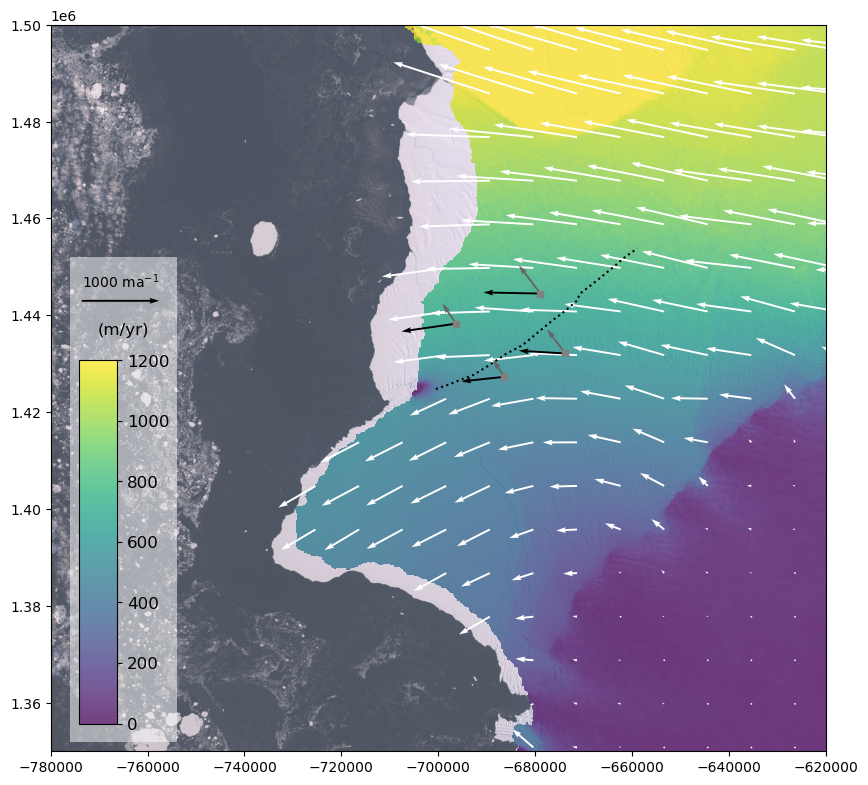

In [13]:
fig=plt.figure(figsize=(10,10))
ax12=fig.add_subplot(1,1,1)

image_hidden = ax12.imshow(vv15imgar,alpha=0.75,vmin=0,vmax=1200)
show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax12)
show(vv15imgar,transform=vx15img.transform,ax=ax12,alpha=0.75,vmin=0,vmax=1200)

skip=75
Q = ax12.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx[ ::skip, ::skip], 
               vy[ ::skip, ::skip], scale = 10000, color='w', width=0.0025)


plt.plot(hh00_x_mean,hh00_y_mean,'s',color='gray',markersize=5)
plt.plot(tt05_x_mean,tt05_y_mean,'s',color='gray',markersize=5)
plt.plot(ss00_x_mean,ss00_y_mean,'s',color='gray',markersize=5)
plt.plot(tt04_x_mean,tt04_y_mean,'s',color='gray',markersize=5)

xi=[hh00_x_mean,tt05_x_mean,ss00_x_mean,tt04_x_mean]
yi=[hh00_y_mean,tt05_y_mean,ss00_y_mean,tt04_y_mean]
vix=[hh00_vx,tt05_vx,ss00_vx,tt04_vx]
viy=[hh00_vy,tt05_vy,ss00_vy,tt04_vy]

Q1 = ax12.quiver(xi,yi,vix,viy, scale = 10000, color='k', width=0.0025)

xrp=[hh00_x_mean,tt05_x_mean,ss00_x_mean,tt04_x_mean]
yrp=[hh00_y_mean,tt05_y_mean,ss00_y_mean,tt04_y_mean]
vrpx=[hh00_v_rperp_x,tt05_v_rperp_x,ss00_v_rperp_x,tt04_v_rperp_x]
vrpy=[hh00_v_rperp_y,tt05_v_rperp_y,ss00_v_rperp_y,tt04_v_rperp_y]

Q2 = ax12.quiver(xrp,yrp,vrpx,vrpy, scale = 10000, color=[0.4,0.4,0.4], width=0.0025)

ax12.plot(riftx,rifty,'k:')

xmin = -780000
xmax = -620000
ymin = 1350000 
ymax = 1500000

ax12.set_xlim(xmin,xmax)
ax12.set_ylim(ymin,ymax)

ax12.add_patch(Rectangle((-776000,1352000),22000,100000,
                    edgecolor = 'none',
                    facecolor = 'white',
                    alpha = 0.5))

cbaxes = inset_axes(ax12, width="5%", height="50%",loc='lower left',borderpad=2)
cbar = plt.colorbar(image_hidden,cax=cbaxes)
cbar.ax.tick_params(labelsize=12)

ax12.annotate("(m/yr)",(-765000,1437000),ha='center',va='center',fontsize=12)

ax12.quiverkey(Q1, 0.09,0.62, 1000, r'1000 ma$^{-1}$')

output = figure_folder+'/figS01_vmap_div.png'
plt.savefig(output, dpi=200, bbox_inches='tight')

plt.show()


### correct GPS for divergence

In [14]:
#hh00_t,actual_hh00_tt05_sep_d
hh00_t_diff = hh00_t - hh00_t[0]
div_cor_hh = hh00_tt05_vdiff_rperp * hh00_t_diff
actual_hh00_tt05_sep_d_div = actual_hh00_tt05_sep_d - div_cor_hh
#print(actual_hh00_tt05_sep_d_div)

#ss00_t,actual_ss00_tt04_sep_d
ss00_t_diff = ss00_t - ss00_t[0]
div_cor_ss = ss00_tt04_vdiff_rperp * ss00_t_diff
actual_ss00_tt04_sep_d_div = actual_ss00_tt04_sep_d - div_cor_ss
#print(actual_hh00_tt05_sep_d_div)

### define rotation to rift coordinates

In [15]:
def estimate_local_rift_orientation_new(pt,x,y):
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest == 0:
        #print(closest)
        #the closest is the first point of the rift, so must be (c to c+1)
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        fwd_azimuth,back_azimuth,distance = geodesic.inv(longc1, latc1, longc2, latc2)
    elif closest == len(x)-1:
        #print(closest-1)
        #the closest is the last point of the rift, so must be previous (c-1 to c)
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        fwd_azimuth,back_azimuth,distance = geodesic.inv(longp1, latp1, longc1, latc1)
    else:
        #the closest is not the first or last, so could be (c-1 to c) or (c to c+1)
        #lat long of rift segments surrounding the closest, and the point
        [latp1,longp1] = transformer_ps2latlon.transform( x[closest-1] , y[closest-1] )
        [latc1,longc1] = transformer_ps2latlon.transform( x[closest] , y[closest] )
        [latc2,longc2] = transformer_ps2latlon.transform( x[closest+1] , y[closest+1] )
        [latpt,longpt] = transformer_ps2latlon.transform( pt.x , pt.y )
        fwd_azimuth_prev,back_azimuth_prev,distance_prev = geodesic.inv(longp1, latp1, longc1, latc1)
        fwd_azimuth_clo,back_azimuth_clo,distance_clo = geodesic.inv(longc1, latc1, longc2, latc2)
        fwd_azimuth_pt,back_azimuth_pt,distance_pt = geodesic.inv(longc1, latc1, longpt, latpt)
        new_zero = np.mean([back_azimuth_prev,fwd_azimuth_clo])
        new_zero_pt = fwd_azimuth_pt - new_zero
        if new_zero_pt > 0:
            #print(closest)
            fwd_azimuth = fwd_azimuth_clo
        elif new_zero_pt < 0:
            #print(closest-1)
            fwd_azimuth = fwd_azimuth_prev 
    return fwd_azimuth


### Dates
Halloween Crack found\
North Rift propagating\
North Rift calved\
ICESat-2 launch

In [16]:
HC_found = 2016 + ((10-1)/12) + ((31-1)/365) 
NR_found = 2020 + ((11-1)/12) + ((1-1)/365)
NR_calve = 2021 + ((2-1)/12) + ((26-1)/365)
IS_start = 2018 + ((10-1)/12) + ((14-1)/365)


### load shapefiles for plots

In [17]:
# Load the ICESat-2 rgts
shpfile1L = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT1L_Antarctica_1_laser1.shp"
shpfile1R = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT1R_Antarctica_1_laser2.shp"
shpfile2L = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT2L_Antarctica_1_laser3.shp"
shpfile2R = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT2R_Antarctica_1_laser4.shp"
shpfile3L = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT3L_Antarctica_1_laser5.shp"
shpfile3R = "/home/ram21/notebooks/brunt-is2-rifts/halloween/shapefiles_for_plotting/Antarctica_repeat1_GT3R_Antarctica_1_laser6.shp"
shapefile1L = gpd.read_file(shpfile1L)
shapefile1R = gpd.read_file(shpfile1R)
shapefile2L = gpd.read_file(shpfile2L)
shapefile2R = gpd.read_file(shpfile2R)
shapefile3L = gpd.read_file(shpfile3L)
shapefile3R = gpd.read_file(shpfile3R)

shapefile1L_ar = {"name": [],"easting": [],"northing": []}
shapefile1R_ar = {"name": [],"easting": [],"northing": []}
shapefile2L_ar = {"name": [],"easting": [],"northing": []}
shapefile2R_ar = {"name": [],"easting": [],"northing": []}
shapefile3L_ar = {"name": [],"easting": [],"northing": []}
shapefile3R_ar = {"name": [],"easting": [],"northing": []}

import shapely

# Function to handle both single-part and multi-part geometries
def extract_coordinates(geometry):
    if geometry.is_empty:
        return np.array([])  # Return an empty array for empty geometries

    if isinstance(geometry, shapely.geometry.base.BaseGeometry):
        # Check if it's a multi-part geometry
        if isinstance(geometry, (shapely.geometry.MultiPoint,
                                 shapely.geometry.MultiLineString,
                                 shapely.geometry.MultiPolygon)):
            # Collect coordinates from all parts
            coords = np.vstack([np.array(part.coords) for part in geometry.geoms])
        else:
            # Single-part geometries
            coords = np.array(geometry.coords)
        return coords

    return np.array([])

# Loop for shapefile1L
for b1L in range(0, len(shapefile1L.Name)):
    geometry = shapefile1L.geometry[b1L]
    
    coords = extract_coordinates(geometry)  # Use the custom function to get coordinates
    
    if len(coords) > 2:  # Check length of coordinates
        shapefile1L_ar["name"].append(int(shapefile1L.Name[b1L]))
        lon = coords[:, 0]  # Extract longitude (x-coordinates)
        lat = coords[:, 1]  # Extract latitude (y-coordinates)
        [easting, northing] = transformer_latlon2ps.transform(lat, lon)
        shapefile1L_ar["easting"].append(easting)
        shapefile1L_ar["northing"].append(northing)
        
# Repeat the same changes for other loops
for b1R in range(0, len(shapefile1R.Name)):
    geometry = shapefile1R.geometry[b1R]
    
    coords = extract_coordinates(geometry)
    
    if len(coords) > 2:
        shapefile1R_ar["name"].append(int(shapefile1R.Name[b1R]))
        lon = coords[:, 0]
        lat = coords[:, 1]
        [easting, northing] = transformer_latlon2ps.transform(lat, lon)
        shapefile1R_ar["easting"].append(easting)
        shapefile1R_ar["northing"].append(northing)

# Loop for shapefile2L
for b2L in range(0, len(shapefile2L.Name)):
    geometry = shapefile2L.geometry[b2L]
    
    coords = extract_coordinates(geometry)  # Use the custom function to get coordinates
    
    if len(coords) > 2:
        shapefile2L_ar["name"].append(int(shapefile2L.Name[b2L]))
        lon = coords[:, 0]
        lat = coords[:, 1]
        [easting, northing] = transformer_latlon2ps.transform(lat, lon)
        shapefile2L_ar["easting"].append(easting)
        shapefile2L_ar["northing"].append(northing)

# Loop for shapefile2R
for b2R in range(0, len(shapefile2R.Name)):
    geometry = shapefile2R.geometry[b2R]
    
    coords = extract_coordinates(geometry)
    
    if len(coords) > 2:
        shapefile2R_ar["name"].append(int(shapefile2R.Name[b2R]))
        lon = coords[:, 0]
        lat = coords[:, 1]
        [easting, northing] = transformer_latlon2ps.transform(lat, lon)
        shapefile2R_ar["easting"].append(easting)
        shapefile2R_ar["northing"].append(northing)

# Loop for shapefile3L with additional filtering logic
for b3L in range(0, len(shapefile3L.Name)):
    geometry = shapefile3L.geometry[b3L]
    
    if b3L not in [43, 54, 66, 78, 88, 122, 133, 145, 157, 169, 192, 203, 214, 225, 237, 249, 250]:
        coords = extract_coordinates(geometry)
        
        if len(coords) > 2:
            shapefile3L_ar["name"].append(int(shapefile3L.Name[b3L]))
            lon = coords[:, 0]
            lat = coords[:, 1]
            [easting, northing] = transformer_latlon2ps.transform(lat, lon)
            shapefile3L_ar["easting"].append(easting)
            shapefile3L_ar["northing"].append(northing)

# Loop for shapefile3R with additional filtering logic
for b3R in range(0, len(shapefile3R.Name)):
    geometry = shapefile3R.geometry[b3R]
    
    if b3R not in [43, 54, 66, 78, 88, 122, 133, 145, 157, 169, 192, 203, 214, 226, 238, 250]:
        coords = extract_coordinates(geometry)
        
        if len(coords) > 2:
            shapefile3R_ar["name"].append(int(shapefile3R.Name[b3R]))
            lon = coords[:, 0]
            lat = coords[:, 1]
            [easting, northing] = transformer_latlon2ps.transform(lat, lon)
            shapefile3R_ar["easting"].append(easting)
            shapefile3R_ar["northing"].append(northing)

# Convert all the dictionaries into DataFrames
shapefile1L_ar = pd.DataFrame(shapefile1L_ar)
shapefile1R_ar = pd.DataFrame(shapefile1R_ar)
shapefile2L_ar = pd.DataFrame(shapefile2L_ar)
shapefile2R_ar = pd.DataFrame(shapefile2R_ar)
shapefile3L_ar = pd.DataFrame(shapefile3L_ar)
shapefile3R_ar = pd.DataFrame(shapefile3R_ar)

## Figure 3 along 215 1LR, 1160 3LR, 786 2LR
Graph of comparison between GPS, ICESat-2, Landsat-8, WorldView

### subset detections

In [18]:
halloween_obs_merged_215_1l = halloween_obs_merged[(halloween_obs_merged["rgt"]==215) & (halloween_obs_merged["beam"]=='1l')]
halloween_obs_merged_215_1r = halloween_obs_merged[(halloween_obs_merged["rgt"]==215) & (halloween_obs_merged["beam"]=='1r')]

halloween_obs_merged_215_1l = gpd.GeoDataFrame(
    halloween_obs_merged_215_1l, geometry=gpd.points_from_xy(halloween_obs_merged_215_1l['x-centroid'], halloween_obs_merged_215_1l['y-centroid']))
halloween_obs_merged_215_1r = gpd.GeoDataFrame(
    halloween_obs_merged_215_1r, geometry=gpd.points_from_xy(halloween_obs_merged_215_1r['x-centroid'], halloween_obs_merged_215_1r['y-centroid']))
    
#display(halloween_obs_merged_215_1l)
#display(halloween_obs_merged_215_1r)

halloween_obs_merged_1160_3l = halloween_obs_merged[(halloween_obs_merged["rgt"]==1160) & (halloween_obs_merged["beam"]=='3l')]
halloween_obs_merged_1160_3r = halloween_obs_merged[(halloween_obs_merged["rgt"]==1160) & (halloween_obs_merged["beam"]=='3r')]

halloween_obs_merged_1160_3l = gpd.GeoDataFrame(
    halloween_obs_merged_1160_3l, geometry=gpd.points_from_xy(halloween_obs_merged_1160_3l['x-centroid'], halloween_obs_merged_1160_3l['y-centroid']))
halloween_obs_merged_1160_3r = gpd.GeoDataFrame(
    halloween_obs_merged_1160_3r, geometry=gpd.points_from_xy(halloween_obs_merged_1160_3r['x-centroid'], halloween_obs_merged_1160_3r['y-centroid']))

#display(halloween_obs_merged_1160_3l)
#display(halloween_obs_merged_1160_3r)

halloween_obs_merged_786_2l = halloween_obs_merged[(halloween_obs_merged["rgt"]==786) & (halloween_obs_merged["beam"]=='2l')]
halloween_obs_merged_786_2r = halloween_obs_merged[(halloween_obs_merged["rgt"]==786) & (halloween_obs_merged["beam"]=='2r')]

halloween_obs_merged_786_2l = gpd.GeoDataFrame(
    halloween_obs_merged_786_2l, geometry=gpd.points_from_xy(halloween_obs_merged_786_2l['x-centroid'], halloween_obs_merged_786_2l['y-centroid']))
halloween_obs_merged_786_2r = gpd.GeoDataFrame(
    halloween_obs_merged_786_2r, geometry=gpd.points_from_xy(halloween_obs_merged_786_2r['x-centroid'], halloween_obs_merged_786_2r['y-centroid']))
    
#display(halloween_obs_merged_786_2l)
#display(halloween_obs_merged_786_2r)



In [19]:
display(halloween_obs_merged_1160_3l)

,d-start,d-end,x-start,y-start,x-end,y-end,x-centroid,y-centroid,lat-centroid,lon-centroid,...,sl_offset,time,rgt,azimuth,sigma,h,beam,data_row,confidence,geometry
159,1.586610e+06,1.587562e+06,-689044.442250,1.429177e+06,-689594.686663,1.429969e+06,-689319.564456,1.429573e+06,-75.468258,-25.742693,...,--,2019-12-11 21:34:29.979251+00:00,1160,-8.906248,0.133705,3.147567,3l,6264,high,POINT (-689319.564 1429573.287)
201,1.586667e+06,1.587639e+06,-689081.823392,1.429223e+06,-689641.948434,1.430032e+06,-689361.885913,1.429628e+06,-75.467646,-25.743215,...,5.310891,2020-03-11 17:14:18.643117+00:00,1160,-8.918519,0.079509,2.730635,3l,7716,high,POINT (-689361.886 1429627.743)
243,1.586782e+06,1.587715e+06,-689158.244082,1.429314e+06,-689697.120089,1.430090e+06,-689427.682086,1.429702e+06,-75.466783,-25.744193,...,--,2020-06-10 12:54:03.148957+00:00,1160,-8.910502,0.085814,3.311223,3l,9150,high,POINT (-689427.682 1429701.832)
295,1.586861e+06,1.587812e+06,-689197.092889,1.429383e+06,-689746.890999,1.430174e+06,-689471.991944,1.429778e+06,-75.465984,-25.744434,...,NaN,2020-09-09 08:33:51.654833+00:00,1160,-8.914852,0.224063,NaN,3l,10584,low,POINT (-689471.992 1429778.307)
378,1.586843e+06,1.587933e+06,-689177.353448,1.429373e+06,-689806.927390,1.430279e+06,-689492.140419,1.429826e+06,-75.465516,-25.744342,...,--,2021-06-08 19:33:25.881857+00:00,1160,-8.907513,0.235392,3.501101,3l,14790,high,POINT (-689492.140 1429825.957)


### rotate to rift coordinates

In [20]:
azimuth_1l = []

for index, row in halloween_obs_merged_215_1l.iterrows():
    azimuth_1l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1l = np.abs(np.sin(np.deg2rad(azimuth_1l - halloween_obs_merged_215_1l['azimuth']))) * halloween_obs_merged_215_1l['width']
actual_non_iceberg_width_1l = np.abs(np.sin(np.deg2rad(azimuth_1l - halloween_obs_merged_215_1l['azimuth']))) * halloween_obs_merged_215_1l['non-iceberg-width']

azimuth_1r = []

for index, row in halloween_obs_merged_215_1r.iterrows():    
    azimuth_1r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1r = np.abs(np.sin(np.deg2rad(azimuth_1r - halloween_obs_merged_215_1r['azimuth']))) * halloween_obs_merged_215_1r['width']
actual_non_iceberg_width_1r = np.abs(np.sin(np.deg2rad(azimuth_1r - halloween_obs_merged_215_1r['azimuth']))) * halloween_obs_merged_215_1r['non-iceberg-width']

azimuth_3l = []

for index, row in halloween_obs_merged_1160_3l.iterrows():
    azimuth_3l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_3l = np.abs(np.sin(np.deg2rad(azimuth_3l - halloween_obs_merged_1160_3l['azimuth']))) * halloween_obs_merged_1160_3l['width']
actual_non_iceberg_width_3l = np.abs(np.sin(np.deg2rad(azimuth_3l - halloween_obs_merged_1160_3l['azimuth']))) * halloween_obs_merged_1160_3l['non-iceberg-width']

azimuth_3r = []

for index, row in halloween_obs_merged_1160_3r.iterrows():
    azimuth_3r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_3r = np.abs(np.sin(np.deg2rad(azimuth_3r - halloween_obs_merged_1160_3r['azimuth']))) * halloween_obs_merged_1160_3r['width']
actual_non_iceberg_width_3r = np.abs(np.sin(np.deg2rad(azimuth_3r - halloween_obs_merged_1160_3r['azimuth']))) * halloween_obs_merged_1160_3r['non-iceberg-width']

azimuth_786_2l = []

for index, row in halloween_obs_merged_786_2l.iterrows():
    azimuth_786_2l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_786_2l = np.abs(np.sin(np.deg2rad(azimuth_786_2l - halloween_obs_merged_786_2l['azimuth']))) * halloween_obs_merged_786_2l['width']
actual_non_iceberg_width_786_2l = np.abs(np.sin(np.deg2rad(azimuth_786_2l - halloween_obs_merged_786_2l['azimuth']))) * halloween_obs_merged_786_2l['non-iceberg-width']

azimuth_786_2r = []

for index, row in halloween_obs_merged_786_2r.iterrows():    
    azimuth_786_2r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_786_2r = np.abs(np.sin(np.deg2rad(azimuth_786_2r - halloween_obs_merged_786_2r['azimuth']))) * halloween_obs_merged_786_2r['width']
actual_non_iceberg_width_786_2r = np.abs(np.sin(np.deg2rad(azimuth_786_2r - halloween_obs_merged_786_2r['azimuth']))) * halloween_obs_merged_786_2r['non-iceberg-width']


halloween_obs_merged_215_1l['rift-angle'] = pd.Series(np.array(azimuth_1l), index=halloween_obs_merged_215_1l.index)
halloween_obs_merged_215_1r['rift-angle'] = pd.Series(np.array(azimuth_1r), index=halloween_obs_merged_215_1r.index)
halloween_obs_merged_215_1l["actual-width"] = pd.Series(np.array(actual_width_1l), index=halloween_obs_merged_215_1l.index)
halloween_obs_merged_215_1r["actual-width"] = pd.Series(np.array(actual_width_1r), index=halloween_obs_merged_215_1r.index)
halloween_obs_merged_215_1l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1l), index=halloween_obs_merged_215_1l.index)
halloween_obs_merged_215_1r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1r), index=halloween_obs_merged_215_1r.index)

#display(halloween_obs_merged_215_1l)
#display(halloween_obs_merged_215_1r)

halloween_obs_merged_1160_3l['rift-angle'] = pd.Series(np.array(azimuth_3l), index=halloween_obs_merged_1160_3l.index)
halloween_obs_merged_1160_3r['rift-angle'] = pd.Series(np.array(azimuth_3r), index=halloween_obs_merged_1160_3r.index)
halloween_obs_merged_1160_3l["actual-width"] = pd.Series(np.array(actual_width_3l), index=halloween_obs_merged_1160_3l.index)
halloween_obs_merged_1160_3r["actual-width"] = pd.Series(np.array(actual_width_3r), index=halloween_obs_merged_1160_3r.index)
halloween_obs_merged_1160_3l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_3l), index=halloween_obs_merged_1160_3l.index)
halloween_obs_merged_1160_3r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_3r), index=halloween_obs_merged_1160_3r.index)

#display(halloween_obs_merged_1160_3l)
#display(halloween_obs_merged_1160_3r)

halloween_obs_merged_786_2l['rift-angle'] = pd.Series(np.array(azimuth_786_2l), index=halloween_obs_merged_786_2l.index)
halloween_obs_merged_786_2r['rift-angle'] = pd.Series(np.array(azimuth_786_2r), index=halloween_obs_merged_786_2r.index)
halloween_obs_merged_786_2l["actual-width"] = pd.Series(np.array(actual_width_786_2l), index=halloween_obs_merged_786_2l.index)
halloween_obs_merged_786_2r["actual-width"] = pd.Series(np.array(actual_width_786_2r), index=halloween_obs_merged_786_2r.index)
halloween_obs_merged_786_2l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_786_2l), index=halloween_obs_merged_786_2l.index)
halloween_obs_merged_786_2r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_786_2r), index=halloween_obs_merged_786_2r.index)

#display(halloween_obs_merged_786_2l)
#display(halloween_obs_merged_786_2r)


### calculate decimal time

In [21]:
num_215_1l = [66,102,129,169,259,302,314,347,398]
num_215_1r = [69,105,132,172,262,305,317,350,401]

num_1160_3l = [159,201,243,295,378]
num_1160_3r = [30,162,204,246,381]

num_786_2l = [23,48,115,146,188,236,309,371]
num_786_2r = [26,51,118,149,191,239,312,374]

time_215_1l = halloween_obs_merged_215_1l["time"]
time_215_1r = halloween_obs_merged_215_1r["time"]

year_215_1l = []
month_215_1l = []
day_215_1l = []
year_215_1r = []
month_215_1r = []
day_215_1r = []

time_1160_3l = halloween_obs_merged_1160_3l["time"]
time_1160_3r = halloween_obs_merged_1160_3r["time"]

year_1160_3l = []
month_1160_3l = []
day_1160_3l = []
year_1160_3r = []
month_1160_3r = []
day_1160_3r = []

time_786_2l = halloween_obs_merged_786_2l["time"]
time_786_2r = halloween_obs_merged_786_2r["time"]

year_786_2l = []
month_786_2l = []
day_786_2l = []
year_786_2r = []
month_786_2r = []
day_786_2r = []


for tl in range(0,len(time_215_1l)):
    year_215_1l.append(int(str(time_215_1l[num_215_1l[tl]].date())[0:4]))
    month_215_1l.append(int(str(time_215_1l[num_215_1l[tl]].date())[5:7]))
    day_215_1l.append(int(str(time_215_1l[num_215_1l[tl]].date())[8:10]))

for tr in range(0,len(time_215_1r)):
    year_215_1r.append(int(str(time_215_1r[num_215_1r[tr]].date())[0:4]))
    month_215_1r.append(int(str(time_215_1r[num_215_1r[tr]].date())[5:7]))
    day_215_1r.append(int(str(time_215_1r[num_215_1r[tr]].date())[8:10]))

decdate_215_1l = np.array(year_215_1l) + ((np.array(month_215_1l)-1) / 12) + ((np.array(day_215_1l)-1) / 365)
decdate_215_1r = np.array(year_215_1r) + ((np.array(month_215_1r)-1) / 12) + ((np.array(day_215_1r)-1) / 365)

for tl2 in range(0,len(time_1160_3l)):
    year_1160_3l.append(int(str(time_1160_3l[num_1160_3l[tl2]].date())[0:4]))
    month_1160_3l.append(int(str(time_1160_3l[num_1160_3l[tl2]].date())[5:7]))
    day_1160_3l.append(int(str(time_1160_3l[num_1160_3l[tl2]].date())[8:10]))

for tr2 in range(0,len(time_1160_3r)):
    year_1160_3r.append(int(str(time_1160_3r[num_1160_3r[tr2]].date())[0:4]))
    month_1160_3r.append(int(str(time_1160_3r[num_1160_3r[tr2]].date())[5:7]))
    day_1160_3r.append(int(str(time_1160_3r[num_1160_3r[tr2]].date())[8:10]))

decdate_1160_3l = np.array(year_1160_3l) + ((np.array(month_1160_3l)-1) / 12) + ((np.array(day_1160_3l)-1) / 365)
decdate_1160_3r = np.array(year_1160_3r) + ((np.array(month_1160_3r)-1) / 12) + ((np.array(day_1160_3r)-1) / 365)

for tl in range(0,len(time_786_2l)):
    year_786_2l.append(int(str(time_786_2l[num_786_2l[tl]].date())[0:4]))
    month_786_2l.append(int(str(time_786_2l[num_786_2l[tl]].date())[5:7]))
    day_786_2l.append(int(str(time_786_2l[num_786_2l[tl]].date())[8:10]))

for tr in range(0,len(time_786_2r)):
    year_786_2r.append(int(str(time_786_2r[num_786_2r[tr]].date())[0:4]))
    month_786_2r.append(int(str(time_786_2r[num_786_2r[tr]].date())[5:7]))
    day_786_2r.append(int(str(time_786_2r[num_786_2r[tr]].date())[8:10]))

decdate_786_2l = np.array(year_786_2l) + ((np.array(month_786_2l)-1) / 12) + ((np.array(day_786_2l)-1) / 365)
decdate_786_2r = np.array(year_786_2r) + ((np.array(month_786_2r)-1) / 12) + ((np.array(day_786_2r)-1) / 365)


### satellite measurements

In [22]:
# from satellite imagery
# year, month, day, width, estimated azimuth
# DigitalGlobe_215_1l

satellite_obs_215 = {
    "platform": ["WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "WV","WV","WV","WV"],
    "rgt": [215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215,215,215,215,215,215,215,\
            215,215,215,215],
    "laser": ["1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1l","1l","1l","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1r","1r","1r","1r","1r","1r",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1l","1r","1l","1r"],
    "year": [2016,2016,2017,2017,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2021,2021,\
             2016,2016,2017,2017,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,2019,2019,2019,\
             2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,\
             2019,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2022,2022,2022,2022],
    "month": [12,12,11,11,3,12,4,9,11,12,2,3,3,11,12,12,1,1,\
              12,12,11,11,3,12,4,9,11,12,2,3,3,11,12,12,1,1,\
              11,12,12,1,2,3,9,10,10,10,10,11,1,2,3,10,10,10,\
              11,12,12,1,2,2,9,10,10,10,11,12,1,2,9,10,10,11,\
              11,12,12,11,12,12,1,2,3,9,10,10,10,10,11,1,2,3,\
              10,10,10,11,12,12,1,2,2,9,10,10,10,11,12,1,2,9,\
              10,10,11,11,12,12,\
              1,1,3,3,3,4,4,9,10,12,\
              1,1,3,3,3,4,4,9,10,12,\
              1,1,1,1],
    "day": [4,11,17,22,13,4,11,18,2,2,15,22,24,29,7,9,19,19,\
            4,11,17,22,13,4,11,18,2,2,15,22,24,29,7,9,19,19,\
            12,21,30,8,14,11,28,5,12,14,21,29,18,19,23,1,17,31,\
            2,2,27,28,20,22,24,1,10,19,18,22,7,6,20,6,20,5,\
            7,5,25,12,21,30,8,14,11,28,5,12,14,21,29,18,19,23,\
            1,17,31,2,2,27,28,20,22,24,1,10,19,18,22,7,6,20,\
            6,20,5,7,5,25,\
            12,19,1,17,24,2,4,25,2,31,\
            12,19,1,17,24,2,4,25,2,31,\
            3,3,7,7],
    "centroid_lon": [-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7225,-25.7225,-25.7225,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,-25.7225,\
                     -25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,-25.7257,\
                     -25.7225,-25.7257,-25.7225,-25.7257],
    "centroid_lat": [-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4708,-75.4708,-75.4708,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,-75.4708,\
                     -75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,-75.4710,\
                     -75.4708,-75.4710,-75.4708,-75.4710],
    "total_width": [21.8,17.4,230,232.1,318.1,715.6,789.7,769.5,750.3,785.4,849,880,878,1118.3,1088.4,1120.3,1112.3,1118.5,\
              14,14.8,228.8,230.8,321,730.4,798.9,843.6,806.2,775.1,834,872.4,874,1077.8,1116.9,1097.8,1124.4,1129.8,\
              224,251,268,259,270,283,645,663,671,669,665,706,732,746,738,732,741,746,\
              750,772,765,808,838,838,979,982,1015,1026,1077,1104,1104,1101,1052,1068,1067,1070,\
              1076,1096,1104,223,246,252,247,267,293,623,636,649,659,663,709,740,744,740,\
              797,785,770,774,761,796,805,826,832,990,993,1012,1019,1043,1111,1106,1106,1066,\
              1069,1080,1085,1080,1087,1096,\
              1127,1114,1121,1094,1100,1106,1078,1073,1081,1117,\
              1130,1130,1120,1106,1100,1095,1082,1071,1089,1107,\
              1123.8,1109.0,1126.4,1119.0],
    "non-iceberg_width": [21.8,17.4,230,232.1,318.1,515,619,732,750.3,785.4,849,880,878,1118.3,1088.4,1120.3,1112.3,1118.5,\
              14,14.8,228.8,230.8,321,505,628,719,756.0,775.1,834,872.4,874,1077.8,1116.9,1097.8,1124.4,1129.8,\
              224,251,268,259,270,283,404,427,435,442,442,490,513,534,558,653,685,682,\
              701,772,765,808,838,838,979,982,1015,1026,1077,1104,1104,1101,1052,1068,1067,1070,\
              1076,1096,1104,223,246,252,247,267,293,401,420,439,455,446,494,513,530,543,\
              667,681,770,774,761,796,805,826,832,990,993,1012,1019,1043,1111,1106,1106,1066,\
              1069,1080,1085,1080,1087,1096,\
              1127,1114,1121,1094,1100,1106,1078,1073,1081,1117,\
              1130,1130,1120,1106,1100,1095,1082,1071,1089,1107,\
              1123.8,1109.0,1126.4,1119.0], 
    "comment": ["-","-","-","-","-","bridge","bridge","bridge","bridge","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","bridge","bridge","bridge","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "bridge","bridge","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","bridge","bridge","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-"],
    "azimuth": [-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9]
}

satellite_obs_215 = pd.DataFrame(satellite_obs_215)

# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_215.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_215["decimal_date"] = decimal_date
satellite_obs_215["x-centroid"] = Ecentroid
satellite_obs_215["y-centroid"] = Ncentroid

satellite_obs_215 = gpd.GeoDataFrame(satellite_obs_215, geometry=gpd.points_from_xy(satellite_obs_215["x-centroid"],satellite_obs_215["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_215.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_215['azimuth']))) * satellite_obs_215['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_215['azimuth']))) * satellite_obs_215['non-iceberg_width']

satellite_obs_215['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_215.index)
satellite_obs_215['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_215.index)
satellite_obs_215['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_215.index)

satellite_obs_215_WV_1l = satellite_obs_215[(satellite_obs_215["platform"]=="WV") & (satellite_obs_215["laser"]=="1l")]
satellite_obs_215_WV_1r = satellite_obs_215[(satellite_obs_215["platform"]=="WV") & (satellite_obs_215["laser"]=="1r")]
satellite_obs_215_L8_1l = satellite_obs_215[(satellite_obs_215["platform"]=="L8") & (satellite_obs_215["laser"]=="1l")]
satellite_obs_215_L8_1r = satellite_obs_215[(satellite_obs_215["platform"]=="L8") & (satellite_obs_215["laser"]=="1r")]

#display(satellite_obs_215)
#display(satellite_obs_215_WV_1l)
#display(satellite_obs_215_WV_1r)
#display(satellite_obs_215_L8_1l)
#display(satellite_obs_215_L8_1r)


In [23]:
# from satellite imagery
# year, month, day, width, estimated azimuth
# DigitalGlobe_215_1l

satellite_obs_1160 = {
    "platform": ["WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "WV","WV","WV","WV"],
    "rgt": [1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160,1160,1160,1160,1160,1160,1160,\
            1160,1160,1160,1160],
    "laser": ["3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3l","3l","3l","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3r","3r","3r","3r","3r","3r",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3l","3r","3l","3r"],
    "year": [2016,2016,2017,2017,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2021,2021,\
             2016,2016,2017,2017,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,2019,2019,2019,\
             2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,\
             2019,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2022,2022,2022,2022],
    "month": [12,12,11,11,3,12,4,9,11,12,2,3,3,11,12,12,1,1,\
              12,12,11,11,3,12,4,9,11,12,2,3,3,11,12,12,1,1,\
              11,12,12,1,2,3,9,10,10,10,10,11,1,2,3,10,10,10,\
              11,12,12,1,2,2,9,10,10,10,11,12,1,2,9,10,10,11,\
              11,12,12,11,12,12,1,2,3,9,10,10,10,10,11,1,2,3,\
              10,10,10,11,12,12,1,2,2,9,10,10,10,11,12,1,2,9,\
              10,10,11,11,12,12,\
              1,1,3,3,3,4,4,9,10,12,\
              1,1,3,3,3,4,4,9,10,12,\
              1,1,1,1],
    "day": [4,11,17,22,13,4,11,18,2,2,15,22,24,29,7,9,19,19,\
            4,11,17,22,13,4,11,18,2,2,15,22,24,29,7,9,19,19,\
            12,21,30,8,14,11,28,5,12,14,21,29,18,19,23,1,17,31,\
            2,2,27,28,20,22,24,1,10,19,18,22,7,6,20,6,20,5,\
            7,5,25,12,21,30,8,14,11,28,5,12,14,21,29,18,19,23,\
            1,17,31,2,2,27,28,20,22,24,1,10,19,18,22,7,6,20,\
            6,20,5,7,5,25,\
            12,19,1,17,24,2,4,25,2,31,\
            12,19,1,17,24,2,4,25,2,31,\
            3,3,7,7],
    "centroid_lon": [-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7374,-25.7374,-25.7374,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,-25.7374,\
                     -25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,-25.7407,\
                     -25.7374,-25.7407,-25.7374,-25.7407],
    "centroid_lat": [-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4718,-75.4718,-75.4718,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,-75.4718,\
                     -75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,-75.4719,\
                     -75.4718,-75.4719,-75.4718,-75.4719],
    "total_width": [16.7,17.9,224.7,230.9,318.8,591.8,806.6,908.8,932.2,946.1,965,937.7,937.7,1070.7,1078.7,1081.7,1103.3,1102.8,\
              16.8,18.5,219.6,222.1,319.4,548.8,781.6,916.1,941.3,954,1003.1,998.5,1001.2,1070.2,1077,1079.3,1090.6,1088.6,\
              221,241,246,260,269,296,475,477,484,485,493,576,684,729,758,903,912,899,\
              914,928,950,947,946,952,993,992,1006,1015,1046,1068,1077,1082,1132,1152,1162,1163,\
              1166,1136,1134,220,240,245,255,275,294,464,472,485,490,507,544,638,715,763,\
              904,923,940,931,924,947,983,987,988,979,992,1000,1004,1052,1062,1066,1066,1126,\
              1145,1154,1166,1171,1172,1179,\
              1100,1108,1101,1101,1094,1113,1084,1130,1158,1134,\
              1091,1095,1106,1096,1099,1093,1088,1127,1139,1164,\
              1141.8,1165.6,1146.9,1163.2],
    "non-iceberg_width": [16.7,17.9,224.7,230.9,318.8,533.8,612.7,725.1,768.6,786.9,853.4,869.7,876.1,1070.7,1078.7,1081.7,1103.3,1102.8,\
              16.8,18.5,219.6,222.1,319.4,548.8,617.8,715.3,760.7,782.2,865.8,882.9,884.4,1070.2,1077,1079.3,1090.6,1088.6,\
              221,241,246,260,269,296,475,477,484,485,493,498,536,527,538,676,697,687,\
              704,747,791,799,819,824,993,992,1006,1015,1046,1068,1077,1082,1132,1152,1162,1163,\
              1166,1136,1134,220,240,245,255,275,294,464,472,485,490,507,544,552,576,584,\
              681,685,720,720,713,752,815,813,805,979,992,1000,1004,1052,1062,1066,1066,1126,\
              1145,1154,1166,1171,1172,1179,\
              1100,1108,1101,1101,1094,1113,1084,1130,1158,1134,\
              1091,1095,1106,1096,1099,1093,1088,1127,1139,1164,\
              1141.8,1165.6,1146.9,1163.2], 
    "comment": ["-","-","-","-","-","bridge","bridge","bridge","bridge","bridge","bridge","bridge","bridge","-","-","-","-","-",\
                "-","-","-","-","-","-","bridge","bridge","bridge","bridge","bridge","bridge","bridge","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","bridge","bridge","bridge","bridge","bridge","bridge","bridge",\
                "bridge","bridge","bridge","bridge","bridge","bridge","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-","bridge","bridge","bridge","bridge",\
                "bridge","bridge","bridge","bridge","bridge","bridge","bridge","bridge","bridge","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-"],
    "azimuth": [-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9]
}

satellite_obs_1160 = pd.DataFrame(satellite_obs_1160)

# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_1160.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_1160["decimal_date"] = decimal_date
satellite_obs_1160["x-centroid"] = Ecentroid
satellite_obs_1160["y-centroid"] = Ncentroid

satellite_obs_1160 = gpd.GeoDataFrame(satellite_obs_1160, geometry=gpd.points_from_xy(satellite_obs_1160["x-centroid"],satellite_obs_1160["y-centroid"]))

# calculate the actual width

azimuth = []

for index, row in satellite_obs_1160.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1160['azimuth']))) * satellite_obs_1160['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1160['azimuth']))) * satellite_obs_1160['non-iceberg_width']

satellite_obs_1160['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_1160.index)
satellite_obs_1160['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_1160.index)
satellite_obs_1160['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_1160.index)

satellite_obs_1160_WV_3l = satellite_obs_1160[(satellite_obs_1160["platform"]=="WV") & (satellite_obs_1160["laser"]=="3l")]
satellite_obs_1160_WV_3r = satellite_obs_1160[(satellite_obs_1160["platform"]=="WV") & (satellite_obs_1160["laser"]=="3r")]
satellite_obs_1160_L8_3l = satellite_obs_1160[(satellite_obs_1160["platform"]=="L8") & (satellite_obs_1160["laser"]=="3l")]
satellite_obs_1160_L8_3r = satellite_obs_1160[(satellite_obs_1160["platform"]=="L8") & (satellite_obs_1160["laser"]=="3r")]

#display(satellite_obs_1160)
#display(satellite_obs_1160_WV_3l)
#display(satellite_obs_1160_WV_3r)
#display(satellite_obs_1160_L8_3l)
#display(satellite_obs_1160_L8_3r)



In [24]:
# from satellite imagery
# year, month, day, width, estimated azimuth
# DigitalGlobe_786_2l

satellite_obs_786 = {
    "platform": ["WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "WV","WV"],
    "rgt": [786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,\
            786,786,786,786,786,786,786,786,786,786,\
            786,786],
    "laser": ["2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2l","2l","2l","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2r","2r","2r","2r","2r","2r",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2l","2r"],
    "year": [2016,2016,2017,2017,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2021,\
             2016,2016,2017,2017,2018,2018,2019,2019,2019,2019,2020,2020,2020,2020,2020,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,2019,2019,2019,\
             2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,2019,2019,2019,\
             2019,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2020,2020,2020,2020,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2022,2022],
    "month": [12,12,11,11,3,12,4,9,11,12,3,3,11,12,12,1,\
              12,12,11,11,3,12,4,9,11,12,3,3,11,12,12,1,\
              11,12,12,1,2,3,9,10,10,10,10,11,1,2,3,10,10,10,\
              11,12,12,1,2,2,9,10,10,10,11,12,1,2,9,10,10,11,\
              11,12,12,11,12,12,1,2,3,9,10,10,10,10,11,1,2,3,\
              10,10,10,11,12,12,1,2,2,9,10,10,10,11,12,1,2,9,\
              10,10,11,11,12,12,\
              1,1,3,3,3,4,4,9,10,12,\
              1,1,3,3,3,4,4,9,10,12,\
              1,1],
    "day": [4,11,17,22,13,4,11,18,2,2,22,24,29,7,9,19,\
            4,11,17,22,13,4,11,18,2,2,22,24,29,7,9,19,\
            12,21,30,8,14,11,28,5,12,14,21,29,18,19,23,1,17,31,\
            2,2,27,28,20,22,24,1,10,19,18,22,7,6,20,6,20,5,\
            7,5,25,12,21,30,8,14,11,28,5,12,14,21,29,18,19,23,\
            1,17,31,2,2,27,28,20,22,24,1,10,19,18,22,7,6,20,\
            6,20,5,7,5,25,\
            12,19,1,17,24,2,4,25,2,31,\
            12,19,1,17,24,2,4,25,2,31,\
            3,3],
    "centroid_lon": [-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7625,-25.7625,-25.7625,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,-25.7625,\
                     -25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,-25.7590,\
                     -25.7625,-25.7590],
    "centroid_lat": [-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,-75.4675,\
                     -75.4675,-75.4675],
    "total_width": [16.5,18.3,211.7,215.1,303.8,543.0,645.8,765.3,909.5,968.4,1097.2,1102.8,1220.2,1225.8,1227.5,1204.6,\
                    16.8,17.6,214.1,212.2,301.6,538.6,649.6,872.7,950.7,987.9,1097.0,1100.5,1195.2,1190.2,1191.6,1148.9,\
                    192,223,232,243,272,284,475,483,500,497,494,532,568,602,607,799,856,927,\
                    913,985,966,1038,1084,1083,1170,1172,1184,1194,1214,1223,1210,1198,1067,1076,1089,1090,\
                    1104,1137,1165,195,220,225,244,268,281,456,462,478,476,483,526,576,597,605,\
                    919,945,944,964,1007,1034,1060,1087,1099,1150,1154,1171,1184,1200,1157,1149,1130,1050,\
                    1083,1094,1118,1127,1152,1186,\
                    1202,1202,1115,1096,1099,1091,1108,1076,1080,1166,\
                    1140,1139,1110,1105,1085,1084,1077,1073,1082,1210,\
                    1172.0,1206.7],
    "non-iceberg_width": [16.5,18.3,211.7,215.1,303.8,543.0,645.8,765.3,869.7,823.2,888.3,893.2,1108.4,1114.2,1115.8,1121.2,\
                    16.8,17.6,214.1,212.2,301.6,538.6,649.6,832.3,801.9,827.6,889.5,894.5,1094.5,1093.5,1098.4,1148.9,\
                    192,223,232,243,272,284,475,483,500,497,494,532,568,602,607,799,788,836,\
                    821,835,811,860,871,863,979,986,1001,1020,1064,1094,1094,1130,1067,1076,1089,1090,\
                    1104,1137,1165,195,220,225,244,268,281,456,462,478,476,483,526,576,597,605,\
                    785,815,783,780,803,832,831,852,863,973,982,1001,1047,1063,1071,1074,1081,1050,\
                    1083,1094,1118,1127,1152,1186,\
                    1092,1108,1047,1096,1099,1091,1108,1076,1080,1166,\
                    1075,1080,1110,1105,1085,1084,1077,1073,1082,1210,\
                    1172.0,1206.7], 
    "comment": ["-","-","-","-","-","-","-","-","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg",\
                "-","-","-","-","-","-","-","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","iceberg","iceberg",\
                "iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","iceberg","-",\
                "-","-","-","-","-","-",\
                "iceberg","iceberg","iceberg","-","-","-","-","-","-","-",\
                "iceberg","iceberg","-","-","-","-","-","-","-","-",\
                "-","-"],
    "azimuth": [-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1]
}

satellite_obs_786 = pd.DataFrame(satellite_obs_786)

# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_786.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_786["decimal_date"] = decimal_date
satellite_obs_786["x-centroid"] = Ecentroid
satellite_obs_786["y-centroid"] = Ncentroid

satellite_obs_786 = gpd.GeoDataFrame(satellite_obs_786, geometry=gpd.points_from_xy(satellite_obs_786["x-centroid"],satellite_obs_786["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_786.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_786['azimuth']))) * satellite_obs_786['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_786['azimuth']))) * satellite_obs_786['non-iceberg_width']

satellite_obs_786['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_786.index)
satellite_obs_786['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_786.index)
satellite_obs_786['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_786.index)

satellite_obs_786_WV_2l = satellite_obs_786[(satellite_obs_786["platform"]=="WV") & (satellite_obs_786["laser"]=="2l")]
satellite_obs_786_WV_2r = satellite_obs_786[(satellite_obs_786["platform"]=="WV") & (satellite_obs_786["laser"]=="2r")]
satellite_obs_786_L8_2l = satellite_obs_786[(satellite_obs_786["platform"]=="L8") & (satellite_obs_786["laser"]=="2l")]
satellite_obs_786_L8_2r = satellite_obs_786[(satellite_obs_786["platform"]=="L8") & (satellite_obs_786["laser"]=="2r")]

#display(satellite_obs_786)
#display(satellite_obs_786_WV_2l)
#display(satellite_obs_786_WV_2r)
#display(satellite_obs_786_L8_2l)
#display(satellite_obs_786_L8_2r)


### error bars

In [25]:
# error bars
l8_pix = 30 # m rgb pixels
wv_pix  = 0.5 # m approx pixels
nr_pix  = 2 # number of pixels each side

l8_215_1l_err = []
l8_215_1r_err = []
wv_215_1l_err = []
wv_215_1r_err = []
l8_1160_3l_err = []
l8_1160_3r_err = []
wv_1160_3l_err = []
wv_1160_3r_err = []
l8_786_2l_err = []
l8_786_2r_err = []
wv_786_2l_err = []
wv_786_2r_err = []

# double sized error bars where iceberg/peninsula/bridge within rift

#215
for ii in range (0,len(satellite_obs_215_WV_1l["total_width"])):
    if (satellite_obs_215_WV_1l["total_width"].iloc[ii] == satellite_obs_215_WV_1l["non-iceberg_width"].iloc[ii]):
        wv_215_1l_err.append(1*wv_pix*nr_pix)
    else:
        wv_215_1l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_215_WV_1r["total_width"])):
    if (satellite_obs_215_WV_1r["total_width"].iloc[ij] == satellite_obs_215_WV_1r["non-iceberg_width"].iloc[ij]):
        wv_215_1r_err.append(1*wv_pix*nr_pix)
    else:
        wv_215_1r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_215_L8_1l["total_width"])):
    if (satellite_obs_215_L8_1l["total_width"].iloc[ik] == satellite_obs_215_L8_1l["non-iceberg_width"].iloc[ik]):
        l8_215_1l_err.append(1*l8_pix*nr_pix)
    else:
        l8_215_1l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_215_L8_1r["total_width"])):
    if (satellite_obs_215_L8_1r["total_width"].iloc[il] == satellite_obs_215_L8_1r["non-iceberg_width"].iloc[il]):
        l8_215_1r_err.append(1*l8_pix*nr_pix)
    else:
        l8_215_1r_err.append(2*l8_pix*nr_pix)

#1160
for ji in range (0,len(satellite_obs_1160_WV_3l["total_width"])):
    if (satellite_obs_1160_WV_3l["total_width"].iloc[ji] == satellite_obs_1160_WV_3l["non-iceberg_width"].iloc[ji]):
        wv_1160_3l_err.append(1*wv_pix*nr_pix)
    else:
        wv_1160_3l_err.append(2*wv_pix*nr_pix)
        
for jj in range (0,len(satellite_obs_1160_WV_3r["total_width"])):
    if (satellite_obs_1160_WV_3r["total_width"].iloc[jj] == satellite_obs_1160_WV_3r["non-iceberg_width"].iloc[jj]):
        wv_1160_3r_err.append(1*wv_pix*nr_pix)
    else:
        wv_1160_3r_err.append(2*wv_pix*nr_pix)
        
for jk in range (0,len(satellite_obs_1160_L8_3l["total_width"])):
    if (satellite_obs_1160_L8_3l["total_width"].iloc[jk] == satellite_obs_1160_L8_3l["non-iceberg_width"].iloc[jk]):
        l8_1160_3l_err.append(1*l8_pix*nr_pix)
    else:
        l8_1160_3l_err.append(2*l8_pix*nr_pix)
        
for jl in range (0,len(satellite_obs_1160_L8_3r["total_width"])):
    if (satellite_obs_1160_L8_3r["total_width"].iloc[jl] == satellite_obs_1160_L8_3r["non-iceberg_width"].iloc[jl]):
        l8_1160_3r_err.append(1*l8_pix*nr_pix)
    else:
        l8_1160_3r_err.append(2*l8_pix*nr_pix)
        
#786
for ii in range (0,len(satellite_obs_786_WV_2l["total_width"])):
    if (satellite_obs_786_WV_2l["total_width"].iloc[ii] == satellite_obs_786_WV_2l["non-iceberg_width"].iloc[ii]):
        wv_786_2l_err.append(1*wv_pix*nr_pix)
    else:
        wv_786_2l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_786_WV_2r["total_width"])):
    if (satellite_obs_786_WV_2r["total_width"].iloc[ij] == satellite_obs_786_WV_2r["non-iceberg_width"].iloc[ij]):
        wv_786_2r_err.append(1*wv_pix*nr_pix)
    else:
        wv_786_2r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_786_L8_2l["total_width"])):
    if (satellite_obs_786_L8_2l["total_width"].iloc[ik] == satellite_obs_786_L8_2l["non-iceberg_width"].iloc[ik]):
        l8_786_2l_err.append(1*l8_pix*nr_pix)
    else:
        l8_786_2l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_786_L8_2r["total_width"])):
    if (satellite_obs_786_L8_2r["total_width"].iloc[il] == satellite_obs_786_L8_2r["non-iceberg_width"].iloc[il]):
        l8_786_2r_err.append(1*l8_pix*nr_pix)
    else:
        l8_786_2r_err.append(2*l8_pix*nr_pix)



### plot

<ipython-input-26-fb7957459232>:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.scatter(decdate_1160_3l[0:3],halloween_obs_merged_1160_3l["actual-non-iceberg-width"][0:3],s=50,c='r',edgecolor='k',label="ICESat-2")
<ipython-input-26-fb7957459232>:14: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pl_is2 = ax1.scatter(decdate_1160_3l[4:5],halloween_obs_merged_1160_3l["actual-non-iceberg-width"][4:5],s=50,c='r',edgecolor='k',label="ICESat-2")
<ipython-input-26-fb7957459232>:50:

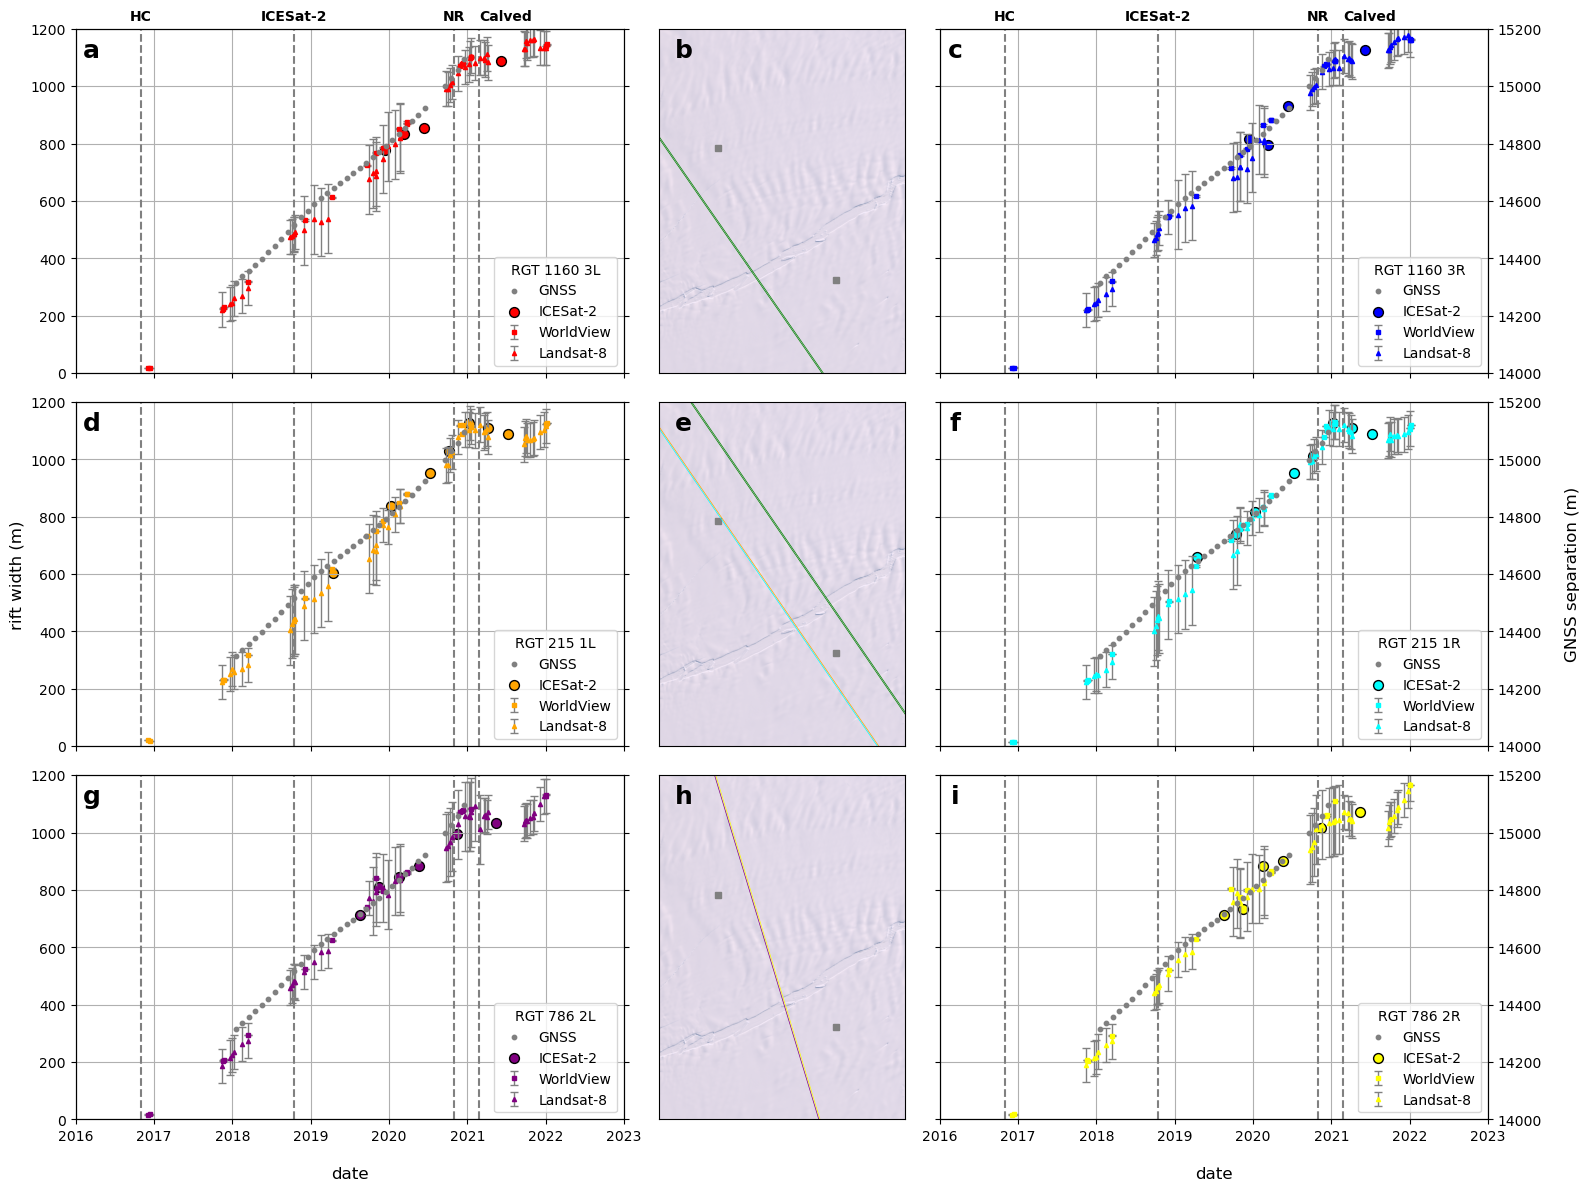

In [26]:
ftsz = 10

fig = plt.figure(figsize=(16, 12))

gs = gridspec.GridSpec(3, 5)

#------------------------------
# top left 1160 3L
ax1 = plt.subplot(gs[0:1,0:2])
ax12 = ax1.twinx()

pl_gps = ax12.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="GNSS")
ax1.scatter(decdate_1160_3l[0:3],halloween_obs_merged_1160_3l["actual-non-iceberg-width"][0:3],s=50,c='r',edgecolor='k',label="ICESat-2")
pl_is2 = ax1.scatter(decdate_1160_3l[4:5],halloween_obs_merged_1160_3l["actual-non-iceberg-width"][4:5],s=50,c='r',edgecolor='k',label="ICESat-2")
pl_wv  = ax1.errorbar(satellite_obs_1160_WV_3l["decimal_date"],satellite_obs_1160_WV_3l["actual-non-iceberg-width"]\
            ,yerr=wv_1160_3l_err,fmt='s',markersize=3,color='r',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax1.errorbar(satellite_obs_1160_L8_3l["decimal_date"],satellite_obs_1160_L8_3l["actual-non-iceberg-width"]\
            ,yerr=l8_1160_3l_err,fmt='^',markersize=3,color='r',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax1.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 1160 3L", loc= 'lower right', fontsize=ftsz)

ax1.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax1.text(HC_found,1230,'HC',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax1.text(IS_start,1230,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax1.text(NR_found,1230,'NR',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')
ax1.text(NR_calve,1230,'Calved',fontsize=ftsz,weight='bold',ha='left')


ax1.set_xlim(2016,2023)
ax1.set_ylim(0,1200)
ax12.set_yticks([14000,14200,14400,14600,14800,15000,15200])
ax12.set_ylim(14000,15200)
ax1.grid()

ax1.axes.xaxis.set_ticklabels([])
ax12.axes.yaxis.set_ticklabels([])

ax1.annotate("a",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# top right 1160 3R
ax2=plt.subplot(gs[0:1,3:5])
ax22 = ax2.twinx()

pl_gps = ax22.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax2.scatter(decdate_1160_3r[1:5],halloween_obs_merged_1160_3r["actual-non-iceberg-width"][1:5],s=50,c='b',edgecolor='k',label="ICESat-2")
pl_wv  = ax2.errorbar(satellite_obs_1160_WV_3r["decimal_date"],satellite_obs_1160_WV_3r["actual-non-iceberg-width"]\
            ,yerr=wv_1160_3r_err,fmt='s',markersize=3,color='b',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax2.errorbar(satellite_obs_1160_L8_3r["decimal_date"],satellite_obs_1160_L8_3r["actual-non-iceberg-width"]\
            ,yerr=l8_1160_3r_err,fmt='^',markersize=3,color='b',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax2.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 1160 3R", loc= 'lower right', fontsize=ftsz)

ax2.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax2.text(HC_found,1230,'HC',fontsize=ftsz,weight='bold',ha='center')
ax2.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax2.text(IS_start,1230,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax2.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax2.text(NR_found,1230,'NR',fontsize=ftsz,weight='bold',ha='center')
ax2.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')
ax2.text(NR_calve,1230,'Calved',fontsize=ftsz,weight='bold',ha='left')

ax2.set_xlim(2016,2023)
ax2.set_ylim(0,1200)
ax22.set_yticks([14000,14200,14400,14600,14800,15000,15200])
ax22.set_ylim(14000,15200)
ax2.grid()

ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])

ax2.annotate("c",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# middle left 215 1L
ax3=plt.subplot(gs[1:2,0:2])
ax32 = ax3.twinx()

pl_gps = ax32.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="GNSS")
ax3.scatter(decdate_215_1l[0:1],halloween_obs_merged_215_1l["actual-non-iceberg-width"][0:1],s=50,c='orange',edgecolor='k')
pl_is2 = ax3.scatter(decdate_215_1l[3:9],halloween_obs_merged_215_1l["actual-non-iceberg-width"][3:9],s=50,c='orange',edgecolor='k',label="ICESat-2")
pl_wv  = ax3.errorbar(satellite_obs_215_WV_1l["decimal_date"],satellite_obs_215_WV_1l["actual-non-iceberg-width"]\
            ,yerr=wv_215_1l_err,fmt='s',markersize=3,color='orange',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax3.errorbar(satellite_obs_215_L8_1l["decimal_date"],satellite_obs_215_L8_1l["actual-non-iceberg-width"]\
            ,yerr=l8_215_1l_err,fmt='^',markersize=3,color='orange',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax3.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 215 1L", loc= 'lower right', fontsize=ftsz)

ax3.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax3.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax3.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax3.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax3.set_xlim(2016,2023)
ax3.set_ylim(0,1200)
ax32.set_yticks([14000,14200,14400,14600,14800,15000,15200])
ax32.set_ylim(14000,15200)
ax3.grid()

ax3.axes.xaxis.set_ticklabels([])
ax32.axes.yaxis.set_ticklabels([])

ax3.annotate("d",(2016.2,1125),size=18,weight='bold',ha='center',va='center')


#------------------------------
# middle right 215 1R
ax4=plt.subplot(gs[1:2,3:5])
ax42 = ax4.twinx()

pl_gps = ax42.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="GNSS")
ax4.scatter(decdate_215_1r[0:1],halloween_obs_merged_215_1r["actual-non-iceberg-width"][0:1],s=50,c='cyan',edgecolor='k')
pl_is2 = ax4.scatter(decdate_215_1r[2:9],halloween_obs_merged_215_1r["actual-non-iceberg-width"][2:9],s=50,c='cyan',edgecolor='k',label="ICESat-2")
pl_wv  = ax4.errorbar(satellite_obs_215_WV_1r["decimal_date"],satellite_obs_215_WV_1r["actual-non-iceberg-width"]\
            ,yerr=wv_215_1r_err,fmt='s',markersize=3,color='cyan',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax4.errorbar(satellite_obs_215_L8_1r["decimal_date"],satellite_obs_215_L8_1r["actual-non-iceberg-width"]\
            ,yerr=l8_215_1r_err,fmt='^',markersize=3,color='cyan',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax4.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 215 1R", loc= 'lower right', fontsize=ftsz)

ax4.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax4.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax4.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax4.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax4.set_xlim(2016,2023)
ax4.set_ylim(0,1200)
ax42.set_yticks([14000,14200,14400,14600,14800,15000,15200])
ax42.set_ylim(14000,15200)
ax4.grid()

ax4.axes.xaxis.set_ticklabels([])
ax4.axes.yaxis.set_ticklabels([])

ax4.annotate("f",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# bottom left 786 2L
ax5=plt.subplot(gs[2:3,0:2])
ax52 = ax5.twinx()

pl_gps = ax52.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax5.scatter(decdate_786_2l[2:8],halloween_obs_merged_786_2l["actual-non-iceberg-width"][2:8],s=50,c='purple',edgecolor='k',label="ICESat-2")
pl_wv  = ax5.errorbar(satellite_obs_786_WV_2l["decimal_date"],satellite_obs_786_WV_2l["actual-non-iceberg-width"]\
            ,yerr=wv_786_2l_err,fmt='s',markersize=3,color='purple',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax5.errorbar(satellite_obs_786_L8_2l["decimal_date"],satellite_obs_786_L8_2l["actual-non-iceberg-width"]\
            ,yerr=l8_786_2l_err,fmt='^',markersize=3,color='purple',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax5.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 786 2L", loc= 'lower right', fontsize=ftsz)

ax5.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax5.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax5.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax5.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax5.set_xlim(2016,2023)
ax5.set_ylim(0,1200)
ax52.set_yticks([14000,14200,14400,14600,14800,15000,15200])
ax52.set_ylim(14000,15200)
ax5.grid()

ax52.axes.yaxis.set_ticklabels([])

ax5.annotate("g",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# bottom right 786 2R
ax6=plt.subplot(gs[2:3,3:5])
ax62 = ax6.twinx()

pl_gps = ax62.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax6.scatter(decdate_786_2r[2:8],halloween_obs_merged_786_2r["actual-non-iceberg-width"][2:8],s=50,c='yellow',edgecolor='k',label="ICESat-2")
pl_wv  = ax6.errorbar(satellite_obs_786_WV_2r["decimal_date"],satellite_obs_786_WV_2r["actual-non-iceberg-width"]\
            ,yerr=wv_786_2r_err,fmt='s',markersize=3,color='yellow',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax6.errorbar(satellite_obs_786_L8_2r["decimal_date"],satellite_obs_786_L8_2r["actual-non-iceberg-width"]\
            ,yerr=l8_786_2r_err,fmt='^',markersize=3,color='yellow',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax6.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 786 2R", loc= 'lower right', fontsize=ftsz)

ax6.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax6.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax6.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax6.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax6.set_xlim(2016,2023)
ax6.set_ylim(0,1200)
ax62.set_yticks([14000,14200,14400,14600,14800,15000,15200])
ax62.set_ylim(14000,15200)
ax6.grid()

ax6.axes.yaxis.set_ticklabels([])

ax6.annotate("i",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# images 1060

xmininsw = -700000
xmaxinsw = -680000
ymininsw = 1420000 
ymaxinsw = 1448000

ax101 = plt.subplot(gs[0:1,2:3])

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax101)

ax101.plot(hh00_x[0],hh00_y[0],'s',color='gray',markersize=5)
ax101.plot(tt05_x[1],tt05_y[1],'s',color='gray',markersize=5)

#1160
#1L
easting = shapefile1L_ar["easting"][190]
northing = shapefile1L_ar["northing"][190]
ax101.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][190]
northing = shapefile1R_ar["northing"][190]
ax101.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][191]
northing = shapefile2L_ar["northing"][191]
ax101.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][192]
northing = shapefile2R_ar["northing"][192]
ax101.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][176]
northing = shapefile3L_ar["northing"][176]
ax101.plot(easting,northing,'r',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][176]
northing = shapefile3R_ar["northing"][176]
ax101.plot(easting,northing,'b',linewidth=0.5)

#annotate
#ax[0][1].text(-699400, 1441250, '1160 3', rotation=-55, fontsize=6, color='g')
#ax[0][1].text(-699400, 1435500, '1160 2', rotation=-55, fontsize=6, color='g')
#ax[0][1].text(-699400, 1429550, '1160 1', rotation=-55, fontsize=6, color='g')

ax101.set_xlim(xmininsw,xmaxinsw)
ax101.set_ylim(ymininsw,ymaxinsw)
ax101.axes.xaxis.set_ticks([])
ax101.axes.yaxis.set_ticks([])
ax101.axes.xaxis.set_ticklabels([])
ax101.axes.yaxis.set_ticklabels([])

ax101.annotate("b",(-698000,1446250),size=18,weight='bold',ha='center',va='center')

#------------------------------
# images 215

ax102 = plt.subplot(gs[1:2,2:3])

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax102)

ax102.plot(hh00_x[0],hh00_y[0],'s',color='gray',markersize=5)
ax102.plot(tt05_x[1],tt05_y[1],'s',color='gray',markersize=5)

#215
#1L
easting = shapefile1L_ar["easting"][34]
northing = shapefile1L_ar["northing"][34]
ax102.plot(easting,northing,'orange',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][34]
northing = shapefile1R_ar["northing"][34]
ax102.plot(easting,northing,'cyan',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][34]
northing = shapefile2L_ar["northing"][34]
ax102.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][34]
northing = shapefile2R_ar["northing"][34]
ax102.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][32]
northing = shapefile3L_ar["northing"][32]
ax102.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][32]
northing = shapefile3R_ar["northing"][32]
ax102.plot(easting,northing,'g',linewidth=0.5)

#annotate
#ax102.text(-699400, 1444000, '215 1  ', rotation=-55, fontsize=6, color='g')
#ax102.text(-696600, 1445800, '215 2  ', rotation=-55, fontsize=6, color='g')
#ax102.text(-692600, 1445800, '215 3  ', rotation=-55, fontsize=6, color='g')

ax102.set_xlim(xmininsw,xmaxinsw)
ax102.set_ylim(ymininsw,ymaxinsw)
ax102.axes.xaxis.set_ticks([])
ax102.axes.yaxis.set_ticks([])
ax102.axes.xaxis.set_ticklabels([])
ax102.axes.yaxis.set_ticklabels([])

ax102.annotate("e",(-698000,1446250),size=18,weight='bold',ha='center',va='center')

#------------------------------
# images 725

ax103 = plt.subplot(gs[2:3,2:3])

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax103)

ax103.plot(hh00_x[0],hh00_y[0],'s',color='gray',markersize=5)
ax103.plot(tt05_x[1],tt05_y[1],'s',color='gray',markersize=5)

#786
#1L
easting = shapefile1L_ar["easting"][129]
northing = shapefile1L_ar["northing"][129]
ax103.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][129]
northing = shapefile1R_ar["northing"][129]
ax103.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][129]
northing = shapefile2L_ar["northing"][129]
ax103.plot(easting,northing,'purple',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][130]
northing = shapefile2R_ar["northing"][130]
ax103.plot(easting,northing,'yellow',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][119]
northing = shapefile3L_ar["northing"][119]
ax103.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][119]
northing = shapefile3R_ar["northing"][119]
ax103.plot(easting,northing,'g',linewidth=0.5)

#annotate
#ax103.text(-698500, 1445800, '786 3  ', rotation=-72, fontsize=6, color='g')
#ax103.text(-695000, 1445800, '786 2  ', rotation=-72, fontsize=6, color='g')
#ax103.text(-691600, 1445800, '786 1  ', rotation=-72, fontsize=6, color='g')

ax103.set_xlim(xmininsw,xmaxinsw)
ax103.set_ylim(ymininsw,ymaxinsw)
ax103.axes.xaxis.set_ticks([])
ax103.axes.yaxis.set_ticks([])
ax103.axes.xaxis.set_ticklabels([])
ax103.axes.yaxis.set_ticklabels([])

ax103.annotate("h",(-698000,1446250),size=18,weight='bold',ha='center',va='center')

#------------------------------
# labels

ax5.set_xlabel("\ndate", fontsize=ftsz+2)
ax6.set_xlabel("\ndate", fontsize=ftsz+2)
ax3.set_ylabel("rift width (m)", fontsize=ftsz+2)
ax42.set_ylabel("\nGNSS separation (m)", fontsize=ftsz+2)

plt.tight_layout()

output = figure_folder+'/fig04_western_map_graph.png'
plt.savefig(output, dpi=100, bbox_inches='tight')

plt.show()


## Figure 4 along 283 1LR, 725 3LR, 1099 2LR
Graph of comparison between GPS, ICESat-2, Landsat-8, WorldView

### subset detections

In [27]:
halloween_obs_merged_283_1l = halloween_obs_merged[(halloween_obs_merged["rgt"]==283) & (halloween_obs_merged["beam"]=='1l')]
halloween_obs_merged_283_1r = halloween_obs_merged[(halloween_obs_merged["rgt"]==283) & (halloween_obs_merged["beam"]=='1r')]

halloween_obs_merged_283_1l = gpd.GeoDataFrame(
    halloween_obs_merged_283_1l, geometry=gpd.points_from_xy(halloween_obs_merged_283_1l['x-centroid'], halloween_obs_merged_283_1l['y-centroid']))
halloween_obs_merged_283_1r = gpd.GeoDataFrame(
    halloween_obs_merged_283_1r, geometry=gpd.points_from_xy(halloween_obs_merged_283_1r['x-centroid'], halloween_obs_merged_283_1r['y-centroid']))
    
#display(halloween_obs_merged_283_1l)
#display(halloween_obs_merged_283_1r)

halloween_obs_merged_725_3l = halloween_obs_merged[(halloween_obs_merged["rgt"]==725) & (halloween_obs_merged["beam"]=='3l')]
halloween_obs_merged_725_3r = halloween_obs_merged[(halloween_obs_merged["rgt"]==725) & (halloween_obs_merged["beam"]=='3r')]

halloween_obs_merged_725_3l = gpd.GeoDataFrame(
    halloween_obs_merged_725_3l, geometry=gpd.points_from_xy(halloween_obs_merged_725_3l['x-centroid'], halloween_obs_merged_725_3l['y-centroid']))
halloween_obs_merged_725_3r = gpd.GeoDataFrame(
    halloween_obs_merged_725_3r, geometry=gpd.points_from_xy(halloween_obs_merged_725_3r['x-centroid'], halloween_obs_merged_725_3r['y-centroid']))

#display(halloween_obs_merged_725_3l)
#display(halloween_obs_merged_725_3r)

halloween_obs_merged_1099_2l = halloween_obs_merged[(halloween_obs_merged["rgt"]==1099) & (halloween_obs_merged["beam"]=='2l')]
halloween_obs_merged_1099_2r = halloween_obs_merged[(halloween_obs_merged["rgt"]==1099) & (halloween_obs_merged["beam"]=='2r')]

halloween_obs_merged_1099_2l = gpd.GeoDataFrame(
    halloween_obs_merged_1099_2l, geometry=gpd.points_from_xy(halloween_obs_merged_1099_2l['x-centroid'], halloween_obs_merged_1099_2l['y-centroid']))
halloween_obs_merged_1099_2r = gpd.GeoDataFrame(
    halloween_obs_merged_1099_2r, geometry=gpd.points_from_xy(halloween_obs_merged_1099_2r['x-centroid'], halloween_obs_merged_1099_2r['y-centroid']))
    
#display(halloween_obs_merged_1099_2l)
#display(halloween_obs_merged_1099_2r)


### rotate to rift coordinates

In [28]:
azimuth_283_1l = []

for index, row in halloween_obs_merged_283_1l.iterrows():
    azimuth_283_1l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_283_1l = np.abs(np.sin(np.deg2rad(azimuth_283_1l - halloween_obs_merged_283_1l['azimuth']))) * halloween_obs_merged_283_1l['width']
actual_non_iceberg_width_283_1l = np.abs(np.sin(np.deg2rad(azimuth_283_1l - halloween_obs_merged_283_1l['azimuth']))) * halloween_obs_merged_283_1l['non-iceberg-width']

azimuth_283_1r = []

for index, row in halloween_obs_merged_283_1r.iterrows():    
    azimuth_283_1r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_283_1r = np.abs(np.sin(np.deg2rad(azimuth_283_1r - halloween_obs_merged_283_1r['azimuth']))) * halloween_obs_merged_283_1r['width']
actual_non_iceberg_width_283_1r = np.abs(np.sin(np.deg2rad(azimuth_283_1r - halloween_obs_merged_283_1r['azimuth']))) * halloween_obs_merged_283_1r['non-iceberg-width']

azimuth_725_3l = []

for index, row in halloween_obs_merged_725_3l.iterrows():
    azimuth_725_3l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_725_3l = np.abs(np.sin(np.deg2rad(azimuth_725_3l - halloween_obs_merged_725_3l['azimuth']))) * halloween_obs_merged_725_3l['width']
actual_non_iceberg_width_725_3l = np.abs(np.sin(np.deg2rad(azimuth_725_3l - halloween_obs_merged_725_3l['azimuth']))) * halloween_obs_merged_725_3l['non-iceberg-width']

azimuth_725_3r = []

for index, row in halloween_obs_merged_725_3r.iterrows():    
    azimuth_725_3r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_725_3r = np.abs(np.sin(np.deg2rad(azimuth_725_3r - halloween_obs_merged_725_3r['azimuth']))) * halloween_obs_merged_725_3r['width']
actual_non_iceberg_width_725_3r = np.abs(np.sin(np.deg2rad(azimuth_725_3r - halloween_obs_merged_725_3r['azimuth']))) * halloween_obs_merged_725_3r['non-iceberg-width']

azimuth_1099_2l = []

for index, row in halloween_obs_merged_1099_2l.iterrows():
    azimuth_1099_2l.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1099_2l = np.abs(np.sin(np.deg2rad(azimuth_1099_2l - halloween_obs_merged_1099_2l['azimuth']))) * halloween_obs_merged_1099_2l['width']
actual_non_iceberg_width_1099_2l = np.abs(np.sin(np.deg2rad(azimuth_1099_2l - halloween_obs_merged_1099_2l['azimuth']))) * halloween_obs_merged_1099_2l['non-iceberg-width']

azimuth_1099_2r = []

for index, row in halloween_obs_merged_1099_2r.iterrows():    
    azimuth_1099_2r.append(estimate_local_rift_orientation_new(row['geometry'],riftx,rifty))
actual_width_1099_2r = np.abs(np.sin(np.deg2rad(azimuth_1099_2r - halloween_obs_merged_1099_2r['azimuth']))) * halloween_obs_merged_1099_2r['width']
actual_non_iceberg_width_1099_2r = np.abs(np.sin(np.deg2rad(azimuth_1099_2r - halloween_obs_merged_1099_2r['azimuth']))) * halloween_obs_merged_1099_2r['non-iceberg-width']


halloween_obs_merged_283_1l['rift-angle'] = pd.Series(np.array(azimuth_283_1l), index=halloween_obs_merged_283_1l.index)
halloween_obs_merged_283_1r['rift-angle'] = pd.Series(np.array(azimuth_283_1r), index=halloween_obs_merged_283_1r.index)
halloween_obs_merged_283_1l["actual-width"] = pd.Series(np.array(actual_width_283_1l), index=halloween_obs_merged_283_1l.index)
halloween_obs_merged_283_1r["actual-width"] = pd.Series(np.array(actual_width_283_1r), index=halloween_obs_merged_283_1r.index)
halloween_obs_merged_283_1l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_283_1l), index=halloween_obs_merged_283_1l.index)
halloween_obs_merged_283_1r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_283_1r), index=halloween_obs_merged_283_1r.index)

#display(halloween_obs_merged_283_1l)
#display(halloween_obs_merged_283_1r)

halloween_obs_merged_725_3l['rift-angle'] = pd.Series(np.array(azimuth_725_3l), index=halloween_obs_merged_725_3l.index)
halloween_obs_merged_725_3r['rift-angle'] = pd.Series(np.array(azimuth_725_3r), index=halloween_obs_merged_725_3r.index)
halloween_obs_merged_725_3l["actual-width"] = pd.Series(np.array(actual_width_725_3l), index=halloween_obs_merged_725_3l.index)
halloween_obs_merged_725_3r["actual-width"] = pd.Series(np.array(actual_width_725_3r), index=halloween_obs_merged_725_3r.index)
halloween_obs_merged_725_3l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_725_3l), index=halloween_obs_merged_725_3l.index)
halloween_obs_merged_725_3r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_725_3r), index=halloween_obs_merged_725_3r.index)

#display(halloween_obs_merged_725_3l)
#display(halloween_obs_merged_725_3r)

halloween_obs_merged_1099_2l['rift-angle'] = pd.Series(np.array(azimuth_1099_2l), index=halloween_obs_merged_1099_2l.index)
halloween_obs_merged_1099_2r['rift-angle'] = pd.Series(np.array(azimuth_1099_2r), index=halloween_obs_merged_1099_2r.index)
halloween_obs_merged_1099_2l["actual-width"] = pd.Series(np.array(actual_width_1099_2l), index=halloween_obs_merged_1099_2l.index)
halloween_obs_merged_1099_2r["actual-width"] = pd.Series(np.array(actual_width_1099_2r), index=halloween_obs_merged_1099_2r.index)
halloween_obs_merged_1099_2l["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1099_2l), index=halloween_obs_merged_1099_2l.index)
halloween_obs_merged_1099_2r["actual-non-iceberg-width"] = pd.Series(np.array(actual_non_iceberg_width_1099_2r), index=halloween_obs_merged_1099_2r.index)

#display(halloween_obs_merged_1099_2l)
#display(halloween_obs_merged_1099_2r)


### calculate decimal times

In [29]:
num_283_1l = [1,217,268,356,406]
num_283_1r = [4,220,271,357,409]

num_725_3l = [19,90,331,366]
num_725_3r = [22,93,334,369]

num_1099_2l = [54,152,194,290]
num_1099_2r = [57,155,197,293]

time_283_1l = halloween_obs_merged_283_1l["time"]
time_283_1r = halloween_obs_merged_283_1r["time"]

year_283_1l = []
month_283_1l = []
day_283_1l = []
year_283_1r = []
month_283_1r = []
day_283_1r = []

time_725_3l = halloween_obs_merged_725_3l["time"]
time_725_3r = halloween_obs_merged_725_3r["time"]

year_725_3l = []
month_725_3l = []
day_725_3l = []
year_725_3r = []
month_725_3r = []
day_725_3r = []

time_1099_2l = halloween_obs_merged_1099_2l["time"]
time_1099_2r = halloween_obs_merged_1099_2r["time"]

year_1099_2l = []
month_1099_2l = []
day_1099_2l = []
year_1099_2r = []
month_1099_2r = []
day_1099_2r = []


for tl in range(0,len(time_283_1l)):
    year_283_1l.append(int(str(time_283_1l[num_283_1l[tl]].date())[0:4]))
    month_283_1l.append(int(str(time_283_1l[num_283_1l[tl]].date())[5:7]))
    day_283_1l.append(int(str(time_283_1l[num_283_1l[tl]].date())[8:10]))

for tr in range(0,len(time_283_1r)):
    year_283_1r.append(int(str(time_283_1r[num_283_1r[tr]].date())[0:4]))
    month_283_1r.append(int(str(time_283_1r[num_283_1r[tr]].date())[5:7]))
    day_283_1r.append(int(str(time_283_1r[num_283_1r[tr]].date())[8:10]))

decdate_283_1l = np.array(year_283_1l) + ((np.array(month_283_1l)-1) / 12) + ((np.array(day_283_1l)-1) / 365)
decdate_283_1r = np.array(year_283_1r) + ((np.array(month_283_1r)-1) / 12) + ((np.array(day_283_1r)-1) / 365)

for tl2 in range(0,len(time_725_3l)):
    year_725_3l.append(int(str(time_725_3l[num_725_3l[tl2]].date())[0:4]))
    month_725_3l.append(int(str(time_725_3l[num_725_3l[tl2]].date())[5:7]))
    day_725_3l.append(int(str(time_725_3l[num_725_3l[tl2]].date())[8:10]))

for tr2 in range(0,len(time_725_3r)):
    year_725_3r.append(int(str(time_725_3r[num_725_3r[tr2]].date())[0:4]))
    month_725_3r.append(int(str(time_725_3r[num_725_3r[tr2]].date())[5:7]))
    day_725_3r.append(int(str(time_725_3r[num_725_3r[tr2]].date())[8:10]))

decdate_725_3l = np.array(year_725_3l) + ((np.array(month_725_3l)-1) / 12) + ((np.array(day_725_3l)-1) / 365)
decdate_725_3r = np.array(year_725_3r) + ((np.array(month_725_3r)-1) / 12) + ((np.array(day_725_3r)-1) / 365)

for tl in range(0,len(time_1099_2l)):
    year_1099_2l.append(int(str(time_1099_2l[num_1099_2l[tl]].date())[0:4]))
    month_1099_2l.append(int(str(time_1099_2l[num_1099_2l[tl]].date())[5:7]))
    day_1099_2l.append(int(str(time_1099_2l[num_1099_2l[tl]].date())[8:10]))

for tr in range(0,len(time_1099_2r)):
    year_1099_2r.append(int(str(time_1099_2r[num_1099_2r[tr]].date())[0:4]))
    month_1099_2r.append(int(str(time_1099_2r[num_1099_2r[tr]].date())[5:7]))
    day_1099_2r.append(int(str(time_1099_2r[num_1099_2r[tr]].date())[8:10]))

decdate_1099_2l = np.array(year_1099_2l) + ((np.array(month_1099_2l)-1) / 12) + ((np.array(day_1099_2l)-1) / 365)
decdate_1099_2r = np.array(year_1099_2r) + ((np.array(month_1099_2r)-1) / 12) + ((np.array(day_1099_2r)-1) / 365)



### satellite measurements

In [30]:
# from satellite imagery
# year, month, day, width, estimated azimuth
# DigitalGlobe_283_1l

satellite_obs_283 = {
    "platform": ["WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "WV","WV","WV","WV"],
    "rgt": [283,283,283,283,283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,\
            283,283,283,283,283,283,283,283,283,\
            283,283,283,283],
    "laser": ["1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1l","1l","1l","1l","1l","1l","1l","1l","1l",\
              "1r","1r","1r","1r","1r","1r","1r","1r","1r",\
              "1l","1r","1l","1r"],
    "year": [2017,2017,2017,2019,2019,2019,2019,2019,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2019,2019,2019,2019,2019,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,\
             2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,\
             2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,\
             2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,\
             2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2022,2022,2022,2022],
    "month": [4,11,11,1,4,9,11,12,3,3,10,11,1,9,\
              4,11,11,1,4,9,11,12,3,3,10,11,1,9,\
              11,12,12,1,2,3,9,10,10,10,10,11,\
              1,2,3,10,10,10,11,12,12,1,2,2,\
              9,10,10,10,11,12,1,2,9,10,10,11,11,12,12,\
              11,12,12,1,2,3,9,10,10,10,10,11,\
              1,2,3,10,10,10,11,12,12,1,2,2,\
              9,10,10,10,11,12,1,2,9,10,10,11,11,12,12,\
              1,1,3,3,4,4,9,10,12,\
              1,1,3,3,4,4,9,10,12,\
              1,1,2,2],
    "day": [2,17,21,8,12,17,2,12,18,22,30,29,19,7,\
            2,17,21,8,12,17,2,12,18,22,30,29,19,7,\
            12,21,30,8,14,11,28,5,12,14,21,29,\
            18,19,23,1,17,31,2,2,27,28,20,22,24,\
            1,10,19,18,22,7,6,20,6,20,5,7,5,25,\
            12,21,30,8,14,11,28,5,12,14,21,29,\
            18,19,23,1,17,31,2,2,27,28,20,22,24,\
            1,10,19,18,22,7,6,20,6,20,5,7,5,25,\
            12,19,17,24,2,4,25,2,31,\
            12,19,17,24,2,4,25,2,31,\
            7,7,15,15],
    "centroid_lon": [
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,\
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,\
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,\
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,\
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,\
        -25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,-25.1039,\
        -25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,-25.1006,\
        -25.1039,-25.1006,-25.1039,-25.1006],
    "centroid_lat": [
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,\
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,\
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,\
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,\
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,\
        -75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,-75.4385,\
        -75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,-75.4386,\
        -75.4385,-75.4386,-75.4385,-75.4386],
    "total_width": [43.5,142.6,139.5,412.3,489.1,460.9,467.8,489.2,534.8,539.3,620.6,631.9,652.4,682.8,\
                   41.7,148.2,154.2,429.8,466.6,448.3,474.2,482.6,561.3,560.5,619.5,624.9,707.2,694.0,\
                   123,172,171,174,207,193,272,288,305,303,316,335,\
                   414,485,465,452,459,438,472,479,478,\
                   490,506,513,586,597,604,605,621,633,\
                   641,653,693,682,673,685,670,693,694,\
                   138,166,175,193,189,203,279,289,318,313,331,332,\
                   443,475,481,439,452,444,464,481,481,\
                   510,507,527,565,574,585,592,569,651,\
                   667,714,643,671,682,689,686,678,668,\
                   635,640,761,770,760,760,679,687,697,\
                   684,674,775,801,793,795,657,663,652,\
                   691.7,668.5,677.2,682.9],
    "non-iceberg_width": [43.5,142.6,139.5,412.3,489.1,460.9,467.8,489.2,534.8,539.3,620.6,631.9,652.4,682.8,\
                   41.7,148.2,154.2,429.8,466.6,448.3,474.2,482.6,561.3,560.5,619.5,624.9,707.2,694.0,\
                   123,172,171,174,207,193,272,288,305,303,316,335,\
                   414,485,465,452,459,438,472,479,478,\
                   490,506,513,586,597,604,605,621,633,\
                   641,653,693,682,673,685,670,693,694,\
                   138,166,175,193,189,203,279,289,318,313,331,332,\
                   443,475,481,439,452,444,464,481,481,\
                   510,507,527,565,574,585,592,569,651,\
                   667,714,643,671,682,689,686,678,668,\
                   635,640,761,770,760,760,679,687,697,\
                   684,674,775,801,793,795,657,663,652,\
                   691.7,668.5,677.2,682.9], 
    "comment": ["-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-"],
    "azimuth": [-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1]
}

satellite_obs_283 = pd.DataFrame(satellite_obs_283)

# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_283.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_283["decimal_date"] = decimal_date
satellite_obs_283["x-centroid"] = Ecentroid
satellite_obs_283["y-centroid"] = Ncentroid

satellite_obs_283 = gpd.GeoDataFrame(satellite_obs_283, geometry=gpd.points_from_xy(satellite_obs_283["x-centroid"],satellite_obs_283["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_283.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_283['azimuth']))) * satellite_obs_283['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_283['azimuth']))) * satellite_obs_283['non-iceberg_width']

satellite_obs_283['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_283.index)
satellite_obs_283['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_283.index)
satellite_obs_283['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_283.index)

satellite_obs_283_WV_1l = satellite_obs_283[(satellite_obs_283["platform"]=="WV") & (satellite_obs_283["laser"]=="1l")]
satellite_obs_283_WV_1r = satellite_obs_283[(satellite_obs_283["platform"]=="WV") & (satellite_obs_283["laser"]=="1r")]
satellite_obs_283_L8_1l = satellite_obs_283[(satellite_obs_283["platform"]=="L8") & (satellite_obs_283["laser"]=="1l")]
satellite_obs_283_L8_1r = satellite_obs_283[(satellite_obs_283["platform"]=="L8") & (satellite_obs_283["laser"]=="1r")]

#display(satellite_obs_283)
#display(satellite_obs_283_WV_1l)
#display(satellite_obs_283_WV_1r)
#display(satellite_obs_283_L8_1l)
#display(satellite_obs_283_L8_1r)


In [31]:
# from satellite imagery
# year, month, day, width, estimated azimuth
# DigitalGlobe_725_3l

satellite_obs_725 = {
    "platform": ["WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "WV","WV","WV","WV","WV","WV"],
    "rgt": [725,725,725,725,725,725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725,725,725,725,\
            725,725,725,725,725,725],
    "laser": ["3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3l","3l","3l","3l","3l","3l","3l","3l","3l",\
              "3r","3r","3r","3r","3r","3r","3r","3r","3r",\
              "3l","3r","3l","3r","3l","3r"],
    "year": [2017,2017,2017,2019,2019,2019,2019,2019,2020,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2019,2019,2019,2019,2020,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,\
             2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,\
             2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,\
             2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,\
             2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2022,2022,2022,2022],
    "month": [4,11,11,1,4,9,11,12,3,3,3,10,11,1,9,\
              4,11,11,1,4,9,12,3,3,3,10,11,1,9,\
              11,12,12,1,2,3,9,10,10,10,10,11,\
              1,2,3,10,10,10,11,12,12,1,2,2,\
              9,10,10,10,11,12,1,2,9,10,10,11,11,12,12,\
              11,12,12,1,2,3,9,10,10,10,10,11,\
              1,2,3,10,10,10,11,12,12,1,2,2,\
              9,10,10,10,11,12,1,2,9,10,10,11,11,12,12,\
              1,1,3,3,4,4,9,10,12,\
              1,1,3,3,4,4,9,10,12,\
              12,12,1,1,2,2],
    "day": [2,17,21,8,12,17,2,12,18,22,25,30,29,19,7,\
            2,17,21,8,12,17,12,18,22,25,30,29,19,7,\
            12,21,30,8,14,11,28,5,12,14,21,29,\
            18,19,23,1,17,31,2,2,27,28,20,22,24,\
            1,10,19,18,22,7,6,20,6,20,5,7,5,25,\
            12,21,30,8,14,11,28,5,12,14,21,29,\
            18,19,23,1,17,31,2,2,27,28,20,22,24,\
            1,10,19,18,22,7,6,20,6,20,5,7,5,25,\
            12,19,17,24,2,4,25,2,31,\
            12,19,17,24,2,4,25,2,31,\
            5,5,7,7,15,15],    
    "centroid_lon": [-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,\
        -25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,\
        -25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,\
        -25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,\
        -25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,\
        -25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,-25.0871,\
        -25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,-25.0836,\
        -25.0871,-25.0836,-25.0871,-25.0836,-25.0871,-25.0836],
    "centroid_lat": [-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,\
        -75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,\
        -75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,\
        -75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,\
        -75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,\
        -75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,-75.4381,\
        -75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,-75.4379,\
        -75.4381,-75.4379,-75.4381,-75.4379,-75.4381,-75.4379],
    "total_width": [36.3,198.0,191.1,363.3,385.9,450.5,511.4,519.2,\
                    545.7,531.7,535.5,780.0,790.9,810.0,640.3,\
                    39.3,155.8,155.9,356.5,400.7,482.5,526.3,\
                    523.0,512.8,513.5,774.6,788.9,777.4,647.7,\
                    164,181,179,174,189,185,392,380,359,370,361,372,\
                    351,367,367,456,472,457,488,502,516,\
                    506,508,501,691,723,727,770,774,799,\
                    780,802,616,635,650,640,647,668,666,\
                    131,151,162,153,171,178,310,324,337,340,344,341,\
                    341,370,362,488,491,471,495,509,491,\
                    496,482,492,730,747,782,780,791,786,\
                    800,794,614,637,637,645,657,662,672,\
                    807,796,694,694,659,645,624,640,676,\
                    724,756,664,647,631,629,614,631,655,\
                    662.4,663.1,672.0,671.2,672.2,673.3],
    "non-iceberg_width": [36.3,198.0,191.1,363.3,385.9,450.5,511.4,519.2,\
                    545.7,531.7,535.5,780.0,790.9,810.0,640.3,\
                    39.3,155.8,155.9,356.5,400.7,482.5,526.3,\
                    523.0,512.8,513.5,774.6,788.9,777.4,647.7,\
                    164,181,179,174,189,185,392,380,359,370,361,372,\
                    351,367,367,456,472,457,488,502,516,\
                    506,508,501,691,723,727,770,774,799,\
                    780,802,616,635,650,640,647,668,666,\
                    131,151,162,153,171,178,310,324,337,340,344,341,\
                    341,370,362,488,491,471,495,509,491,\
                    496,482,492,730,747,782,780,791,786,\
                    800,794,614,637,637,645,657,662,672,\
                    807,796,694,694,659,645,624,640,676,\
                    724,756,664,647,631,629,614,631,655,\
                    662.4,663.1,672.0,671.2,672.2,673.3], 
    "comment": ["-","-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-"],
        "azimuth": [-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,-171.1,\
                -171.1,-171.1,-171.1,-171.1,-171.1,-171.1]
}

satellite_obs_725 = pd.DataFrame(satellite_obs_725)

# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_725.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_725["decimal_date"] = decimal_date
satellite_obs_725["x-centroid"] = Ecentroid
satellite_obs_725["y-centroid"] = Ncentroid

satellite_obs_725 = gpd.GeoDataFrame(satellite_obs_725, geometry=gpd.points_from_xy(satellite_obs_725["x-centroid"],satellite_obs_725["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_725.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_725['azimuth']))) * satellite_obs_725['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_725['azimuth']))) * satellite_obs_725['non-iceberg_width']

satellite_obs_725['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_725.index)
satellite_obs_725['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_725.index)
satellite_obs_725['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_725.index)

satellite_obs_725_WV_3l = satellite_obs_725[(satellite_obs_725["platform"]=="WV") & (satellite_obs_725["laser"]=="3l")]
satellite_obs_725_WV_3r = satellite_obs_725[(satellite_obs_725["platform"]=="WV") & (satellite_obs_725["laser"]=="3r")]
satellite_obs_725_L8_3l = satellite_obs_725[(satellite_obs_725["platform"]=="L8") & (satellite_obs_725["laser"]=="3l")]
satellite_obs_725_L8_3r = satellite_obs_725[(satellite_obs_725["platform"]=="L8") & (satellite_obs_725["laser"]=="3r")]

#display(satellite_obs_725)
#display(satellite_obs_725_WV_3l)
#display(satellite_obs_725_WV_3r)
#display(satellite_obs_725_L8_3l)
#display(satellite_obs_725_L8_3r)


In [32]:
# from satellite imagery
# year, month, day, width, estimated azimuth
# DigitalGlobe_1099_2l

satellite_obs_1099 = {
    "platform": ["WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV","WV",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "L8","L8","L8","L8","L8","L8","L8","L8","L8",\
                 "WV","WV","WV","WV"],
    "rgt": [1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099,1099,1099,1099,1099,1099,\
            1099,1099,1099,1099],
    "laser": ["2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2l","2l","2l","2l","2l","2l","2l","2l","2l",\
              "2r","2r","2r","2r","2r","2r","2r","2r","2r",\
              "2l","2r","2l","2r"],
    "year": [2017,2017,2017,2019,2019,2019,2019,2019,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2019,2019,2019,2019,2019,2020,2020,2020,2020,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,\
             2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,\
             2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,\
             2017,2017,2017,2018,2018,2018,2018,2018,2018,2018,2018,2018,\
             2019,2019,2019,2019,2019,2019,2019,2019,2019,2020,2020,2020,\
             2020,2020,2020,2020,2020,2020,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2021,2021,2021,2021,2021,2021,2021,2021,2021,\
             2022,2022,2022,2022],
    "month": [4,11,11,1,4,9,11,12,3,3,10,11,1,9,\
              4,11,11,1,4,9,11,12,3,3,10,11,1,9,\
              11,12,12,1,2,3,9,10,10,10,10,11,\
              1,2,3,10,10,10,11,12,12,1,2,2,\
              9,10,10,10,11,12,1,2,9,10,10,11,11,12,12,\
              11,12,12,1,2,3,9,10,10,10,10,11,\
              1,2,3,10,10,10,11,12,12,1,2,2,\
              9,10,10,10,11,12,1,2,9,10,10,11,11,12,12,\
              1,1,3,3,4,4,9,10,12,\
              1,1,3,3,4,4,9,10,12,\
              1,1,2,2],
    "day": [2,17,21,8,12,17,2,12,18,22,30,29,19,7,\
            2,17,21,8,12,17,2,12,18,22,30,29,19,7,\
            12,21,30,8,14,11,28,5,12,14,21,29,\
            18,19,23,1,17,31,2,2,27,28,20,22,24,\
            1,10,19,18,22,7,6,20,6,20,5,7,5,25,\
            12,21,30,8,14,11,28,5,12,14,21,29,\
            18,19,23,1,17,31,2,2,27,28,20,22,24,\
            1,10,19,18,22,7,6,20,6,20,5,7,5,25,\
            12,19,17,24,2,4,25,2,31,\
            12,19,17,24,2,4,25,2,31,\
            7,7,15,15],
    "centroid_lon": [
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,\
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,\
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,\
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,\
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,\
        -25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,-25.1061,\
        -25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,-25.1091,\
        -25.1061,-25.1091,-25.1061,-25.1091],
    "centroid_lat": [-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,\
        -75.4310,-75.4310,-75.4310,-75.4310,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,\
        -75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,\
        -75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,\
        -75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,\
        -75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,-75.4310,\
        -75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,-75.4315,\
        -75.4310,-75.4315,-75.4310,-75.4315],
    "total_width": [36.0,191.9,191.9,335.5,394.6,463.1,474.2,504.9,532.1,531.5,639.1,665.4,685.9,703.1,\
                    39.3,143.1,162.2,320.7,415.3,456.6,487.4,487.2,532.4,534.4,616.7,643.6,679.5,715.9,\
                    191,203,209,195,203,200,291,304,305,305,313,318,\
                    351,357,349,445,464,455,462,480,483,\
                    506,508,520,579,595,604,614,623,650,\
                    669,664,713,688,692,667,665,643,640,\
                    172,194,204,222,209,209,289,310,308,309,318,323,\
                    331,334,367,450,451,452,474,482,501,\
                    507,515,522,578,581,588,590,618,651,\
                    667,670,690,718,723,698,689,684,653,\
                    683,674,608,595,564,562,702,684,623,\
                    688,681,664,674,645,673,665,688,620,\
                    620.9,609.5,654.4,625.9],
    "non-iceberg_width": [36.0,191.9,191.9,335.5,394.6,463.1,474.2,504.9,532.1,531.5,639.1,665.4,685.9,703.1,\
                    39.3,143.1,162.2,320.7,415.3,456.6,487.4,487.2,532.4,534.4,616.7,643.6,679.5,715.9,\
                    191,203,209,195,203,200,291,304,305,305,313,318,\
                    351,357,349,445,464,455,462,480,483,\
                    506,508,520,579,595,604,614,623,650,\
                    669,664,713,688,692,667,665,643,640,\
                    172,194,204,222,209,209,289,310,308,309,318,323,\
                    331,334,367,450,451,452,474,482,501,\
                    507,515,522,578,581,588,590,618,651,\
                    667,670,690,718,723,698,689,684,653,\
                    683,674,608,595,564,562,702,684,623,\
                    688,681,664,674,645,673,665,688,620,\
                    620.9,609.5,654.4,625.9], 
    "comment": ["-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-","-","-","-","-","-",\
                "-","-","-","-"],
    "azimuth": [-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,-8.9,\
                -8.9,-8.9,-8.9,-8.9]
}


satellite_obs_1099 = pd.DataFrame(satellite_obs_1099)

# calculate the decimal date
decimal_date = []
Ecentroid = []
Ncentroid = []
for index, row in satellite_obs_1099.iterrows():
    decimal_date.append(row["year"]+((row["month"]-1)/12)+((row["day"]-1)/365))
    [Ecent,Ncent] = transformer_latlon2ps.transform(row["centroid_lat"],row["centroid_lon"])
    Ecentroid.append(Ecent)
    Ncentroid.append(Ncent)
    
satellite_obs_1099["decimal_date"] = decimal_date
satellite_obs_1099["x-centroid"] = Ecentroid
satellite_obs_1099["y-centroid"] = Ncentroid

satellite_obs_1099 = gpd.GeoDataFrame(satellite_obs_1099, geometry=gpd.points_from_xy(satellite_obs_1099["x-centroid"],satellite_obs_1099["y-centroid"]))

# calculate the actual width
azimuth = []

for index, row in satellite_obs_1099.iterrows():
    azimuth.append(estimate_local_rift_orientation_new(row["geometry"],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1099['azimuth']))) * satellite_obs_1099['total_width']
actual_non_iceberg_width = np.abs(np.sin(np.deg2rad(azimuth - satellite_obs_1099['azimuth']))) * satellite_obs_1099['non-iceberg_width']

satellite_obs_1099['rift-angle'] = pd.Series(np.array(azimuth), index=satellite_obs_1099.index)
satellite_obs_1099['actual-width'] = pd.Series(np.array(actual_width), index=satellite_obs_1099.index)
satellite_obs_1099['actual-non-iceberg-width'] = pd.Series(np.array(actual_non_iceberg_width), index=satellite_obs_1099.index)

satellite_obs_1099_WV_2l = satellite_obs_1099[(satellite_obs_1099["platform"]=="WV") & (satellite_obs_1099["laser"]=="2l")]
satellite_obs_1099_WV_2r = satellite_obs_1099[(satellite_obs_1099["platform"]=="WV") & (satellite_obs_1099["laser"]=="2r")]
satellite_obs_1099_L8_2l = satellite_obs_1099[(satellite_obs_1099["platform"]=="L8") & (satellite_obs_1099["laser"]=="2l")]
satellite_obs_1099_L8_2r = satellite_obs_1099[(satellite_obs_1099["platform"]=="L8") & (satellite_obs_1099["laser"]=="2r")]

#display(satellite_obs_1099)
#display(satellite_obs_1099_WV_2l)
#display(satellite_obs_1099_WV_2r)
#display(satellite_obs_1099_L8_2l)
#display(satellite_obs_1099_L8_2r)


### error bars

In [33]:
# error bars
l8_pix = 30 # m rgb pixels
wv_pix  = 0.5 # m approx pixels
nr_pix  = 2 # number of pixels each side

l8_283_1l_err = []
l8_283_1r_err = []
wv_283_1l_err = []
wv_283_1r_err = []
l8_725_3l_err = []
l8_725_3r_err = []
wv_725_3l_err = []
wv_725_3r_err = []
l8_1099_2l_err = []
l8_1099_2r_err = []
wv_1099_2l_err = []
wv_1099_2r_err = []

# double sized error bars where iceberg/peninsula/bridge within rift

#283
for ii in range (0,len(satellite_obs_283_WV_1l["total_width"])):
    if (satellite_obs_283_WV_1l["total_width"].iloc[ii] == satellite_obs_283_WV_1l["non-iceberg_width"].iloc[ii]):
        wv_283_1l_err.append(1*wv_pix*nr_pix)
    else:
        wv_283_1l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_283_WV_1r["total_width"])):
    if (satellite_obs_283_WV_1r["total_width"].iloc[ij] == satellite_obs_283_WV_1r["non-iceberg_width"].iloc[ij]):
        wv_283_1r_err.append(1*wv_pix*nr_pix)
    else:
        wv_283_1r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_283_L8_1l["total_width"])):
    if (satellite_obs_283_L8_1l["total_width"].iloc[ik] == satellite_obs_283_L8_1l["non-iceberg_width"].iloc[ik]):
        l8_283_1l_err.append(1*l8_pix*nr_pix)
    else:
        l8_283_1l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_283_L8_1r["total_width"])):
    if (satellite_obs_283_L8_1r["total_width"].iloc[il] == satellite_obs_283_L8_1r["non-iceberg_width"].iloc[il]):
        l8_283_1r_err.append(1*l8_pix*nr_pix)
    else:
        l8_283_1r_err.append(2*l8_pix*nr_pix)

#725
for ji in range (0,len(satellite_obs_725_WV_3l["total_width"])):
    if (satellite_obs_725_WV_3l["total_width"].iloc[ji] == satellite_obs_725_WV_3l["non-iceberg_width"].iloc[ji]):
        wv_725_3l_err.append(1*wv_pix*nr_pix)
    else:
        wv_725_3l_err.append(2*wv_pix*nr_pix)
        
for jj in range (0,len(satellite_obs_725_WV_3r["total_width"])):
    if (satellite_obs_725_WV_3r["total_width"].iloc[jj] == satellite_obs_725_WV_3r["non-iceberg_width"].iloc[jj]):
        wv_725_3r_err.append(1*wv_pix*nr_pix)
    else:
        wv_725_3r_err.append(2*wv_pix*nr_pix)
        
for jk in range (0,len(satellite_obs_725_L8_3l["total_width"])):
    if (satellite_obs_725_L8_3l["total_width"].iloc[jk] == satellite_obs_725_L8_3l["non-iceberg_width"].iloc[jk]):
        l8_725_3l_err.append(1*l8_pix*nr_pix)
    else:
        l8_725_3l_err.append(2*l8_pix*nr_pix)
        
for jl in range (0,len(satellite_obs_725_L8_3r["total_width"])):
    if (satellite_obs_725_L8_3r["total_width"].iloc[jl] == satellite_obs_725_L8_3r["non-iceberg_width"].iloc[jl]):
        l8_725_3r_err.append(1*l8_pix*nr_pix)
    else:
        l8_725_3r_err.append(2*l8_pix*nr_pix)
        
#1099
for ii in range (0,len(satellite_obs_1099_WV_2l["total_width"])):
    if (satellite_obs_1099_WV_2l["total_width"].iloc[ii] == satellite_obs_1099_WV_2l["non-iceberg_width"].iloc[ii]):
        wv_1099_2l_err.append(1*wv_pix*nr_pix)
    else:
        wv_1099_2l_err.append(2*wv_pix*nr_pix)
        
for ij in range (0,len(satellite_obs_1099_WV_2r["total_width"])):
    if (satellite_obs_1099_WV_2r["total_width"].iloc[ij] == satellite_obs_1099_WV_2r["non-iceberg_width"].iloc[ij]):
        wv_1099_2r_err.append(1*wv_pix*nr_pix)
    else:
        wv_1099_2r_err.append(2*wv_pix*nr_pix)
        
for ik in range (0,len(satellite_obs_1099_L8_2l["total_width"])):
    if (satellite_obs_1099_L8_2l["total_width"].iloc[ik] == satellite_obs_1099_L8_2l["non-iceberg_width"].iloc[ik]):
        l8_1099_2l_err.append(1*l8_pix*nr_pix)
    else:
        l8_1099_2l_err.append(2*l8_pix*nr_pix)
        
for il in range (0,len(satellite_obs_1099_L8_2r["total_width"])):
    if (satellite_obs_1099_L8_2r["total_width"].iloc[il] == satellite_obs_1099_L8_2r["non-iceberg_width"].iloc[il]):
        l8_1099_2r_err.append(1*l8_pix*nr_pix)
    else:
        l8_1099_2r_err.append(2*l8_pix*nr_pix)



### plot

<ipython-input-34-7539d54db46d>:13: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pl_is2 = ax1.scatter(decdate_283_1l[1:5],halloween_obs_merged_283_1l["actual-non-iceberg-width"][1:5],s=50,c='r',edgecolor='k',label="ICESat-2")
<ipython-input-34-7539d54db46d>:49: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  pl_is2 = ax2.scatter(decdate_283_1r[1:5],halloween_obs_merged_283_1r["actual-non-iceberg-width"][1:5],s=50,c='b',edgecolor='k',label="ICESat-2")
<ipython-input-34-7539d54db46d

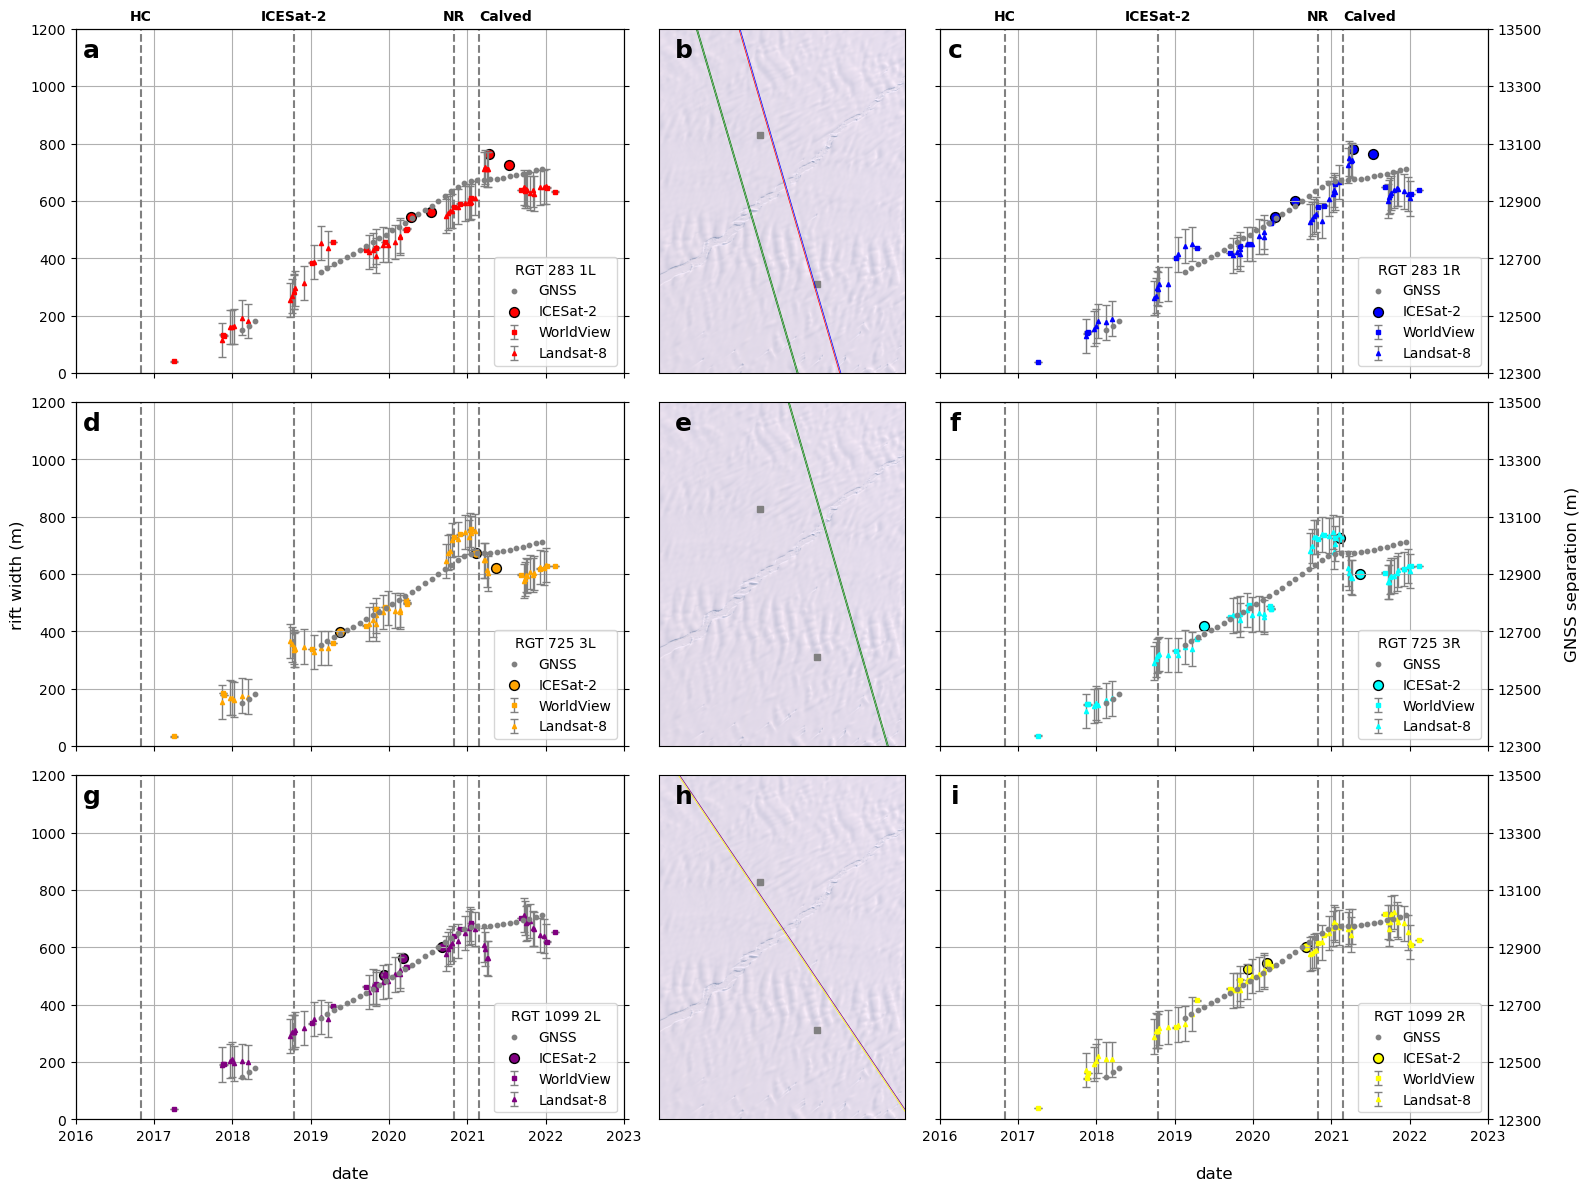

In [34]:
ftsz = 10

fig = plt.figure(figsize=(16, 12))

gs = gridspec.GridSpec(3, 5)

#------------------------------
# top left 283 1L
ax1 = plt.subplot(gs[0:1,0:2])
ax12 = ax1.twinx()

pl_gps = ax12.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax1.scatter(decdate_283_1l[1:5],halloween_obs_merged_283_1l["actual-non-iceberg-width"][1:5],s=50,c='r',edgecolor='k',label="ICESat-2")
pl_wv  = ax1.errorbar(satellite_obs_283_WV_1l["decimal_date"],satellite_obs_283_WV_1l["actual-non-iceberg-width"]\
            ,yerr=wv_283_1l_err,fmt='s',markersize=3,color='r',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax1.errorbar(satellite_obs_283_L8_1l["decimal_date"],satellite_obs_283_L8_1l["actual-non-iceberg-width"]\
            ,yerr=l8_283_1l_err,fmt='^',markersize=3,color='r',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax1.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 283 1L", loc= 'lower right', fontsize=ftsz)

ax1.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax1.text(HC_found,1230,'HC',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax1.text(IS_start,1230,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax1.text(NR_found,1230,'NR',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')
ax1.text(NR_calve,1230,'Calved',fontsize=ftsz,weight='bold',ha='left')


ax1.set_xlim(2016,2023)
ax1.set_ylim(0,1200)
ax12.set_yticks([12300,12500,12700,12900,13100,13300,13500])
ax12.set_ylim(12300,13500)
ax1.grid()

ax1.axes.xaxis.set_ticklabels([])
ax12.axes.yaxis.set_ticklabels([])

ax1.annotate("a",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# top right 283 1R
ax2 = plt.subplot(gs[0,3:5])
ax22 = ax2.twinx()

pl_gps = ax22.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax2.scatter(decdate_283_1r[1:5],halloween_obs_merged_283_1r["actual-non-iceberg-width"][1:5],s=50,c='b',edgecolor='k',label="ICESat-2")
pl_wv  = ax2.errorbar(satellite_obs_283_WV_1r["decimal_date"],satellite_obs_283_WV_1r["actual-non-iceberg-width"]\
            ,yerr=wv_283_1r_err,fmt='s',markersize=3,color='b',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax2.errorbar(satellite_obs_283_L8_1r["decimal_date"],satellite_obs_283_L8_1r["actual-non-iceberg-width"]\
            ,yerr=l8_283_1r_err,fmt='^',markersize=3,color='b',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax2.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 283 1R", loc= 'lower right', fontsize=ftsz)

ax2.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax2.text(HC_found,1230,'HC',fontsize=ftsz,weight='bold',ha='center')
ax2.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax2.text(IS_start,1230,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax2.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax2.text(NR_found,1230,'NR',fontsize=ftsz,weight='bold',ha='center')
ax2.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')
ax2.text(NR_calve,1230,'Calved',fontsize=ftsz,weight='bold',ha='left')

ax2.set_xlim(2016,2023)
ax2.set_ylim(0,1200)
ax22.set_yticks([12300,12500,12700,12900,13100,13300,13500])
ax22.set_ylim(12300,13500)
ax2.grid()

ax2.axes.xaxis.set_ticklabels([])
ax2.axes.yaxis.set_ticklabels([])

ax2.annotate("c",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# middle left 725 3L
ax3=plt.subplot(gs[1:2,0:2])
ax32 = ax3.twinx()

pl_gps = ax32.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax3.scatter(decdate_725_3l[1:4],halloween_obs_merged_725_3l["actual-non-iceberg-width"][1:4],s=50,c='orange',edgecolor='k',label="ICESat-2")
pl_wv  = ax3.errorbar(satellite_obs_725_WV_3l["decimal_date"],satellite_obs_725_WV_3l["actual-non-iceberg-width"]\
            ,yerr=wv_725_3l_err,fmt='s',markersize=3,color='orange',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax3.errorbar(satellite_obs_725_L8_3l["decimal_date"],satellite_obs_725_L8_3l["actual-non-iceberg-width"]\
            ,yerr=l8_725_3l_err,fmt='^',markersize=3,color='orange',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax3.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 725 3L", loc= 'lower right', fontsize=ftsz)

ax3.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax3.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax3.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax3.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax3.set_xlim(2016,2023)
ax3.set_ylim(0,1200)
ax32.set_yticks([12300,12500,12700,12900,13100,13300,13500])
ax32.set_ylim(12300,13500)
ax3.grid()

ax3.axes.xaxis.set_ticklabels([])
ax32.axes.yaxis.set_ticklabels([])

ax3.annotate("d",(2016.2,1125),size=18,weight='bold',ha='center',va='center')


#------------------------------
# middle right 725 3R
ax4=plt.subplot(gs[1:2,3:5])
ax42 = ax4.twinx()

pl_gps = ax42.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax4.scatter(decdate_725_3r[1:4],halloween_obs_merged_725_3r["actual-non-iceberg-width"][1:4],s=50,c='cyan',edgecolor='k',label="ICESat-2")
pl_wv  = ax4.errorbar(satellite_obs_725_WV_3r["decimal_date"],satellite_obs_725_WV_3r["actual-non-iceberg-width"]\
            ,yerr=wv_725_3r_err,fmt='s',markersize=3,color='cyan',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax4.errorbar(satellite_obs_725_L8_3r["decimal_date"],satellite_obs_725_L8_3r["actual-non-iceberg-width"]\
            ,yerr=l8_725_3r_err,fmt='^',markersize=3,color='cyan',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax4.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 725 3R", loc= 'lower right', fontsize=ftsz)

ax4.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax4.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax4.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax4.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax4.set_xlim(2016,2023)
ax4.set_ylim(0,1200)
ax42.set_yticks([12300,12500,12700,12900,13100,13300,13500])
ax42.set_ylim(12300,13500)
ax4.grid()

ax4.axes.xaxis.set_ticklabels([])
ax4.axes.yaxis.set_ticklabels([])

ax4.annotate("f",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# bottom left 1099 2L
ax5=plt.subplot(gs[2:3,0:2])
ax52 = ax5.twinx()

pl_gps = ax52.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax5.scatter(decdate_1099_2l[1:4],halloween_obs_merged_1099_2l["actual-non-iceberg-width"][1:4],s=50,c='purple',edgecolor='k',label="ICESat-2")
pl_wv  = ax5.errorbar(satellite_obs_1099_WV_2l["decimal_date"],satellite_obs_1099_WV_2l["actual-non-iceberg-width"]\
            ,yerr=wv_1099_2l_err,fmt='s',markersize=3,color='purple',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax5.errorbar(satellite_obs_1099_L8_2l["decimal_date"],satellite_obs_1099_L8_2l["actual-non-iceberg-width"]\
            ,yerr=l8_1099_2l_err,fmt='^',markersize=3,color='purple',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax5.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 1099 2L", loc= 'lower right', fontsize=ftsz)

ax5.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax5.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax5.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax5.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax5.set_xlim(2016,2023)
ax5.set_ylim(0,1200)
ax52.set_yticks([12300,12500,12700,12900,13100,13300,13500])
ax52.set_ylim(12300,13500)
ax5.grid()

ax52.axes.yaxis.set_ticklabels([])

ax5.annotate("g",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# bottom right 1099 2R
ax6=plt.subplot(gs[2:3,3:5])
ax62 = ax6.twinx()

pl_gps = ax62.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="GNSS")
pl_is2 = ax6.scatter(decdate_1099_2r[1:4],halloween_obs_merged_1099_2r["actual-non-iceberg-width"][1:4],s=50,c='yellow',edgecolor='k',label="ICESat-2")
pl_wv  = ax6.errorbar(satellite_obs_1099_WV_2r["decimal_date"],satellite_obs_1099_WV_2r["actual-non-iceberg-width"]\
            ,yerr=wv_1099_2r_err,fmt='s',markersize=3,color='yellow',ecolor='gray',capsize=3,elinewidth=1,label="WorldView")
pl_ls8 = ax6.errorbar(satellite_obs_1099_L8_2r["decimal_date"],satellite_obs_1099_L8_2r["actual-non-iceberg-width"]\
            ,yerr=l8_1099_2r_err,fmt='^',markersize=3,color='yellow',ecolor='gray',capsize=3,elinewidth=1,label="Landsat-8")
pl_all =[pl_gps, pl_is2, pl_wv, pl_ls8]

ax6.legend(pl_all, [p_.get_label() for p_ in pl_all], title="RGT 1099 2R", loc= 'lower right', fontsize=ftsz)

ax6.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax6.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax6.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax6.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax6.set_xlim(2016,2023)
ax6.set_ylim(0,1200)
ax62.set_yticks([12300,12500,12700,12900,13100,13300,13500])
ax62.set_ylim(12300,13500)
ax6.grid()

ax6.axes.yaxis.set_ticklabels([])

ax6.annotate("i",(2016.2,1125),size=18,weight='bold',ha='center',va='center')

#------------------------------
# images 283

xmininse = -685000
xmaxinse = -665000
ymininse = 1425000 
ymaxinse = 1453000

ax101 = plt.subplot(gs[0:1,2:3])

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax101)

ax101.plot(ss00_x[0],ss00_y[0],'s',color='gray',markersize=5)
ax101.plot(tt04_x[1],tt04_y[1],'s',color='gray',markersize=5)

#283
#1L
easting = shapefile1L_ar["easting"][45]
northing = shapefile1L_ar["northing"][45]
ax101.plot(easting,northing,'red',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][45]
northing = shapefile1R_ar["northing"][45]
ax101.plot(easting,northing,'blue',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][45]
northing = shapefile2L_ar["northing"][45]
ax101.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][45]
northing = shapefile2R_ar["northing"][45]
ax101.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][42]
northing = shapefile3L_ar["northing"][42]
ax101.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][42]
northing = shapefile3R_ar["northing"][42]
ax101.plot(easting,northing,'g',linewidth=0.5)

##annotate
#ax101.text(-679100, 1450800, '283 1  ', rotation=-72, fontsize=6, color='g')
#ax101.text(-682500, 1450800, '283 2  ', rotation=-72, fontsize=6, color='g')
#ax101.text(-684400, 1445200, '283 3  ', rotation=-72, fontsize=6, color='g')

ax101.set_xlim(xmininse,xmaxinse)
ax101.set_ylim(ymininse,ymaxinse)
ax101.axes.xaxis.set_ticks([])
ax101.axes.yaxis.set_ticks([])
ax101.axes.xaxis.set_ticklabels([])
ax101.axes.yaxis.set_ticklabels([])

ax101.annotate("b",(-683000,1451250),size=18,weight='bold',ha='center',va='center')

#------------------------------
# images 725

ax102 = plt.subplot(gs[1:2,2:3])

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax102)

ax102.plot(ss00_x[0],ss00_y[0],'s',color='gray',markersize=5)
ax102.plot(tt04_x[1],tt04_y[1],'s',color='gray',markersize=5)

#725
#1L
easting = shapefile1L_ar["easting"][118]
northing = shapefile1L_ar["northing"][118]
ax102.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][118]
northing = shapefile1R_ar["northing"][118]
ax102.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][118]
northing = shapefile2L_ar["northing"][118]
ax102.plot(easting,northing,'g',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][119]
northing = shapefile2R_ar["northing"][119]
ax102.plot(easting,northing,'g',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][109]
northing = shapefile3L_ar["northing"][109]
ax102.plot(easting,northing,'orange',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][109]
northing = shapefile3R_ar["northing"][109]
ax102.plot(easting,northing,'cyan',linewidth=0.5)

#annotate
#ax102.text(-677600, 1450800, '725 3  ', rotation=-72, fontsize=6, color='g')
#ax102.text(-674200, 1450800, '725 2  ', rotation=-72, fontsize=6, color='g')
#ax102.text(-670700, 1450800, '725 1  ', rotation=-72, fontsize=6, color='g')

ax102.set_xlim(xmininse,xmaxinse)
ax102.set_ylim(ymininse,ymaxinse)
ax102.axes.xaxis.set_ticks([])
ax102.axes.yaxis.set_ticks([])
ax102.axes.xaxis.set_ticklabels([])
ax102.axes.yaxis.set_ticklabels([])

ax102.annotate("e",(-683000,1451250),size=18,weight='bold',ha='center',va='center')

#------------------------------
# images 1099

ax103 = plt.subplot(gs[2:3,2:3])

show(norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax103)

ax103.plot(ss00_x[0],ss00_y[0],'s',color='gray',markersize=5)
ax103.plot(tt04_x[1],tt04_y[1],'s',color='gray',markersize=5)

#1099
#1L
easting = shapefile1L_ar["easting"][180]
northing = shapefile1L_ar["northing"][180]
ax103.plot(easting,northing,'g',linewidth=0.5)
#1R
easting = shapefile1R_ar["easting"][180]
northing = shapefile1R_ar["northing"][180]
ax103.plot(easting,northing,'g',linewidth=0.5)
#2L
easting = shapefile2L_ar["easting"][181]
northing = shapefile2L_ar["northing"][181]
ax103.plot(easting,northing,'purple',linewidth=0.5)
#2R
easting = shapefile2R_ar["easting"][182]
northing = shapefile2R_ar["northing"][182]
ax103.plot(easting,northing,'yellow',linewidth=0.5)
#3L
easting = shapefile3L_ar["easting"][167]
northing = shapefile3L_ar["northing"][167]
ax103.plot(easting,northing,'g',linewidth=0.5)
#3R
easting = shapefile3R_ar["easting"][167]
northing = shapefile3R_ar["northing"][167]
ax103.plot(easting,northing,'g',linewidth=0.5)

#annotate
#ax103.text(-678500, 1450800, '1099 3 ', rotation=-55, fontsize=6, color='g')
#ax103.text(-682600, 1450800, '1099 2 ', rotation=-55, fontsize=6, color='g')
#ax103.text(-684400, 1447600, '1099 1 ', rotation=-55, fontsize=6, color='g')

ax103.set_xlim(xmininse,xmaxinse)
ax103.set_ylim(ymininse,ymaxinse)
ax103.axes.xaxis.set_ticks([])
ax103.axes.yaxis.set_ticks([])
ax103.axes.xaxis.set_ticklabels([])
ax103.axes.yaxis.set_ticklabels([])

ax103.annotate("h",(-683000,1451250),size=18,weight='bold',ha='center',va='center')

#------------------------------
# labels

ax5.set_xlabel("\ndate", fontsize=ftsz+2)
ax6.set_xlabel("\ndate", fontsize=ftsz+2)
ax3.set_ylabel("rift width (m)", fontsize=ftsz+2)
ax42.set_ylabel("\nGNSS separation (m)", fontsize=ftsz+2)

plt.tight_layout()

output = figure_folder+'/fig05_eastern_map_graph.png'
plt.savefig(output, dpi=100, bbox_inches='tight')

plt.show()


## Figure 6 line of best fit
Lines of best fit along GPS, ICESat-2, Landsat-8, WorldView for all\
Divide at 2021.0

### linear regression

In [35]:
# divide time
div_t = 2021.0

# post-calving mid-time for eastern GNSS pair
mid_div = 2021 + ((7-1)/12) + ((1-1)/365)

#--------------------------------------------------
# western GNSS pair pre-calving
wgps_div_slope_PreC = linregress(hh00_t[hh00_t<div_t],actual_hh00_tt05_sep_d_div[hh00_t<div_t]).slope
wgps_div_inter_PreC = linregress(hh00_t[hh00_t<div_t],actual_hh00_tt05_sep_d_div[hh00_t<div_t]).intercept

lobf_hh00_tt05_PreC = (wgps_div_slope_PreC * hh00_t[hh00_t<div_t]) + wgps_div_inter_PreC
resid_hh00_tt05_PreC = actual_hh00_tt05_sep_d_div[hh00_t<div_t] - lobf_hh00_tt05_PreC
r2_hh00_tt05_PreC = 1 - (np.sum(resid_hh00_tt05_PreC**2)/np.sum((actual_hh00_tt05_sep_d_div[hh00_t<div_t] - np.mean(actual_hh00_tt05_sep_d_div[hh00_t<div_t]))**2))

print("GNSS west Pre-Calving. rate: "+str(round(wgps_div_slope_PreC,1))+" r^2: "+str(round(r2_hh00_tt05_PreC,3)))
print("----------")

#--------------------------------------------------
# eastern GNSS pair pre-calving
egps_div_slope_PreC = linregress(ss00_t[ss00_t<div_t],actual_ss00_tt04_sep_d_div[ss00_t<div_t]).slope
egps_div_inter_PreC = linregress(ss00_t[ss00_t<div_t],actual_ss00_tt04_sep_d_div[ss00_t<div_t]).intercept

lobf_ss00_tt04_PreC = (egps_div_slope_PreC * ss00_t[ss00_t<div_t]) + egps_div_inter_PreC
resid_ss00_tt04_PreC = actual_ss00_tt04_sep_d_div[ss00_t<div_t] - lobf_ss00_tt04_PreC
r2_ss00_tt04_PreC = 1 - (np.sum(resid_ss00_tt04_PreC**2)/np.sum((actual_ss00_tt04_sep_d_div[ss00_t<div_t] - np.mean(actual_ss00_tt04_sep_d_div[ss00_t<div_t]))**2))

print("GNSS east Pre-Calving. rate: "+str(round(egps_div_slope_PreC,1))+" r^2: "+str(round(r2_ss00_tt04_PreC,3)))
print("")

#--------------------------------------------------
# eastern GNSS pair post-calving
egps_div_slope_PostC = linregress(ss00_t[ss00_t>div_t],actual_ss00_tt04_sep_d_div[ss00_t>div_t]).slope
egps_div_inter_PostC = linregress(ss00_t[ss00_t>div_t],actual_ss00_tt04_sep_d_div[ss00_t>div_t]).intercept

lobf_ss00_tt04_PostC = (egps_div_slope_PostC * ss00_t[ss00_t>div_t]) + egps_div_inter_PostC
resid_ss00_tt04_PostC = actual_ss00_tt04_sep_d_div[ss00_t>div_t] - lobf_ss00_tt04_PostC
r2_ss00_tt04_PostC = 1 - (np.sum(resid_ss00_tt04_PostC**2)/np.sum((actual_ss00_tt04_sep_d_div[ss00_t>div_t] - np.mean(actual_ss00_tt04_sep_d_div[ss00_t>div_t]))**2))

print("GNSS east Post-Calving. rate: "+str(round(egps_div_slope_PostC,1))+" r^2: "+str(round(r2_ss00_tt04_PostC,3)))
print("")

#--------------------------------------------------
# eastern GNSS first 6 months post-calving
egps_div_slope_PostC1 = linregress(ss00_t[(ss00_t>div_t)&(ss00_t<mid_div)],actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)]).slope
egps_div_inter_PostC1 = linregress(ss00_t[(ss00_t>div_t)&(ss00_t<mid_div)],actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)]).intercept

lobf_ss00_tt04_PostC1 = (egps_div_slope_PostC1 * ss00_t[(ss00_t>div_t)&(ss00_t<mid_div)]) + egps_div_inter_PostC1
resid_ss00_tt04_PostC1 = actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)] - lobf_ss00_tt04_PostC1
r2_ss00_tt04_PostC1 = 1 - (np.sum(resid_ss00_tt04_PostC1**2)/np.sum((actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)] - np.mean(actual_ss00_tt04_sep_d_div[(ss00_t>div_t)&(ss00_t<mid_div)]))**2))

print("GNSS east PostC 1st 6 months. rate: "+str(round(egps_div_slope_PostC1,1))+" r^2: "+str(round(r2_ss00_tt04_PostC1,3)))
print("")

#--------------------------------------------------
# eastern GNSS second 6 months post-calving
egps_div_slope_PostC2 = linregress(ss00_t[ss00_t>mid_div],actual_ss00_tt04_sep_d_div[ss00_t>mid_div]).slope
egps_div_inter_PostC2 = linregress(ss00_t[ss00_t>mid_div],actual_ss00_tt04_sep_d_div[ss00_t>mid_div]).intercept

lobf_ss00_tt04_PostC2 = (egps_div_slope_PostC2 * ss00_t[ss00_t>mid_div]) + egps_div_inter_PostC2
resid_ss00_tt04_PostC2 = actual_ss00_tt04_sep_d_div[ss00_t>mid_div] - lobf_ss00_tt04_PostC2
r2_ss00_tt04_PostC2 = 1 - (np.sum(resid_ss00_tt04_PostC2**2)/np.sum((actual_ss00_tt04_sep_d_div[ss00_t>mid_div] - np.mean(actual_ss00_tt04_sep_d_div[ss00_t>mid_div]))**2))

print("GNSS east PostC 2nd 6 months. rate: "+str(round(egps_div_slope_PostC2,1))+" r^2: "+str(round(r2_ss00_tt04_PostC2,3)))
print("----------")

#--------------------------------------------------
#ICESat-2 remove pointing errors
decdate_sub_1160_3l=decdate_1160_3l[[0,1,2,4]]
decdate_sub_1160_3r=decdate_1160_3r[[1,2,3,4]]
decdate_sub_215_1l=decdate_215_1l[[0,3,4,5,6,7,8]]
decdate_sub_215_1r=decdate_215_1r[[0,2,3,4,5,6,7,8]]
decdate_sub_786_2l=decdate_786_2l[[2,3,4,5,6,7]]
decdate_sub_786_2r=decdate_786_2r[[2,3,4,5,6,7]]
decdate_sub_is2_west=np.concatenate((decdate_sub_1160_3l,decdate_sub_1160_3r,decdate_sub_215_1l,decdate_sub_215_1r,decdate_sub_786_2l,decdate_sub_786_2r),axis=0)

width_1160_3l=halloween_obs_merged_1160_3l["actual-non-iceberg-width"].iloc[[0,1,2,4]]
width_1160_3r=halloween_obs_merged_1160_3r["actual-non-iceberg-width"].iloc[[1,2,3,4]]
width_215_1l=halloween_obs_merged_215_1l["actual-non-iceberg-width"].iloc[[0,3,4,5,6,7,8]]
width_215_1r=halloween_obs_merged_215_1r["actual-non-iceberg-width"].iloc[[0,2,3,4,5,6,7,8]]
width_786_2l=halloween_obs_merged_786_2l["actual-non-iceberg-width"].iloc[[2,3,4,5,6,7]]
width_786_2r=halloween_obs_merged_786_2r["actual-non-iceberg-width"].iloc[[2,3,4,5,6,7]]
width_is2_west=np.concatenate((width_1160_3l,width_1160_3r,width_215_1l,width_215_1r,width_786_2l,width_786_2r),axis=0)

decdate_sub_283_1l=decdate_283_1l[[1,2,3,4]]
decdate_sub_283_1r=decdate_283_1r[[1,2,3,4]]
decdate_sub_725_3l=decdate_725_3l[[1,2,3]]
decdate_sub_725_3r=decdate_725_3r[[1,2,3]]
decdate_sub_1099_2l=decdate_1099_2l[[1,2,3]]
decdate_sub_1099_2r=decdate_1099_2r[[1,2,3]]
decdate_sub_is2_east=np.concatenate((decdate_sub_283_1l,decdate_sub_283_1r,decdate_sub_725_3l,decdate_sub_725_3r,decdate_sub_1099_2l,decdate_sub_1099_2r),axis=0)

width_283_1l=halloween_obs_merged_283_1l["actual-non-iceberg-width"].iloc[[1,2,3,4]]
width_283_1r=halloween_obs_merged_283_1r["actual-non-iceberg-width"].iloc[[1,2,3,4]]
width_725_3l=halloween_obs_merged_725_3l["actual-non-iceberg-width"].iloc[[1,2,3]]
width_725_3r=halloween_obs_merged_725_3r["actual-non-iceberg-width"].iloc[[1,2,3]]
width_1099_2l=halloween_obs_merged_1099_2l["actual-non-iceberg-width"].iloc[[1,2,3]]
width_1099_2r=halloween_obs_merged_1099_2r["actual-non-iceberg-width"].iloc[[1,2,3]]
width_is2_east=np.concatenate((width_283_1l,width_283_1r,width_725_3l,width_725_3r,width_1099_2l,width_1099_2r),axis=0)

#--------------------------------------------------
# west ICESat-2 pre-calving
wis2_slope_PreC = linregress(decdate_sub_is2_west[decdate_sub_is2_west<div_t],width_is2_west[decdate_sub_is2_west<div_t]).slope
wis2_inter_PreC = linregress(decdate_sub_is2_west[decdate_sub_is2_west<div_t],width_is2_west[decdate_sub_is2_west<div_t]).intercept

lobf_wis2_PreC = (wis2_slope_PreC * decdate_sub_is2_west[decdate_sub_is2_west<div_t]) + wis2_inter_PreC
resid_wis2_PreC = width_is2_west[decdate_sub_is2_west<div_t] - lobf_wis2_PreC
r2_wis2_PreC = 1 - (np.sum(resid_wis2_PreC**2)/np.sum((width_is2_west[decdate_sub_is2_west<div_t] - np.mean(width_is2_west[decdate_sub_is2_west<div_t]))**2))

print("IS2 west Pre-Calving. rate: "+str(round(wis2_slope_PreC,1))+" r^2: "+str(round(r2_wis2_PreC,3)))
print("")

#--------------------------------------------------
# west ICESat-2 post-calving
wis2_slope_PostC = linregress(decdate_sub_is2_west[decdate_sub_is2_west>div_t],width_is2_west[decdate_sub_is2_west>div_t]).slope
wis2_inter_PostC = linregress(decdate_sub_is2_west[decdate_sub_is2_west>div_t],width_is2_west[decdate_sub_is2_west>div_t]).intercept

lobf_wis2_PostC = (wis2_slope_PostC * decdate_sub_is2_west[decdate_sub_is2_west>div_t]) + wis2_inter_PostC
resid_wis2_PostC = width_is2_west[decdate_sub_is2_west>div_t] - lobf_wis2_PostC
r2_wis2_PostC = 1 - (np.sum(resid_wis2_PostC**2)/np.sum((width_is2_west[decdate_sub_is2_west>div_t] - np.mean(width_is2_west[decdate_sub_is2_west>div_t]))**2))

print("IS2 west Post-Calving. rate:"+str(round(wis2_slope_PostC,1))+" r^2: "+str(round(r2_wis2_PostC,3)))
print("----------")

#--------------------------------------------------
# east ICESat-2 pre-calving
eis2_slope_PreC = linregress(decdate_sub_is2_east[decdate_sub_is2_east<div_t],width_is2_east[decdate_sub_is2_east<div_t]).slope
eis2_inter_PreC = linregress(decdate_sub_is2_east[decdate_sub_is2_east<div_t],width_is2_east[decdate_sub_is2_east<div_t]).intercept

lobf_eis2_PreC = (eis2_slope_PreC * decdate_sub_is2_east[decdate_sub_is2_east<div_t]) + eis2_inter_PreC
resid_eis2_PreC = width_is2_east[decdate_sub_is2_east<div_t] - lobf_eis2_PreC
r2_eis2_PreC = 1 - (np.sum(resid_eis2_PreC**2)/np.sum((width_is2_east[decdate_sub_is2_east<div_t] - np.mean(width_is2_east[decdate_sub_is2_east<div_t]))**2))

print("IS2 east Pre-Calving. rate: "+str(round(eis2_slope_PreC,1))+" r^2: "+str(round(r2_eis2_PreC,3)))
print("")

#--------------------------------------------------
# east ICESat-2 post-calving
eis2_slope_PostC = linregress(decdate_sub_is2_east[decdate_sub_is2_east>div_t],width_is2_east[decdate_sub_is2_east>div_t]).slope
eis2_inter_PostC = linregress(decdate_sub_is2_east[decdate_sub_is2_east>div_t],width_is2_east[decdate_sub_is2_east>div_t]).intercept

lobf_eis2_PostC = (eis2_slope_PostC * decdate_sub_is2_east[decdate_sub_is2_east>div_t]) + eis2_inter_PostC
resid_eis2_PostC = width_is2_east[decdate_sub_is2_east>div_t] - lobf_eis2_PostC
r2_eis2_PostC = 1 - (np.sum(resid_eis2_PostC**2)/np.sum((width_is2_east[decdate_sub_is2_east>div_t] - np.mean(width_is2_east[decdate_sub_is2_east>div_t]))**2))

print("IS2 east Post-Calving. rate: "+str(round(eis2_slope_PostC,1))+"r^2: "+str(round(r2_eis2_PostC,3)))
print("----------")

#--------------------------------------------------
#Landsat/WorldView
#Satellite date
wsatd1=satellite_obs_1160_L8_3l["decimal_date"]
wsatd2=satellite_obs_1160_L8_3r["decimal_date"]
wsatd3=satellite_obs_215_L8_1l["decimal_date"]
wsatd4=satellite_obs_215_L8_1r["decimal_date"]
wsatd5=satellite_obs_786_L8_2l["decimal_date"]
wsatd6=satellite_obs_786_L8_2r["decimal_date"]
wsatd7=satellite_obs_1160_WV_3l["decimal_date"]
wsatd8=satellite_obs_1160_WV_3r["decimal_date"]
wsatd9=satellite_obs_215_WV_1l["decimal_date"]
wsatd10=satellite_obs_215_WV_1r["decimal_date"]
wsatd11=satellite_obs_786_WV_2l["decimal_date"]
wsatd12=satellite_obs_786_WV_2r["decimal_date"]
decdate_sat_west=np.concatenate((wsatd1,wsatd2,wsatd3,wsatd4,wsatd5,wsatd6,wsatd7,wsatd8,wsatd9,wsatd10,wsatd11,wsatd12),axis=0)

#decdate_sat_west=np.concatenate((satellite_obs_1160_L8_3l["decimal_date"],satellite_obs_1160_L8_3r["decimal_date"],satellite_obs_215_L8_1l["decimal_date"],satellite_obs_215_L8_1r["decimal_date"],satellite_obs_786_L8_2l["decimal_date"],satellite_obs_786_L8_2r["decimal_date"],
#satellite_obs_1160_WV_3l["decimal_date"],satellite_obs_1160_WV_3r["decimal_date"],satellite_obs_215_WV_1l["decimal_date"],satellite_obs_215_WV_1r["decimal_date"],satellite_obs_786_WV_2l["decimal_date"],satellite_obs_786_WV_2r["decimal_date"]),axis=0)

esatd1=satellite_obs_283_L8_1l["decimal_date"]
esatd2=satellite_obs_283_L8_1r["decimal_date"]
esatd3=satellite_obs_725_L8_3l["decimal_date"]
esatd4=satellite_obs_725_L8_3r["decimal_date"]
esatd5=satellite_obs_1099_L8_2l["decimal_date"]
esatd6=satellite_obs_1099_L8_2r["decimal_date"]
esatd7=satellite_obs_283_WV_1l["decimal_date"]
esatd8=satellite_obs_283_WV_1r["decimal_date"]
esatd9=satellite_obs_725_WV_3l["decimal_date"]
esatd10=satellite_obs_725_WV_3r["decimal_date"]
esatd11=satellite_obs_1099_WV_2l["decimal_date"]
esatd12=satellite_obs_1099_WV_2r["decimal_date"]
decdate_sat_east=np.concatenate((esatd1,esatd2,esatd3,esatd4,esatd5,esatd6,esatd7,esatd8,esatd9,esatd10,esatd11,esatd12),axis=0)

#decdate_sat_east=np.concatenate((satellite_obs_283_L8_1l["decimal_date"],satellite_obs_283_L8_1r["decimal_date"],satellite_obs_725_L8_3l["decimal_date"],satellite_obs_725_L8_3r["decimal_date"],satellite_obs_1099_L8_2l["decimal_date"],satellite_obs_1099_L8_2r["decimal_date"],
#satellite_obs_283_WV_1l["decimal_date"],satellite_obs_283_WV_1r["decimal_date"],satellite_obs_725_WV_3l["decimal_date"],satellite_obs_725_WV_3r["decimal_date"],satellite_obs_1099_WV_2l["decimal_date"],satellite_obs_1099_WV_2r["decimal_date"]),axis=0)

#Satellite width
wsatw1=satellite_obs_1160_L8_3l["actual-non-iceberg-width"]
wsatw2=satellite_obs_1160_L8_3r["actual-non-iceberg-width"]
wsatw3=satellite_obs_215_L8_1l["actual-non-iceberg-width"]
wsatw4=satellite_obs_215_L8_1r["actual-non-iceberg-width"]
wsatw5=satellite_obs_786_L8_2l["actual-non-iceberg-width"]
wsatw6=satellite_obs_786_L8_2r["actual-non-iceberg-width"]
wsatw7=satellite_obs_1160_WV_3l["actual-non-iceberg-width"]
wsatw8=satellite_obs_1160_WV_3r["actual-non-iceberg-width"]
wsatw9=satellite_obs_215_WV_1l["actual-non-iceberg-width"]
wsatw10=satellite_obs_215_WV_1r["actual-non-iceberg-width"]
wsatw11=satellite_obs_786_WV_2l["actual-non-iceberg-width"]
wsatw12=satellite_obs_786_WV_2r["actual-non-iceberg-width"]
width_sat_west=np.concatenate((wsatw1,wsatw2,wsatw3,wsatw4,wsatw5,wsatw6,wsatw7,wsatw8,wsatw9,wsatw10,wsatw11,wsatw12),axis=0)

#width_sat_west=np.concatenate((satellite_obs_1160_L8_3l["actual-non-iceberg-width"],satellite_obs_1160_L8_3r["actual-non-iceberg-width"],satellite_obs_215_L8_1l["actual-non-iceberg-width"],satellite_obs_215_L8_1r["actual-non-iceberg-width"],satellite_obs_786_L8_2l["actual-non-iceberg-width"],satellite_obs_786_L8_2r["actual-non-iceberg-width"],
#satellite_obs_1160_WV_3l["actual-non-iceberg-width"],satellite_obs_1160_WV_3r["actual-non-iceberg-width"],satellite_obs_215_WV_1l["actual-non-iceberg-width"],satellite_obs_215_WV_1r["actual-non-iceberg-width"],satellite_obs_786_WV_2l["actual-non-iceberg-width"],satellite_obs_786_WV_2r["actual-non-iceberg-width"]),axis=0)

esatw1=satellite_obs_283_L8_1l["actual-non-iceberg-width"]
esatw2=satellite_obs_283_L8_1r["actual-non-iceberg-width"]
esatw3=satellite_obs_725_L8_3l["actual-non-iceberg-width"]
esatw4=satellite_obs_725_L8_3r["actual-non-iceberg-width"]
esatw5=satellite_obs_1099_L8_2l["actual-non-iceberg-width"]
esatw6=satellite_obs_1099_L8_2r["actual-non-iceberg-width"]
esatw7=satellite_obs_283_WV_1l["actual-non-iceberg-width"]
esatw8=satellite_obs_283_WV_1r["actual-non-iceberg-width"]
esatw9=satellite_obs_725_WV_3l["actual-non-iceberg-width"]
esatw10=satellite_obs_725_WV_3r["actual-non-iceberg-width"]
esatw11=satellite_obs_1099_WV_2l["actual-non-iceberg-width"]
esatw12=satellite_obs_1099_WV_2r["actual-non-iceberg-width"]
width_sat_east=np.concatenate((esatw1,esatw2,esatw3,esatw4,esatw5,esatw6,esatw7,esatw8,esatw9,esatw10,esatw11,esatw12),axis=0)

#--------------------------------------------------
# west satellite pre-calving
wsat_slope_PreC = linregress(decdate_sat_west[decdate_sat_west<div_t],width_sat_west[decdate_sat_west<div_t]).slope
wsat_inter_PreC = linregress(decdate_sat_west[decdate_sat_west<div_t],width_sat_west[decdate_sat_west<div_t]).intercept

lobf_wsat_PreC = (wsat_slope_PreC * decdate_sat_west[decdate_sat_west<div_t]) + wsat_inter_PreC
resid_wsat_PreC = width_sat_west[decdate_sat_west<div_t] - lobf_wsat_PreC
r2_wsat_PreC = 1 - (np.sum(resid_wsat_PreC**2)/np.sum((width_sat_west[decdate_sat_west<div_t] - np.mean(width_sat_west[decdate_sat_west<div_t]))**2))

print("sat west Pre-Calving. rate: "+str(round(wsat_slope_PreC,1))+" r^2: "+str(round(r2_wsat_PreC,3)))
print("")

#--------------------------------------------------
# west satellite post-calving
wsat_slope_PostC = linregress(decdate_sat_west[decdate_sat_west>div_t],width_sat_west[decdate_sat_west>div_t]).slope
wsat_inter_PostC = linregress(decdate_sat_west[decdate_sat_west>div_t],width_sat_west[decdate_sat_west>div_t]).intercept

lobf_wsat_PostC = (wsat_slope_PostC * decdate_sat_west[decdate_sat_west>div_t]) + wsat_inter_PostC
resid_wsat_PostC = width_sat_west[decdate_sat_west>div_t] - lobf_wsat_PostC
r2_wsat_PostC = 1 - (np.sum(resid_wsat_PostC**2)/np.sum((width_sat_west[decdate_sat_west>div_t] - np.mean(width_sat_west[decdate_sat_west>div_t]))**2))

print("sat west Post-Calving. rate: "+str(round(wsat_slope_PostC,1))+" r^2: "+str(round(r2_wsat_PostC,3)))
print("----------")

#--------------------------------------------------
# east satellite pre-calving
esat_slope_PreC = linregress(decdate_sat_east[decdate_sat_east<div_t],width_sat_east[decdate_sat_east<div_t]).slope
esat_inter_PreC = linregress(decdate_sat_east[decdate_sat_east<div_t],width_sat_east[decdate_sat_east<div_t]).intercept

lobf_esat_PreC = (esat_slope_PreC * decdate_sat_east[decdate_sat_east<div_t]) + esat_inter_PreC
resid_esat_PreC = width_sat_east[decdate_sat_east<div_t] - lobf_esat_PreC
r2_esat_PreC = 1 - (np.sum(resid_esat_PreC**2)/np.sum((width_sat_east[decdate_sat_east<div_t] - np.mean(width_sat_east[decdate_sat_east<div_t]))**2))

print("sat east Pre-Calving. rate: "+str(round(esat_slope_PreC,1))+"r^2: "+str(round(r2_esat_PreC,3)))
print("")

#--------------------------------------------------
# east satellite post-calving
esat_slope_PostC = linregress(decdate_sat_east[decdate_sat_east>div_t],width_sat_east[decdate_sat_east>div_t]).slope
esat_inter_PostC = linregress(decdate_sat_east[decdate_sat_east>div_t],width_sat_east[decdate_sat_east>div_t]).intercept

lobf_esat_PostC = (esat_slope_PostC * decdate_sat_east[decdate_sat_east>div_t]) + esat_inter_PostC
resid_esat_PostC = width_sat_east[decdate_sat_east>div_t] - lobf_esat_PostC
r2_esat_PostC = 1 - (np.sum(resid_esat_PostC**2)/np.sum((width_sat_east[decdate_sat_east>div_t] - np.mean(width_sat_east[decdate_sat_east>div_t]))**2))

print("sat east Post-Calving. rate: "+str(round(esat_slope_PostC,1))+" r^2: "+str(round(r2_esat_PostC,3)))
print("----------")


GNSS west Pre-Calving. rate: 254.5 r^2: 0.997
----------
GNSS east Pre-Calving. rate: 176.9 r^2: 0.997

GNSS east Post-Calving. rate: 46.1 r^2: 0.945

GNSS east PostC 1st 6 months. rate: 23.3 r^2: 0.931

GNSS east PostC 2nd 6 months. rate: 66.9 r^2: 0.996
----------
IS2 west Pre-Calving. rate: 246.3 r^2: 0.938

IS2 west Post-Calving. rate:-84.9 r^2: 0.27
----------
IS2 east Pre-Calving. rate: 144.0 r^2: 0.946

IS2 east Post-Calving. rate: 32.4r^2: 0.006
----------
sat west Pre-Calving. rate: 270.6 r^2: 0.991

sat west Post-Calving. rate: 32.5 r^2: 0.108
----------
sat east Pre-Calving. rate: 158.0r^2: 0.948

sat east Post-Calving. rate: -42.6 r^2: 0.119
----------


### 95% Confidence intervals
use https://www.meracalculator.com/math/t-distribution-critical-value-table.php to calculate t-value

In [36]:
print('number of samples for calculating t')
print('GNSS_west_pre : '+str(len(lobf_hh00_tt05_PreC)))
print('GNSS_west_post: n/a')
print('GNSS_east_pre : '+str(len(lobf_ss00_tt04_PreC)))
print('GNSS_east_post: '+str(len(lobf_ss00_tt04_PostC)))
print('sat_west_pre  : '+str(len(lobf_wsat_PreC)))
print('sat_west_post : '+str(len(lobf_wsat_PostC)))
print('sat_east_pre  : '+str(len(lobf_esat_PreC)))
print('sat_east_post : '+str(len(lobf_esat_PostC)))
print('IS2_west_pre  : '+str(len(lobf_wis2_PreC)))
print('IS2_west_post : '+str(len(lobf_wis2_PostC)))
print('IS2_east_pre  : '+str(len(lobf_eis2_PreC)))
print('IS2_east_post : '+str(len(lobf_eis2_PostC)))


number of samples for calculating t
GNSS_west_pre : 34
GNSS_west_post: n/a
GNSS_east_pre : 26
GNSS_east_post: 12
sat_west_pre  : 274
sat_west_post : 134
sat_east_pre  : 253
sat_east_post : 134
IS2_west_pre  : 25
IS2_west_post : 10
IS2_east_pre  : 12
IS2_east_post : 8


In [37]:
#GNSS west pre-calving
GNSS_west_pre_t_ls = np.linspace(2016,2023,29)
GNSS_west_pre_lobf_ls = (wgps_div_slope_PreC * GNSS_west_pre_t_ls) + wgps_div_inter_PreC

GNSS_west_pre_t_mean = np.mean(hh00_t[hh00_t<div_t])

GNSS_west_pre_n = len(hh00_t[hh00_t<div_t])

GNSS_west_pre_tval = 2.04

GNSS_west_pre_error =np.sum(np.power(resid_hh00_tt05_PreC,2))

GNSS_west_pre_conf_int = GNSS_west_pre_tval * np.sqrt((GNSS_west_pre_error/(GNSS_west_pre_n-2))*(1.0/GNSS_west_pre_n + (np.power((GNSS_west_pre_t_ls-GNSS_west_pre_t_mean),2)/((np.sum(np.power(hh00_t[hh00_t<div_t],2)))-GNSS_west_pre_n*(np.power(GNSS_west_pre_t_mean,2))))))

GNSS_west_pre_conf_int_up  = GNSS_west_pre_lobf_ls + GNSS_west_pre_conf_int
GNSS_west_pre_conf_int_low = GNSS_west_pre_lobf_ls - GNSS_west_pre_conf_int

#--------------------------------------------------
#GNSS east pre-calving
GNSS_east_pre_t_ls = np.linspace(2016,2023,29)
GNSS_east_pre_lobf_ls = (egps_div_slope_PreC * GNSS_east_pre_t_ls) + egps_div_inter_PreC

GNSS_east_pre_t_mean = np.mean(ss00_t[ss00_t<div_t])

GNSS_east_pre_n = len(ss00_t[ss00_t<div_t])

GNSS_east_pre_tval = 2.06

GNSS_east_pre_error =np.sum(np.power(resid_ss00_tt04_PreC,2))

GNSS_east_pre_conf_int = GNSS_east_pre_tval * np.sqrt((GNSS_east_pre_error/(GNSS_east_pre_n-2))*(1.0/GNSS_east_pre_n + (np.power((GNSS_east_pre_t_ls-GNSS_east_pre_t_mean),2)/((np.sum(np.power(ss00_t[ss00_t<div_t],2)))-GNSS_east_pre_n*(np.power(GNSS_east_pre_t_mean,2))))))

GNSS_east_pre_conf_int_up  = GNSS_east_pre_lobf_ls + GNSS_east_pre_conf_int
GNSS_east_pre_conf_int_low = GNSS_east_pre_lobf_ls - GNSS_east_pre_conf_int

#--------------------------------------------------
#GNSS east post-calving
GNSS_east_post_t_ls = np.linspace(div_t,2023,9)
GNSS_east_post_lobf_ls = (egps_div_slope_PostC * GNSS_east_post_t_ls) + egps_div_inter_PostC

GNSS_east_post_t_mean = np.mean(ss00_t[ss00_t>div_t])

GNSS_east_post_n = len(ss00_t[ss00_t>div_t])

GNSS_east_post_tval = 2.20

GNSS_east_post_error =np.sum(np.power(resid_ss00_tt04_PostC,2))

GNSS_east_post_conf_int = GNSS_east_post_tval * np.sqrt((GNSS_east_post_error/(GNSS_east_post_n-2))*(1.0/GNSS_east_post_n + (np.power((GNSS_east_post_t_ls-GNSS_east_post_t_mean),2)/((np.sum(np.power(ss00_t[ss00_t>div_t],2)))-GNSS_east_post_n*(np.power(GNSS_east_post_t_mean,2))))))

GNSS_east_post_conf_int_up  = GNSS_east_post_lobf_ls + GNSS_east_post_conf_int
GNSS_east_post_conf_int_low = GNSS_east_post_lobf_ls - GNSS_east_post_conf_int

#--------------------------------------------------
#sat west pre-calving
sat_west_pre_t_ls = np.linspace(2016,2023,29)
sat_west_pre_lobf_ls = (wsat_slope_PreC * sat_west_pre_t_ls) + wsat_inter_PreC

sat_west_pre_t_mean = np.mean(decdate_sat_west[decdate_sat_west<div_t])

sat_west_pre_n = len(decdate_sat_west[decdate_sat_west<div_t])

sat_west_pre_tval = 1.97

sat_west_pre_error =np.sum(np.power(resid_wsat_PreC,2))

sat_west_pre_conf_int = sat_west_pre_tval * np.sqrt((sat_west_pre_error/(sat_west_pre_n-2))*(1.0/sat_west_pre_n + (np.power((sat_west_pre_t_ls-sat_west_pre_t_mean),2)/((np.sum(np.power(decdate_sat_west[decdate_sat_west<div_t],2)))-sat_west_pre_n*(np.power(sat_west_pre_t_mean,2))))))

sat_west_pre_conf_int_up  = sat_west_pre_lobf_ls + sat_west_pre_conf_int
sat_west_pre_conf_int_low = sat_west_pre_lobf_ls - sat_west_pre_conf_int

#--------------------------------------------------
#sat west post-calving
sat_west_post_t_ls = np.linspace(div_t,2023,9)
sat_west_post_lobf_ls = (wsat_slope_PostC * sat_west_post_t_ls) + wsat_inter_PostC

sat_west_post_t_mean = np.mean(decdate_sat_west[decdate_sat_west>div_t])

sat_west_post_n = len(decdate_sat_west[decdate_sat_west>div_t])

sat_west_post_tval = 1.98

sat_west_post_error =np.sum(np.power(resid_wsat_PostC,2))

sat_west_post_conf_int = sat_west_post_tval * np.sqrt((sat_west_post_error/(sat_west_post_n-2))*(1.0/sat_west_post_n + (np.power((sat_west_post_t_ls-sat_west_post_t_mean),2)/((np.sum(np.power(decdate_sat_west[decdate_sat_west>div_t],2)))-sat_west_post_n*(np.power(sat_west_post_t_mean,2))))))

sat_west_post_conf_int_up  = sat_west_post_lobf_ls + sat_west_post_conf_int
sat_west_post_conf_int_low = sat_west_post_lobf_ls - sat_west_post_conf_int

#--------------------------------------------------
#sat east pre-calving
sat_east_pre_t_ls = np.linspace(2016,2023,29)
sat_east_pre_lobf_ls = (esat_slope_PreC * sat_east_pre_t_ls) + esat_inter_PreC

sat_east_pre_t_mean = np.mean(decdate_sat_east[decdate_sat_east<div_t])

sat_east_pre_n = len(decdate_sat_east[decdate_sat_east<div_t])

sat_east_pre_tval = 1.97

sat_east_pre_error =np.sum(np.power(resid_esat_PreC,2))

sat_east_pre_conf_int = sat_east_pre_tval * np.sqrt((sat_east_pre_error/(sat_east_pre_n-2))*(1.0/sat_east_pre_n + (np.power((sat_east_pre_t_ls-sat_east_pre_t_mean),2)/((np.sum(np.power(decdate_sat_east[decdate_sat_east<div_t],2)))-sat_east_pre_n*(np.power(sat_east_pre_t_mean,2))))))

sat_east_pre_conf_int_up  = sat_east_pre_lobf_ls + sat_east_pre_conf_int
sat_east_pre_conf_int_low = sat_east_pre_lobf_ls - sat_east_pre_conf_int

#--------------------------------------------------
#sat east post-calving
sat_east_post_t_ls = np.linspace(div_t,2023,9)
sat_east_post_lobf_ls = (esat_slope_PostC * sat_east_post_t_ls) + esat_inter_PostC

sat_east_post_t_mean = np.mean(decdate_sat_east[decdate_sat_east>div_t])

sat_east_post_n = len(decdate_sat_east[decdate_sat_east>div_t])

sat_east_post_tval = 1.98

sat_east_post_error =np.sum(np.power(resid_esat_PostC,2))

sat_east_post_conf_int = sat_east_post_tval * np.sqrt((sat_east_post_error/(sat_east_post_n-2))*(1.0/sat_east_post_n + (np.power((sat_east_post_t_ls-sat_east_post_t_mean),2)/((np.sum(np.power(decdate_sat_east[decdate_sat_east>div_t],2)))-sat_east_post_n*(np.power(sat_east_post_t_mean,2))))))

sat_east_post_conf_int_up  = sat_east_post_lobf_ls + sat_east_post_conf_int
sat_east_post_conf_int_low = sat_east_post_lobf_ls - sat_east_post_conf_int

#--------------------------------------------------
#IS2 west pre-calving
IS2_west_pre_t_ls = np.linspace(2016,2023,29)
IS2_west_pre_lobf_ls = (wis2_slope_PreC * IS2_west_pre_t_ls) + wis2_inter_PreC

IS2_west_pre_t_mean = np.mean(decdate_sub_is2_west[decdate_sub_is2_west<div_t])

IS2_west_pre_n = len(decdate_sub_is2_west[decdate_sub_is2_west<div_t])

IS2_west_pre_tval = 2.06

IS2_west_pre_error =np.sum(np.power(resid_wis2_PreC,2))

IS2_west_pre_conf_int = IS2_west_pre_tval * np.sqrt((IS2_west_pre_error/(IS2_west_pre_n-2))*(1.0/IS2_west_pre_n + (np.power((IS2_west_pre_t_ls-IS2_west_pre_t_mean),2)/((np.sum(np.power(decdate_sub_is2_west[decdate_sub_is2_west<div_t],2)))-IS2_west_pre_n*(np.power(IS2_west_pre_t_mean,2))))))

IS2_west_pre_conf_int_up  = IS2_west_pre_lobf_ls + IS2_west_pre_conf_int
IS2_west_pre_conf_int_low = IS2_west_pre_lobf_ls - IS2_west_pre_conf_int

#--------------------------------------------------
#IS2 west post-calving
IS2_west_post_t_ls = np.linspace(div_t,2023,9)
IS2_west_post_lobf_ls = (wis2_slope_PostC * IS2_west_post_t_ls) + wis2_inter_PostC

IS2_west_post_t_mean = np.mean(decdate_sub_is2_west[decdate_sub_is2_west>div_t])

IS2_west_post_n = len(decdate_sub_is2_west[decdate_sub_is2_west>div_t])

IS2_west_post_tval = 2.26

IS2_west_post_error =np.sum(np.power(resid_wis2_PostC,2))

IS2_west_post_conf_int = IS2_west_post_tval * np.sqrt((IS2_west_post_error/(IS2_west_post_n-2))*(1.0/IS2_west_post_n + (np.power((IS2_west_post_t_ls-IS2_west_post_t_mean),2)/((np.sum(np.power(decdate_sub_is2_west[decdate_sub_is2_west>div_t],2)))-IS2_west_post_n*(np.power(IS2_west_post_t_mean,2))))))

IS2_west_post_conf_int_up  = IS2_west_post_lobf_ls + IS2_west_post_conf_int
IS2_west_post_conf_int_low = IS2_west_post_lobf_ls - IS2_west_post_conf_int

#--------------------------------------------------
#IS2 east pre-calving
IS2_east_pre_t_ls = np.linspace(2016,2023,29)
IS2_east_pre_lobf_ls = (eis2_slope_PreC * IS2_east_pre_t_ls) + eis2_inter_PreC

IS2_east_pre_t_mean = np.mean(decdate_sub_is2_east[decdate_sub_is2_east<div_t])

IS2_east_pre_n = len(decdate_sub_is2_east[decdate_sub_is2_east<div_t])

IS2_east_pre_tval = 2.20

IS2_east_pre_error =np.sum(np.power(resid_eis2_PreC,2))

IS2_east_pre_conf_int = IS2_east_pre_tval * np.sqrt((IS2_east_pre_error/(IS2_east_pre_n-2))*(1.0/IS2_east_pre_n + (np.power((IS2_east_pre_t_ls-IS2_east_pre_t_mean),2)/((np.sum(np.power(decdate_sub_is2_east[decdate_sub_is2_east<div_t],2)))-IS2_east_pre_n*(np.power(IS2_east_pre_t_mean,2))))))

IS2_east_pre_conf_int_up  = IS2_east_pre_lobf_ls + IS2_east_pre_conf_int
IS2_east_pre_conf_int_low = IS2_east_pre_lobf_ls - IS2_east_pre_conf_int

#--------------------------------------------------
#IS2 east post-calving
IS2_east_post_t_ls = np.linspace(div_t,2023,9)
IS2_east_post_lobf_ls = (eis2_slope_PostC * IS2_east_post_t_ls) + eis2_inter_PostC

IS2_east_post_t_mean = np.mean(decdate_sub_is2_east[decdate_sub_is2_east>div_t])

IS2_east_post_n = len(decdate_sub_is2_east[decdate_sub_is2_east>div_t])

IS2_east_post_tval = 2.37

IS2_east_post_error =np.sum(np.power(resid_eis2_PostC,2))

IS2_east_post_conf_int = IS2_east_post_tval * np.sqrt((IS2_east_post_error/(IS2_east_post_n-2))*(1.0/IS2_east_post_n + (np.power((IS2_east_post_t_ls-IS2_east_post_t_mean),2)/((np.sum(np.power(decdate_sub_is2_east[decdate_sub_is2_east>div_t],2)))-IS2_east_post_n*(np.power(IS2_east_post_t_mean,2))))))

IS2_east_post_conf_int_up  = IS2_east_post_lobf_ls + IS2_east_post_conf_int
IS2_east_post_conf_int_low = IS2_east_post_lobf_ls - IS2_east_post_conf_int



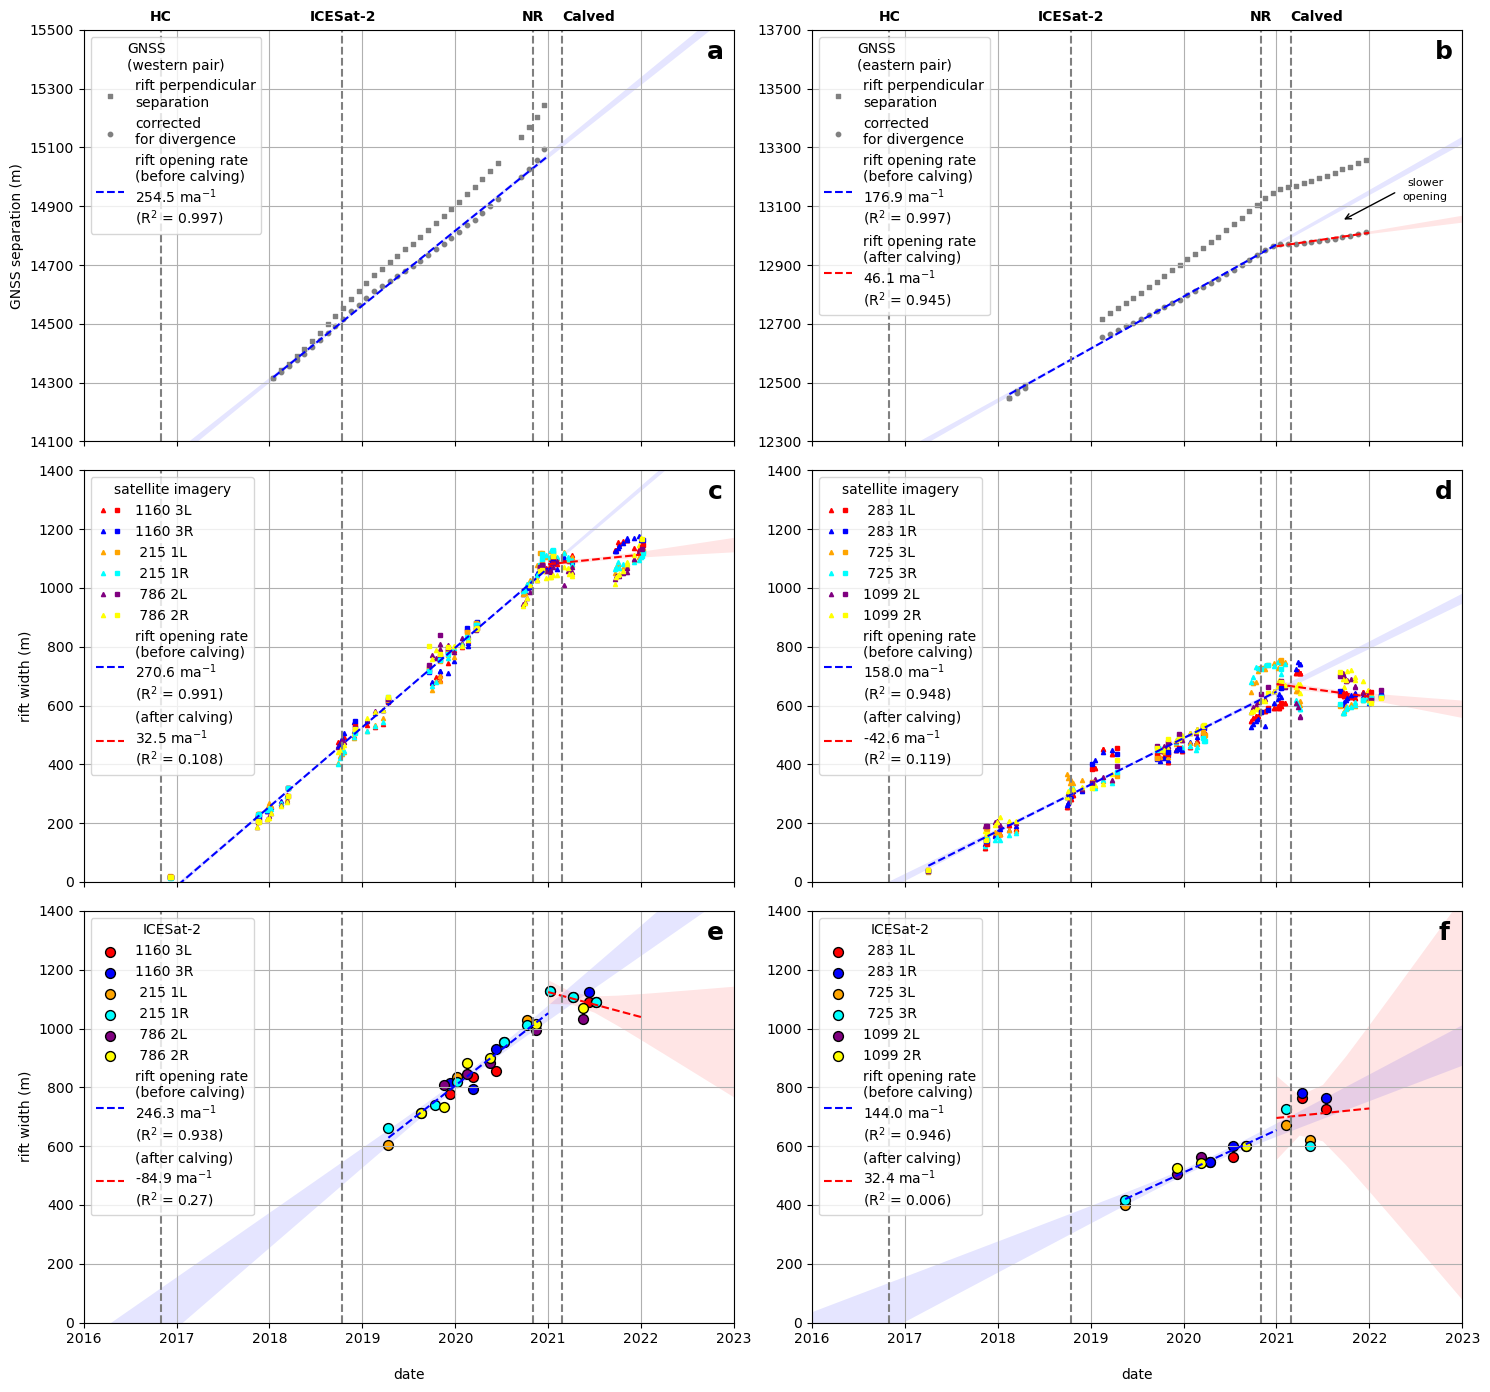

In [38]:
ftsz = 10 #font size

from matplotlib.legend_handler import HandlerLine2D

class HandlerXoffset(HandlerLine2D):
    def __init__(self, marker_pad=0.3, numpoints=1, x_offset=0,  **kw):
        HandlerLine2D.__init__(self, marker_pad=marker_pad, numpoints=numpoints, **kw)
        self._xoffset = x_offset
    def get_xdata(self, legend, xdescent, ydescent, width, height, fontsize):
        numpoints = self.get_numpoints(legend)
        
        if numpoints > 1:
            # we put some pad here to compensate the size of the
            # marker
            xdata = np.linspace(-xdescent + self._marker_pad * fontsize,
                                width - self._marker_pad * fontsize,
                                numpoints) - self._xoffset
            xdata_marker = xdata
        elif numpoints == 1:
            xdata = np.linspace(-xdescent, width, 2) - self._xoffset
            xdata_marker = [0.5 * width - 0.5 * xdescent - self._xoffset]

        return xdata, xdata_marker

fig=plt.figure(figsize=(15,14)) #,sharex='all', sharey='all',figsize=(10,10))

#------------------------------
# top left
ax1=fig.add_subplot(3,2,1)

ax1.fill_between(GNSS_west_pre_t_ls,GNSS_west_pre_conf_int_low,GNSS_west_pre_conf_int_up,facecolor='b',alpha=0.1)

pl_gps = ax1.scatter(hh00_t,actual_hh00_tt05_sep_d,s=10,c='gray',marker='s',label="rift perpendicular\nseparation")
pl_gps_div = ax1.scatter(hh00_t,actual_hh00_tt05_sep_d_div,s=10,c='gray',label="corrected\nfor divergence")
#y=mx+c 2016-2021 P1
pl_lobf = ax1.plot([np.min(hh00_t),div_t],[(wgps_div_slope_PreC*np.min(hh00_t))+wgps_div_inter_PreC,(wgps_div_slope_PreC*div_t)+wgps_div_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(wgps_div_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_hh00_tt05_PreC,3))+")")
handles, labels = ax1.get_legend_handles_labels()
order=[1,2,0]
ax1.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="GNSS\n(western pair)", loc= 'upper left', fontsize=ftsz)

ax1.plot([HC_found,HC_found],[14100,15500],'--',color='0.5')
ax1.text(HC_found,15530,'HC',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([IS_start,IS_start],[14100,15500],'--',color='0.5')
ax1.text(IS_start,15530,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_found,NR_found],[14100,15500],'--',color='0.5')
ax1.text(NR_found,15530,'NR',fontsize=ftsz,weight='bold',ha='center')
ax1.plot([NR_calve,NR_calve],[14100,15500],'--',color='0.5')
ax1.text(NR_calve,15530,'Calved',fontsize=ftsz,weight='bold',ha='left')

ax1.set_xlim(2016,2023)
ax1.set_ylim(14100,15500)
ax1.set_yticks([14100,14300,14500,14700,14900,15100,15300,15500])
ax1.grid()

ax1.axes.xaxis.set_ticklabels([])
ax1.set_ylabel("GNSS separation (m)")

ax1.annotate("a",(2022.8,1325+14100),size=18,weight='bold',ha='center',va='center')

#------------------------------
# top right
ax11=fig.add_subplot(3,2,2)

ax11.fill_between(GNSS_east_pre_t_ls,GNSS_east_pre_conf_int_low,GNSS_east_pre_conf_int_up,facecolor='b',alpha=0.1)
ax11.fill_between(GNSS_east_post_t_ls,GNSS_east_post_conf_int_low,GNSS_east_post_conf_int_up,facecolor='r',alpha=0.1)

pl_gps = ax11.scatter(ss00_t,actual_ss00_tt04_sep_d,s=10,c='gray',marker='s',label="rift perpendicular\nseparation")
pl_gps_div = ax11.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray',label="corrected\nfor divergence")
#y=mx+c 2016-2021 P1 P2 P3 P2P3
pl_lobf = ax11.plot([np.min(ss00_t),div_t],[(egps_div_slope_PreC*np.min(ss00_t))+egps_div_inter_PreC,(egps_div_slope_PreC*div_t)+egps_div_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(egps_div_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_ss00_tt04_PreC,3))+")")
#pl_lobf_cont = ax11.plot([np.min(ss00_t),np.max(ss00_t)],[(egps_div_slope_PreC*np.min(ss00_t))+egps_div_inter_PreC,(egps_div_slope_PreC*np.max(ss00_t))+egps_div_inter_PreC],'--',color='b',alpha=0.5)

#pl_lobf_P2 = ax11.plot([NR_div,mid_div],[(egps_div_slope_P2*NR_div)+egps_div_inter_P2,(egps_div_slope_P2*mid_div)+egps_div_inter_P2],'--',color='g',label="estimated\nrift opening rate\n"+str(round(egps_div_slope_P2,1))+" m/yr\n(R$^2$ = "+str(round(r2_ss00_tt04_P2,3))+")")
#pl_lobf_P3 = ax11.plot([mid_div,2022],[(egps_div_slope_P3*mid_div)+egps_div_inter_P3,(egps_div_slope_P3*2022)+egps_div_inter_P3],'--',color='g',label="estimated\nrift opening rate\n"+str(round(egps_div_slope_P3,1))+" m/yr\n(R$^2$ = "+str(round(r2_ss00_tt04_P3,3))+")")
pl_lobf_P2P3 = ax11.plot([div_t,2022],[(egps_div_slope_PostC*div_t)+egps_div_inter_PostC,(egps_div_slope_PostC*2022)+egps_div_inter_PostC],'--',color='r',label="rift opening rate\n(after calving)\n"+str(round(egps_div_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_ss00_tt04_PostC,3))+")")

handles, labels = ax11.get_legend_handles_labels()
order=[2,3,0,1]
ax11.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="GNSS\n(eastern pair)", loc= 'upper left', fontsize=ftsz)

ax11.plot([HC_found,HC_found],[12300,13700],'--',color='0.5')
ax11.text(HC_found,13730,'HC',fontsize=ftsz,weight='bold',ha='center')
ax11.plot([IS_start,IS_start],[12300,13700],'--',color='0.5')
ax11.text(IS_start,13730,'ICESat-2',fontsize=ftsz,weight='bold',ha='center')
ax11.plot([NR_found,NR_found],[12300,13700],'--',color='0.5')
ax11.text(NR_found,13730,'NR',fontsize=ftsz,weight='bold',ha='center')
ax11.plot([NR_calve,NR_calve],[12300,13700],'--',color='0.5')
ax11.text(NR_calve,13730,'Calved',fontsize=ftsz,weight='bold',ha='left')

ax11.set_xlim(2016,2023)
ax11.set_ylim(12300,13700)
ax11.set_yticks([12300,12500,12700,12900,13100,13300,13500,13700])
ax11.grid()

ax11.axes.xaxis.set_ticklabels([])
#ax11.set_ylabel("separation (m)")

ax11.annotate("b",(2022.8,1325+12300),size=18,weight='bold',ha='center',va='center')

#ax11.annotate('', xy=(2021.7,12850), xytext=(2021.7,13050), arrowprops=dict(arrowstyle='<-'))
#ax11.annotate("slower",(2021.7,12800),fontsize=8,ha="center")
#ax11.annotate("opening",(2021.7,12750),fontsize=8,ha="center")

ax11.annotate('', xy=(2022.3,13150), xytext=(2021.7,13050), arrowprops=dict(arrowstyle='<-'))
ax11.annotate("slower",(2022.6,13170),fontsize=8,ha="center")
ax11.annotate("opening",(2022.6,13120),fontsize=8,ha="center")


#inset
#axins11=ax11.inset_axes([0.775, 0.075, 0.2, 0.2])
#axins11.fill_between(GNSS_east_pre_t_ls,GNSS_east_pre_conf_int_low,GNSS_east_pre_conf_int_up,facecolor='b',alpha=0.1)
#axins11.fill_between(GNSS_east_post_t_ls,GNSS_east_post_conf_int_low,GNSS_east_post_conf_int_up,facecolor='r',alpha=0.1)

#axins11.plot([np.min(ss00_t),div_t],[(egps_div_slope_PreC*np.min(ss00_t))+egps_div_inter_PreC,(egps_div_slope_PreC*div_t)+egps_div_inter_PreC],'--',color='b')
#axins11.plot([div_t,2022],[(egps_div_slope_PostC*div_t)+egps_div_inter_PostC,(egps_div_slope_PostC*2022)+egps_div_inter_PostC],'--',color='r')

#axins11.scatter(ss00_t,actual_ss00_tt04_sep_d_div,s=10,c='gray')

#axins11.plot([NR_found,NR_found],[12900,13100],'--',color='0.5')
#axins11.text(NR_found,13010,'NR',fontsize=ftsz,weight='bold',ha='center')
#axins11.plot([NR_calve,NR_calve],[12900,13100],'--',color='0.5')
#axins11.text(NR_calve,13010,'Calved',fontsize=ftsz,weight='bold',ha='center')

#axins11.set_xlim(2020.75,2021.25)
#axins11.set_ylim(12900,13000)
#axins11.set_xticks([2021])
#axins11.set_yticks([])
#axins11.grid()

#ax11.plot([2020.75,2020.75,2021.25,2021.25,2020.75],\
#           [12900,13000,13000,12900,12900],\
#           '--',color='k',linewidth=0.5)


#------------------------------
# middle left
ax2=fig.add_subplot(3,2,3)

ax2.fill_between(sat_west_pre_t_ls,sat_west_pre_conf_int_low,sat_west_pre_conf_int_up,facecolor='b',alpha=0.1)
ax2.fill_between(sat_west_post_t_ls,sat_west_post_conf_int_low,sat_west_post_conf_int_up,facecolor='r',alpha=0.1)

ms=3
ma=1
pl_sat1,  = ax2.plot(wsatd1,wsatw1,'^',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat2,  = ax2.plot(wsatd2,wsatw2,'^',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat3,  = ax2.plot(wsatd3,wsatw3,'^',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat4,  = ax2.plot(wsatd4,wsatw4,'^',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat5,  = ax2.plot(wsatd5,wsatw5,'^',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat6,  = ax2.plot(wsatd6,wsatw6,'^',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)
pl_sat7,  = ax2.plot(wsatd7,wsatw7,'s',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat8,  = ax2.plot(wsatd8,wsatw8,'s',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat9,  = ax2.plot(wsatd9,wsatw9,'s',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat10, = ax2.plot(wsatd10,wsatw10,'s',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat11, = ax2.plot(wsatd11,wsatw11,'s',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat12, = ax2.plot(wsatd12,wsatw12,'s',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)

#y=mx+c 2016-2021 P1 P2 P3 P2P3
pl_lobf, = ax2.plot([np.min(decdate_sat_west),div_t],[(wsat_slope_PreC*np.min(decdate_sat_west))+wsat_inter_PreC,(wsat_slope_PreC*div_t)+wsat_inter_PreC],'--',color='b')

pl_lobf_P2P3, = ax2.plot([div_t,2022],[(wsat_slope_PostC*div_t)+wsat_inter_PostC,(wsat_slope_PostC*2022)+wsat_inter_PostC],'--',color='r')

plt.legend([(pl_sat1,pl_sat7),(pl_sat2,pl_sat8),(pl_sat3,pl_sat9),(pl_sat4,pl_sat10),(pl_sat5,pl_sat11),(pl_sat6,pl_sat12),pl_lobf,pl_lobf_P2P3],\
           ["1160 3L", "1160 3R", " 215 1L", " 215 1R", " 786 2L", " 786 2R","rift opening rate\n(before calving)\n"+str(round(wsat_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wsat_PreC,3))+")","(after calving)\n"+str(round(wsat_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wsat_PostC,3))+")"],\
            handler_map={pl_sat1:HandlerXoffset(x_offset=5),   
                         pl_sat7:HandlerXoffset(x_offset=-5),
                         pl_sat2:HandlerXoffset(x_offset=5),   
                         pl_sat8:HandlerXoffset(x_offset=-5),
                         pl_sat3:HandlerXoffset(x_offset=5),   
                         pl_sat9:HandlerXoffset(x_offset=-5),
                         pl_sat4:HandlerXoffset(x_offset=5),   
                         pl_sat10:HandlerXoffset(x_offset=-5),
                         pl_sat5:HandlerXoffset(x_offset=5),   
                         pl_sat11:HandlerXoffset(x_offset=-5),
                         pl_sat6:HandlerXoffset(x_offset=5),   
                         pl_sat12:HandlerXoffset(x_offset=-5)},
                         title="satellite imagery", loc= 'upper left', fontsize=ftsz)


ax2.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax2.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax2.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax2.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax2.set_xlim(2016,2023)
ax2.set_ylim(0,1400)
ax2.grid()

ax2.axes.xaxis.set_ticklabels([])

ax2.annotate("c",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
ax2.set_ylabel("rift width (m)")

#------------------------------
# middle right
ax22=fig.add_subplot(3,2,4)

ax22.fill_between(sat_east_pre_t_ls,sat_east_pre_conf_int_low,sat_east_pre_conf_int_up,facecolor='b',alpha=0.1)
ax22.fill_between(sat_east_post_t_ls,sat_east_post_conf_int_low,sat_east_post_conf_int_up,facecolor='r',alpha=0.1)

ms=3
ma=1
pl_sat1,  = ax22.plot(esatd1,esatw1,'^',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat1,  = ax22.plot(esatd1,esatw1,'^',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat2,  = ax22.plot(esatd2,esatw2,'^',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat3,  = ax22.plot(esatd3,esatw3,'^',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat4,  = ax22.plot(esatd4,esatw4,'^',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat5,  = ax22.plot(esatd5,esatw5,'^',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat6,  = ax22.plot(esatd6,esatw6,'^',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)
pl_sat7,  = ax22.plot(esatd7,esatw7,'s',mfc='r',mec='r',markersize=ms,alpha=ma)
pl_sat8,  = ax22.plot(esatd8,esatw8,'s',mfc='b',mec='b',markersize=ms,alpha=ma)
pl_sat9,  = ax22.plot(esatd9,esatw9,'s',mfc='orange',mec='orange',markersize=ms,alpha=ma)
pl_sat10, = ax22.plot(esatd10,esatw10,'s',mfc='cyan',mec='cyan',markersize=ms,alpha=ma)
pl_sat11, = ax22.plot(esatd11,esatw11,'s',mfc='purple',mec='purple',markersize=ms,alpha=ma)
pl_sat12, = ax22.plot(esatd12,esatw12,'s',mfc='yellow',mec='yellow',markersize=ms,alpha=ma)

#y=mx+c 2016-2021 P1 P2 P3 P2P3
pl_lobf, = ax22.plot([np.min(decdate_sat_east),div_t],[(esat_slope_PreC*np.min(decdate_sat_east))+esat_inter_PreC,(esat_slope_PreC*div_t)+esat_inter_PreC],'--',color='b')

pl_lobf_P2P3, = ax22.plot([div_t,2022],[(esat_slope_PostC*div_t)+esat_inter_PostC,(esat_slope_PostC*2022)+esat_inter_PostC],'--',color='r')

plt.legend([(pl_sat1,pl_sat7),(pl_sat2,pl_sat8),(pl_sat3,pl_sat9),(pl_sat4,pl_sat10),(pl_sat5,pl_sat11),(pl_sat6,pl_sat12),pl_lobf,pl_lobf_P2P3],\
           [" 283 1L", " 283 1R", " 725 3L", " 725 3R", "1099 2L", "1099 2R","rift opening rate\n(before calving)\n"+str(round(esat_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_esat_PreC,3))+")","(after calving)\n"+str(round(esat_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_esat_PostC,3))+")"],\
            handler_map={pl_sat1:HandlerXoffset(x_offset=5),   
                         pl_sat7:HandlerXoffset(x_offset=-5),
                         pl_sat2:HandlerXoffset(x_offset=5),   
                         pl_sat8:HandlerXoffset(x_offset=-5),
                         pl_sat3:HandlerXoffset(x_offset=5),   
                         pl_sat9:HandlerXoffset(x_offset=-5),
                         pl_sat4:HandlerXoffset(x_offset=5),   
                         pl_sat10:HandlerXoffset(x_offset=-5),
                         pl_sat5:HandlerXoffset(x_offset=5),   
                         pl_sat11:HandlerXoffset(x_offset=-5),
                         pl_sat6:HandlerXoffset(x_offset=5),   
                         pl_sat12:HandlerXoffset(x_offset=-5)},
                         title="satellite imagery", loc= 'upper left', fontsize=ftsz)

ax22.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax22.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax22.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax22.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax22.set_xlim(2016,2023)
ax22.set_ylim(0,1400)
ax22.grid()

ax22.axes.xaxis.set_ticklabels([])

ax22.annotate("d",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
#ax22.set_ylabel("rift width (m)")

#------------------------------
# bottom left
ax3=fig.add_subplot(3,2,5)

ax3.fill_between(IS2_west_pre_t_ls,IS2_west_pre_conf_int_low,IS2_west_pre_conf_int_up,facecolor='b',alpha=0.1)
ax3.fill_between(IS2_west_post_t_ls,IS2_west_post_conf_int_low,IS2_west_post_conf_int_up,facecolor='r',alpha=0.1)

ms=50
ma=1
pl_is21  = ax3.scatter(decdate_sub_1160_3l,width_1160_3l,edgecolor='k',s=ms,alpha=ma,color='r',label="1160 3L")      #1160 3l is2 red
pl_is22  = ax3.scatter(decdate_sub_1160_3r,width_1160_3r,edgecolor='k',s=ms,alpha=ma,color='b',label="1160 3R")      #1160 3r is2 blue
pl_is23  = ax3.scatter(decdate_sub_215_1l,width_215_1l,edgecolor='k',s=ms,alpha=ma,color='orange',label=" 215 1L")   #215  1l is2 orange
pl_is24  = ax3.scatter(decdate_sub_215_1r,width_215_1r,edgecolor='k',s=ms,alpha=ma,color='cyan',label=" 215 1R")     #215  1r is2 cyan
pl_is25  = ax3.scatter(decdate_sub_786_2l,width_786_2l,edgecolor='k',s=ms,alpha=ma,color='purple',label=" 786 2L")   #786  2l is2 'red'
pl_is26  = ax3.scatter(decdate_sub_786_2r,width_786_2r,edgecolor='k',s=ms,alpha=ma,color='yellow',label=" 786 2R")   #786  2r is2 'blue'

#y=mx+c 2016-2021 P1 P2 P2P3
pl_lobf = ax3.plot([np.min(decdate_sub_is2_west),div_t],[(wis2_slope_PreC*np.min(decdate_sub_is2_west))+wis2_inter_PreC,(wis2_slope_PreC*div_t)+wis2_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(wis2_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wis2_PreC,3))+")")

pl_lobf_P2P3 = ax3.plot([div_t,2022],[(wis2_slope_PostC*div_t)+wis2_inter_PostC,(wis2_slope_PostC*2022)+wis2_inter_PostC],'--',color='r',label="(after calving)\n"+str(round(wis2_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_wis2_PostC,3))+")")

handles, labels = ax3.get_legend_handles_labels()
order=[2,3,4,5,6,7,0,1]
ax3.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="ICESat-2", loc= 'upper left', fontsize=ftsz)

ax3.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax3.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax3.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax3.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax3.set_xlim(2016,2023)
ax3.set_ylim(0,1400)
ax3.grid()

ax3.annotate("e",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
ax3.set_ylabel("rift width (m)")
ax3.set_xlabel("\ndate")

#------------------------------
# bottom right
ax33=fig.add_subplot(3,2,6)

ax33.fill_between(IS2_east_pre_t_ls,IS2_east_pre_conf_int_low,IS2_east_pre_conf_int_up,facecolor='b',alpha=0.1)
ax33.fill_between(IS2_east_post_t_ls,IS2_east_post_conf_int_low,IS2_east_post_conf_int_up,facecolor='r',alpha=0.1)

ms=50
ma=1
pl_is21  = ax33.scatter(decdate_sub_283_1l,width_283_1l,edgecolor='k',s=ms,alpha=ma,color='r',label=" 283 1L")          #283  1l is2 red
pl_is22  = ax33.scatter(decdate_sub_283_1r,width_283_1r,edgecolor='k',s=ms,alpha=ma,color='b',label=" 283 1R")          #283  1r is2 blue
pl_is23  = ax33.scatter(decdate_sub_725_3l,width_725_3l,edgecolor='k',s=ms,alpha=ma,color='orange',label=" 725 3L")     #725  3l is2 orange
pl_is24  = ax33.scatter(decdate_sub_725_3r,width_725_3r,edgecolor='k',s=ms,alpha=ma,color='cyan',label=" 725 3R")       #725  3r is2 cyan
pl_is25  = ax33.scatter(decdate_sub_1099_2l,width_1099_2l,edgecolor='k',s=ms,alpha=ma,color='purple',label="1099 2L")   #1099 2l is2 'red'
pl_is26  = ax33.scatter(decdate_sub_1099_2r,width_1099_2r,edgecolor='k',s=ms,alpha=ma,color='yellow',label="1099 2R")   #1099 2r is2 'blue'

#y=mx+c 2016-2021 P1 P2 P2P3
pl_lobf = ax33.plot([np.min(decdate_sub_is2_east),div_t],[(eis2_slope_PreC*np.min(decdate_sub_is2_east))+eis2_inter_PreC,(eis2_slope_PreC*div_t)+eis2_inter_PreC],'--',color='b',label="rift opening rate\n(before calving)\n"+str(round(eis2_slope_PreC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_eis2_PreC,3))+")")

pl_lobf_P2P3 = ax33.plot([div_t,2022],[(eis2_slope_PostC*div_t)+eis2_inter_PostC,(eis2_slope_PostC*2022)+eis2_inter_PostC],'--',color='r',label="(after calving)\n"+str(round(eis2_slope_PostC,1))+" ma$^{-1}$\n(R$^2$ = "+str(round(r2_eis2_PostC,3))+")")

handles, labels = ax33.get_legend_handles_labels()
order=[2,3,4,5,6,7,0,1]
ax33.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title="ICESat-2", loc= 'upper left', fontsize=ftsz)

ax33.plot([HC_found,HC_found],[0,2000],'--',color='0.5')
ax33.plot([IS_start,IS_start],[0,2000],'--',color='0.5')
ax33.plot([NR_found,NR_found],[0,2000],'--',color='0.5')
ax33.plot([NR_calve,NR_calve],[0,2000],'--',color='0.5')

ax33.set_xlim(2016,2023)
ax33.set_ylim(0,1400)
ax33.grid()

ax33.annotate("f",(2022.8,1325),size=18,weight='bold',ha='center',va='center')
#ax33.set_ylabel("rift width (m)")
ax33.set_xlabel("\ndate")


plt.tight_layout()

output = figure_folder+'/fig06_lobf_graph_calve_div.png'
plt.savefig(output, dpi=100, bbox_inches='tight')

plt.show()

## Compute the standard deviation of the rates

In [45]:
# Function to compute 1-sigma (standard error of the slope)
def compute_sigma(x, y, slope, intercept):
    n = len(x)
    y_pred = slope * x + intercept
    residuals = y - y_pred
    std_error_res = np.sqrt(np.sum(residuals**2) / (n - 2))
    se_slope = std_error_res / np.sqrt(np.sum((x - np.mean(x))**2))
    return se_slope

# GNSS - Western pair (pre-calving)
sigma_west = compute_sigma(np.array(hh00_t), np.array(actual_hh00_tt05_sep_d_div), wgps_div_slope_PreC, wgps_div_inter_PreC)
print(f"Western GNSS regression (pre-calving) 1-sigma: {sigma_west}")

# GNSS - Eastern pair (pre-calving)
sigma_east_pre = compute_sigma(np.array(ss00_t), np.array(actual_ss00_tt04_sep_d_div), egps_div_slope_PreC, egps_div_inter_PreC)
print(f"Eastern GNSS regression (pre-calving) 1-sigma: {sigma_east_pre}")

# GNSS - Eastern pair (post-calving)
sigma_east_post = compute_sigma(np.array(ss00_t), np.array(actual_ss00_tt04_sep_d_div), egps_div_slope_PostC, egps_div_inter_PostC)
print(f"Eastern GNSS regression (post-calving) 1-sigma: {sigma_east_post}")

# ICESat-2 - Western pair (pre-calving)
sigma_is2_west_pre = compute_sigma(np.array(decdate_sub_1160_3l), np.array(width_1160_3l), wis2_slope_PreC, wis2_inter_PreC)
print(f"ICESat-2 Western (pre-calving) 1-sigma: {sigma_is2_west_pre}")

# ICESat-2 - Western pair (post-calving)
sigma_is2_west_post = compute_sigma(np.array(decdate_sub_1160_3l), np.array(width_1160_3l), wis2_slope_PostC, wis2_inter_PostC)
print(f"ICESat-2 Western (post-calving) 1-sigma: {sigma_is2_west_post}")

# ICESat-2 - Eastern pair (pre-calving)
sigma_is2_east_pre = compute_sigma(np.array(decdate_sub_283_1l), np.array(width_283_1l), eis2_slope_PreC, eis2_inter_PreC)
print(f"ICESat-2 Eastern (pre-calving) 1-sigma: {sigma_is2_east_pre}")

# ICESat-2 - Eastern pair (post-calving)
sigma_is2_east_post = compute_sigma(np.array(decdate_sub_283_1l), np.array(width_283_1l), eis2_slope_PostC, eis2_inter_PostC)
print(f"ICESat-2 Eastern (post-calving) 1-sigma: {sigma_is2_east_post}")

# Satellite - Western (pre-calving)
sigma_sat_west_pre = compute_sigma(np.array(wsatd1), np.array(wsatw1), wsat_slope_PreC, wsat_inter_PreC)
print(f"Satellite Western (pre-calving) 1-sigma: {sigma_sat_west_pre}")

# Satellite - Western (post-calving)
sigma_sat_west_post = compute_sigma(np.array(wsatd1), np.array(wsatw1), wsat_slope_PostC, wsat_inter_PostC)
print(f"Satellite Western (post-calving) 1-sigma: {sigma_sat_west_post}")

# Satellite - Eastern (pre-calving)
sigma_sat_east_pre = compute_sigma(np.array(esatd1), np.array(esatw1), esat_slope_PreC, esat_inter_PreC)
print(f"Satellite Eastern (pre-calving) 1-sigma: {sigma_sat_east_pre}")

# Satellite - Eastern (post-calving)
sigma_sat_east_post = compute_sigma(np.array(esatd1), np.array(esatw1), esat_slope_PostC, esat_inter_PostC)
print(f"Satellite Eastern (post-calving) 1-sigma: {sigma_sat_east_post}")

Western GNSS regression (pre-calving) 1-sigma: 2.449519244601679
Eastern GNSS regression (pre-calving) 1-sigma: 7.445303506224079
Eastern GNSS regression (post-calving) 1-sigma: 24.156710624109348
ICESat-2 Western (pre-calving) 1-sigma: 60.09355907607637
ICESat-2 Western (post-calving) 1-sigma: 404.88645732049173
ICESat-2 Eastern (pre-calving) 1-sigma: 50.07259042465222
ICESat-2 Eastern (post-calving) 1-sigma: 126.6720331831823
Satellite Western (pre-calving) 1-sigma: 8.208713132819891
Satellite Western (post-calving) 1-sigma: 40.88135211901139
Satellite Eastern (pre-calving) 1-sigma: 8.384109827776845
Satellite Eastern (post-calving) 1-sigma: 36.52789011100736
